# Using LightGBM classifier on credit card user data to predict default rate

This notebook utilizes the LightGBM package by Microsoft with a clean dataset on credit card defaults (source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). Since we are trying to predict if a person is defaulting or not, we will want to use binary classification. This notebook also explores early stopping, a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration.

In [186]:
import pandas as pd
import lightgbm as lgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt

In [187]:
data = pd.read_excel('ccdata.xls', header = 1)

In [188]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


In [189]:
data.drop('ID', axis = 1, inplace = True)

In [190]:
# Check for null values. 
data.isnull().sum().sort_values(ascending=False)

default payment next month    0
PAY_AMT6                      0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
LIMIT_BAL                     0
dtype: int64

Thank god there are no missing values! If there were, we would have to either drop the feature if 
there are more than 60% of the values are missing, or impute them. 

In [191]:
# Below, we separate our target variable from our dataset. 
X = data.drop(['default payment next month'], axis=1)
y = data['default payment next month']


# Let's then put 85% of our dataset into a training set and 15% of it into a test set. 
# We can use random_state because it is not a time series dataset that we are using.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)
X_train.shape


(25500, 23)

<h2>LightGBM classifier hyperparameter optimization via scikit-learn's GridSearchCV</h2>

In [192]:
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)



[1]	valid_0's binary_logloss: 0.650207	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.615119	valid_0's auc: 0.774063
[3]	valid_0's binary_logloss: 0.586092	valid_0's auc: 0.777479
[4]	valid_0's binary_logloss: 0.562124	valid_0's auc: 0.77645
[5]	valid_0's binary_logloss: 0.541655	valid_0's auc: 0.779865
[6]	valid_0's binary_logloss: 0.524583	valid_0's auc: 0.780002
[7]	valid_0's binary_logloss: 0.509788	valid_0's auc: 0.782511
[8]	valid_0's binary_logloss: 0.497611	valid_0's auc: 0.783665
[9]	valid_0's binary_logloss: 0.487372	valid_0's auc: 0.783763
[10]	valid_0's binary_logloss: 0.478427	valid_0's auc: 0.784614
[11]	valid_0's binary_logloss: 0.470891	valid_0's auc: 0.785279
[12]	valid_0's binary_logloss: 0.464357	valid_0's auc: 0.785986
[13]	valid_0's binary_logloss: 0.458898	valid_0's auc: 0.786532
[14]	valid_0's binary_logloss: 0.454407	valid_0's auc: 0.786612
[15]	valid_0's binary_logloss: 0.450447	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[16]	valid_0's binary_logloss: 0.44569	valid_0's auc: 0.785635
[17]	valid_0's binary_logloss: 0.44275	valid_0's auc: 0.785649
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686
[1]	valid_0's binary_logloss: 0.64967	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614175	valid_0's auc: 0.77112
[3]	valid_0's binary_logloss: 0.584761	valid_0's auc: 0.774763
[4]	valid_0's binary_logloss: 0.560398	valid_0's auc: 0.776656
[5]	valid_0's binary_logloss: 0.54019	valid_0's auc: 0.778347
[6]	valid_0's binary_logloss: 0.52289	valid_0's auc: 0.779278
[7]	valid_0's binary_logloss: 0.508924	valid_0's auc: 0.779956
[8]	valid_0's binary_logloss: 0.496837	valid_0's auc: 0.779875
[9]	valid_0's binary_logloss: 0.486481	valid_0's auc: 0.779684
[10]	valid_0's binary_logloss: 0.477617	valid_0's auc: 0.780896
[11]	valid_0's binary_logloss: 0.470387	valid_0's auc: 0.781103
[12]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.650207	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.615119	valid_0's auc: 0.774063
[3]	valid_0's binary_logloss: 0.586092	valid_0's auc: 0.777479
[4]	valid_0's binary_logloss: 0.562124	valid_0's auc: 0.77645
[5]	valid_0's binary_logloss: 0.541655	valid_0's auc: 0.779865
[6]	valid_0's binary_logloss: 0.524583	valid_0's auc: 0.780002
[7]	valid_0's binary_logloss: 0.509788	valid_0's auc: 0.782511
[8]	valid_0's binary_logloss: 0.497611	valid_0's auc: 0.783665
[9]	valid_0's binary_logloss: 0.487372	valid_0's auc: 0.783763
[10]	valid_0's binary_logloss: 0.478427	valid_0's auc: 0.784614
[11]	valid_0's binary_logloss: 0.470891	valid_0's auc: 0.785279
[12]	valid_0's binary_logloss: 0.464357	valid_0's auc: 0.785986
[13]	valid_0's binary_logloss: 0.458898	valid_0's auc: 0.786532
[14]	valid_0's binary_logloss: 0.454407	valid_0's auc: 0.786612
[15]	valid_0's binary_logloss: 0.450447	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649266	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613877	valid_0's auc: 0.770921
[3]	valid_0's binary_logloss: 0.584421	valid_0's auc: 0.778833
[4]	valid_0's binary_logloss: 0.56	valid_0's auc: 0.781853
[5]	valid_0's binary_logloss: 0.539562	valid_0's auc: 0.781552
[6]	valid_0's binary_logloss: 0.5223	valid_0's auc: 0.783858
[7]	valid_0's binary_logloss: 0.507772	valid_0's auc: 0.784464
[8]	valid_0's binary_logloss: 0.495401	valid_0's auc: 0.785847
[9]	valid_0's binary_logloss: 0.485026	valid_0's auc: 0.787005
[10]	valid_0's binary_logloss: 0.47614	valid_0's auc: 0.787186
[11]	valid_0's binary_logloss: 0.468611	valid_0's auc: 0.787638
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686
[13]	valid_0's binary_logloss: 0.45673	valid_0's auc: 0.78737
[14]	valid_0's binary_logloss: 0.452424	valid_0's auc: 0.786931
[15]	valid_0's binary_logloss: 0.448699	valid_0's auc: 0.7861

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[6]	valid_0's binary_logloss: 0.52289	valid_0's auc: 0.779278
[7]	valid_0's binary_logloss: 0.508924	valid_0's auc: 0.779956
[8]	valid_0's binary_logloss: 0.496837	valid_0's auc: 0.779875
[9]	valid_0's binary_logloss: 0.486481	valid_0's auc: 0.779684
[10]	valid_0's binary_logloss: 0.477617	valid_0's auc: 0.780896
[11]	valid_0's binary_logloss: 0.470387	valid_0's auc: 0.781103
[12]	valid_0's binary_logloss: 0.463881	valid_0's auc: 0.782157
[13]	valid_0's binary_logloss: 0.458482	valid_0's auc: 0.78233
[14]	valid_0's binary_logloss: 0.453784	valid_0's auc: 0.783221
[15]	valid_0's binary_logloss: 0.450137	valid_0's auc: 0.782492
[16]	valid_0's binary_logloss: 0.446632	valid_0's auc: 0.782647
[17]	valid_0's binary_logloss: 0.443552	valid_0's auc: 0.783682
[18]	valid_0's binary_logloss: 0.441098	valid_0's auc: 0.783869
[19]	valid_0's binary_logloss: 0.438821	valid_0's auc: 0.784636
[20]	valid_0's binary_logloss: 0.437055	valid_0's auc: 0.784347
[21]	valid_0's binary_logloss: 0.435459	valid_

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.650207	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.615119	valid_0's auc: 0.774063
[3]	valid_0's binary_logloss: 0.586092	valid_0's auc: 0.777479
[4]	valid_0's binary_logloss: 0.562124	valid_0's auc: 0.77645
[5]	valid_0's binary_logloss: 0.541655	valid_0's auc: 0.779865
[6]	valid_0's binary_logloss: 0.524583	valid_0's auc: 0.780002
[7]	valid_0's binary_logloss: 0.509788	valid_0's auc: 0.782511
[8]	valid_0's binary_logloss: 0.497611	valid_0's auc: 0.783665
[9]	valid_0's binary_logloss: 0.487372	valid_0's auc: 0.783763
[10]	valid_0's binary_logloss: 0.478427	valid_0's auc: 0.784614
[11]	valid_0's binary_logloss: 0.470891	valid_0's auc: 0.785279
[12]	valid_0's binary_logloss: 0.464357	valid_0's auc: 0.785986
[13]	valid_0's binary_logloss: 0.458898	valid_0's auc: 0.786532
[14]	valid_0's binary_logloss: 0.454407	valid_0's auc: 0.786612
[15]	valid_0's binary_logloss: 0.450447	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649266	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613877	valid_0's auc: 0.770921
[3]	valid_0's binary_logloss: 0.584421	valid_0's auc: 0.778833
[4]	valid_0's binary_logloss: 0.56	valid_0's auc: 0.781853
[5]	valid_0's binary_logloss: 0.539562	valid_0's auc: 0.781552
[6]	valid_0's binary_logloss: 0.5223	valid_0's auc: 0.783858
[7]	valid_0's binary_logloss: 0.507772	valid_0's auc: 0.784464
[8]	valid_0's binary_logloss: 0.495401	valid_0's auc: 0.785847
[9]	valid_0's binary_logloss: 0.485026	valid_0's auc: 0.787005
[10]	valid_0's binary_logloss: 0.47614	valid_0's auc: 0.787186
[11]	valid_0's binary_logloss: 0.468611	valid_0's auc: 0.787638
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686
[13]	valid_0's binary_logloss: 0.45673	valid_0's auc: 0.78737
[14]	valid_0's binary_logloss: 0.452424	valid_0's auc: 0.786931
[15]	valid_0's binary_logloss: 0.448699	valid_0's auc: 0.7861

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.64967	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614175	valid_0's auc: 0.77112
[3]	valid_0's binary_logloss: 0.584761	valid_0's auc: 0.774763
[4]	valid_0's binary_logloss: 0.560398	valid_0's auc: 0.776656
[5]	valid_0's binary_logloss: 0.54019	valid_0's auc: 0.778347
[6]	valid_0's binary_logloss: 0.52289	valid_0's auc: 0.779278
[7]	valid_0's binary_logloss: 0.508924	valid_0's auc: 0.779956
[8]	valid_0's binary_logloss: 0.496837	valid_0's auc: 0.779875
[9]	valid_0's binary_logloss: 0.486481	valid_0's auc: 0.779684
[10]	valid_0's binary_logloss: 0.477617	valid_0's auc: 0.780896
[11]	valid_0's binary_logloss: 0.470387	valid_0's auc: 0.781103
[12]	valid_0's binary_logloss: 0.463881	valid_0's auc: 0.782157
[13]	valid_0's binary_logloss: 0.458482	valid_0's auc: 0.78233
[14]	valid_0's binary_logloss: 0.453784	valid_0's auc: 0.783221
[15]	valid_0's binary_logloss: 0.450137	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.650207	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.615119	valid_0's auc: 0.774063
[3]	valid_0's binary_logloss: 0.586092	valid_0's auc: 0.777479
[4]	valid_0's binary_logloss: 0.562124	valid_0's auc: 0.77645
[5]	valid_0's binary_logloss: 0.541655	valid_0's auc: 0.779865
[6]	valid_0's binary_logloss: 0.524583	valid_0's auc: 0.780002
[7]	valid_0's binary_logloss: 0.509788	valid_0's auc: 0.782511
[8]	valid_0's binary_logloss: 0.497611	valid_0's auc: 0.783665
[9]	valid_0's binary_logloss: 0.487372	valid_0's auc: 0.783763
[10]	valid_0's binary_logloss: 0.478427	valid_0's auc: 0.784614
[11]	valid_0's binary_logloss: 0.470891	valid_0's auc: 0.785279
[12]	valid_0's binary_logloss: 0.464357	valid_0's auc: 0.785986
[13]	valid_0's binary_logloss: 0.458898	valid_0's auc: 0.786532
[14]	valid_0's binary_logloss: 0.454407	valid_0's auc: 0.786612
[15]	valid_0's binary_logloss: 0.450447	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649266	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613877	valid_0's auc: 0.770921
[3]	valid_0's binary_logloss: 0.584421	valid_0's auc: 0.778833
[4]	valid_0's binary_logloss: 0.56	valid_0's auc: 0.781853
[5]	valid_0's binary_logloss: 0.539562	valid_0's auc: 0.781552
[6]	valid_0's binary_logloss: 0.5223	valid_0's auc: 0.783858
[7]	valid_0's binary_logloss: 0.507772	valid_0's auc: 0.784464
[8]	valid_0's binary_logloss: 0.495401	valid_0's auc: 0.785847
[9]	valid_0's binary_logloss: 0.485026	valid_0's auc: 0.787005
[10]	valid_0's binary_logloss: 0.47614	valid_0's auc: 0.787186
[11]	valid_0's binary_logloss: 0.468611	valid_0's auc: 0.787638
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686
[13]	valid_0's binary_logloss: 0.45673	valid_0's auc: 0.78737
[14]	valid_0's binary_logloss: 0.452424	valid_0's auc: 0.786931
[15]	valid_0's binary_logloss: 0.448699	valid_0's auc: 0.7861

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.64967	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614175	valid_0's auc: 0.77112
[3]	valid_0's binary_logloss: 0.584761	valid_0's auc: 0.774763
[4]	valid_0's binary_logloss: 0.560398	valid_0's auc: 0.776656
[5]	valid_0's binary_logloss: 0.54019	valid_0's auc: 0.778347
[6]	valid_0's binary_logloss: 0.52289	valid_0's auc: 0.779278
[7]	valid_0's binary_logloss: 0.508924	valid_0's auc: 0.779956
[8]	valid_0's binary_logloss: 0.496837	valid_0's auc: 0.779875
[9]	valid_0's binary_logloss: 0.486481	valid_0's auc: 0.779684
[10]	valid_0's binary_logloss: 0.477617	valid_0's auc: 0.780896
[11]	valid_0's binary_logloss: 0.470387	valid_0's auc: 0.781103
[12]	valid_0's binary_logloss: 0.463881	valid_0's auc: 0.782157
[13]	valid_0's binary_logloss: 0.458482	valid_0's auc: 0.78233
[14]	valid_0's binary_logloss: 0.453784	valid_0's auc: 0.783221
[15]	valid_0's binary_logloss: 0.450137	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.650207	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.615119	valid_0's auc: 0.774063
[3]	valid_0's binary_logloss: 0.586092	valid_0's auc: 0.777479
[4]	valid_0's binary_logloss: 0.562124	valid_0's auc: 0.77645
[5]	valid_0's binary_logloss: 0.541655	valid_0's auc: 0.779865
[6]	valid_0's binary_logloss: 0.524583	valid_0's auc: 0.780002
[7]	valid_0's binary_logloss: 0.509788	valid_0's auc: 0.782511
[8]	valid_0's binary_logloss: 0.497611	valid_0's auc: 0.783665
[9]	valid_0's binary_logloss: 0.487372	valid_0's auc: 0.783763
[10]	valid_0's binary_logloss: 0.478427	valid_0's auc: 0.784614
[11]	valid_0's binary_logloss: 0.470891	valid_0's auc: 0.785279
[12]	valid_0's binary_logloss: 0.464357	valid_0's auc: 0.785986
[13]	valid_0's binary_logloss: 0.458898	valid_0's auc: 0.786532
[14]	valid_0's binary_logloss: 0.454407	valid_0's auc: 0.786612
[15]	valid_0's binary_logloss: 0.450447	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[4]	valid_0's binary_logloss: 0.56	valid_0's auc: 0.781853
[5]	valid_0's binary_logloss: 0.539562	valid_0's auc: 0.781552
[6]	valid_0's binary_logloss: 0.5223	valid_0's auc: 0.783858
[7]	valid_0's binary_logloss: 0.507772	valid_0's auc: 0.784464
[8]	valid_0's binary_logloss: 0.495401	valid_0's auc: 0.785847
[9]	valid_0's binary_logloss: 0.485026	valid_0's auc: 0.787005
[10]	valid_0's binary_logloss: 0.47614	valid_0's auc: 0.787186
[11]	valid_0's binary_logloss: 0.468611	valid_0's auc: 0.787638
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686
[13]	valid_0's binary_logloss: 0.45673	valid_0's auc: 0.78737
[14]	valid_0's binary_logloss: 0.452424	valid_0's auc: 0.786931
[15]	valid_0's binary_logloss: 0.448699	valid_0's auc: 0.786195
[16]	valid_0's binary_logloss: 0.44569	valid_0's auc: 0.785635
[17]	valid_0's binary_logloss: 0.44275	valid_0's auc: 0.785649
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.64967	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614175	valid_0's auc: 0.77112
[3]	valid_0's binary_logloss: 0.584761	valid_0's auc: 0.774763
[4]	valid_0's binary_logloss: 0.560398	valid_0's auc: 0.776656
[5]	valid_0's binary_logloss: 0.54019	valid_0's auc: 0.778347
[6]	valid_0's binary_logloss: 0.52289	valid_0's auc: 0.779278
[7]	valid_0's binary_logloss: 0.508924	valid_0's auc: 0.779956
[8]	valid_0's binary_logloss: 0.496837	valid_0's auc: 0.779875
[9]	valid_0's binary_logloss: 0.486481	valid_0's auc: 0.779684
[10]	valid_0's binary_logloss: 0.477617	valid_0's auc: 0.780896
[11]	valid_0's binary_logloss: 0.470387	valid_0's auc: 0.781103
[12]	valid_0's binary_logloss: 0.463881	valid_0's auc: 0.782157
[13]	valid_0's binary_logloss: 0.458482	valid_0's auc: 0.78233
[14]	valid_0's binary_logloss: 0.453784	valid_0's auc: 0.783221
[15]	valid_0's binary_logloss: 0.450137	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.650207	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.615119	valid_0's auc: 0.774063
[3]	valid_0's binary_logloss: 0.586092	valid_0's auc: 0.777479
[4]	valid_0's binary_logloss: 0.562124	valid_0's auc: 0.77645
[5]	valid_0's binary_logloss: 0.541655	valid_0's auc: 0.779865
[6]	valid_0's binary_logloss: 0.524583	valid_0's auc: 0.780002
[7]	valid_0's binary_logloss: 0.509788	valid_0's auc: 0.782511
[8]	valid_0's binary_logloss: 0.497611	valid_0's auc: 0.783665
[9]	valid_0's binary_logloss: 0.487372	valid_0's auc: 0.783763
[10]	valid_0's binary_logloss: 0.478427	valid_0's auc: 0.784614
[11]	valid_0's binary_logloss: 0.470891	valid_0's auc: 0.785279
[12]	valid_0's binary_logloss: 0.464357	valid_0's auc: 0.785986
[13]	valid_0's binary_logloss: 0.458898	valid_0's auc: 0.786532
[14]	valid_0's binary_logloss: 0.454407	valid_0's auc: 0.786612
[15]	valid_0's binary_logloss: 0.450447	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649266	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613877	valid_0's auc: 0.770921
[3]	valid_0's binary_logloss: 0.584421	valid_0's auc: 0.778833
[4]	valid_0's binary_logloss: 0.56	valid_0's auc: 0.781853
[5]	valid_0's binary_logloss: 0.539562	valid_0's auc: 0.781552
[6]	valid_0's binary_logloss: 0.5223	valid_0's auc: 0.783858
[7]	valid_0's binary_logloss: 0.507772	valid_0's auc: 0.784464
[8]	valid_0's binary_logloss: 0.495401	valid_0's auc: 0.785847
[9]	valid_0's binary_logloss: 0.485026	valid_0's auc: 0.787005
[10]	valid_0's binary_logloss: 0.47614	valid_0's auc: 0.787186
[11]	valid_0's binary_logloss: 0.468611	valid_0's auc: 0.787638
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686
[13]	valid_0's binary_logloss: 0.45673	valid_0's auc: 0.78737
[14]	valid_0's binary_logloss: 0.452424	valid_0's auc: 0.786931
[15]	valid_0's binary_logloss: 0.448699	valid_0's auc: 0.7861

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.64967	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614175	valid_0's auc: 0.77112
[3]	valid_0's binary_logloss: 0.584761	valid_0's auc: 0.774763
[4]	valid_0's binary_logloss: 0.560398	valid_0's auc: 0.776656
[5]	valid_0's binary_logloss: 0.54019	valid_0's auc: 0.778347
[6]	valid_0's binary_logloss: 0.52289	valid_0's auc: 0.779278
[7]	valid_0's binary_logloss: 0.508924	valid_0's auc: 0.779956
[8]	valid_0's binary_logloss: 0.496837	valid_0's auc: 0.779875
[9]	valid_0's binary_logloss: 0.486481	valid_0's auc: 0.779684
[10]	valid_0's binary_logloss: 0.477617	valid_0's auc: 0.780896
[11]	valid_0's binary_logloss: 0.470387	valid_0's auc: 0.781103
[12]	valid_0's binary_logloss: 0.463881	valid_0's auc: 0.782157
[13]	valid_0's binary_logloss: 0.458482	valid_0's auc: 0.78233
[14]	valid_0's binary_logloss: 0.453784	valid_0's auc: 0.783221
[15]	valid_0's binary_logloss: 0.450137	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[10]	valid_0's binary_logloss: 0.478427	valid_0's auc: 0.784614
[11]	valid_0's binary_logloss: 0.470891	valid_0's auc: 0.785279
[12]	valid_0's binary_logloss: 0.464357	valid_0's auc: 0.785986
[13]	valid_0's binary_logloss: 0.458898	valid_0's auc: 0.786532
[14]	valid_0's binary_logloss: 0.454407	valid_0's auc: 0.786612
[15]	valid_0's binary_logloss: 0.450447	valid_0's auc: 0.786576
[16]	valid_0's binary_logloss: 0.44697	valid_0's auc: 0.786951
[17]	valid_0's binary_logloss: 0.444024	valid_0's auc: 0.786972
[18]	valid_0's binary_logloss: 0.441707	valid_0's auc: 0.786486
[19]	valid_0's binary_logloss: 0.439098	valid_0's auc: 0.787682
[20]	valid_0's binary_logloss: 0.437535	valid_0's auc: 0.787358
[21]	valid_0's binary_logloss: 0.435844	valid_0's auc: 0.787359
[22]	valid_0's binary_logloss: 0.434216	valid_0's auc: 0.788089
[23]	valid_0's binary_logloss: 0.433376	valid_0's auc: 0.787347
[24]	valid_0's binary_logloss: 0.432628	valid_0's auc: 0.787115
[25]	valid_0's binary_logloss: 0.43205	va

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649266	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613877	valid_0's auc: 0.770921
[3]	valid_0's binary_logloss: 0.584421	valid_0's auc: 0.778833
[4]	valid_0's binary_logloss: 0.56	valid_0's auc: 0.781853
[5]	valid_0's binary_logloss: 0.539562	valid_0's auc: 0.781552
[6]	valid_0's binary_logloss: 0.5223	valid_0's auc: 0.783858
[7]	valid_0's binary_logloss: 0.507772	valid_0's auc: 0.784464
[8]	valid_0's binary_logloss: 0.495401	valid_0's auc: 0.785847
[9]	valid_0's binary_logloss: 0.485026	valid_0's auc: 0.787005
[10]	valid_0's binary_logloss: 0.47614	valid_0's auc: 0.787186
[11]	valid_0's binary_logloss: 0.468611	valid_0's auc: 0.787638
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686
[13]	valid_0's binary_logloss: 0.45673	valid_0's auc: 0.78737
[14]	valid_0's binary_logloss: 0.452424	valid_0's auc: 0.786931
[15]	valid_0's binary_logloss: 0.448699	valid_0's auc: 0.7861

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.64967	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614175	valid_0's auc: 0.77112
[3]	valid_0's binary_logloss: 0.584761	valid_0's auc: 0.774763
[4]	valid_0's binary_logloss: 0.560398	valid_0's auc: 0.776656
[5]	valid_0's binary_logloss: 0.54019	valid_0's auc: 0.778347
[6]	valid_0's binary_logloss: 0.52289	valid_0's auc: 0.779278
[7]	valid_0's binary_logloss: 0.508924	valid_0's auc: 0.779956
[8]	valid_0's binary_logloss: 0.496837	valid_0's auc: 0.779875
[9]	valid_0's binary_logloss: 0.486481	valid_0's auc: 0.779684
[10]	valid_0's binary_logloss: 0.477617	valid_0's auc: 0.780896
[11]	valid_0's binary_logloss: 0.470387	valid_0's auc: 0.781103
[12]	valid_0's binary_logloss: 0.463881	valid_0's auc: 0.782157
[13]	valid_0's binary_logloss: 0.458482	valid_0's auc: 0.78233
[14]	valid_0's binary_logloss: 0.453784	valid_0's auc: 0.783221
[15]	valid_0's binary_logloss: 0.450137	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	valid_0's binary_logloss: 0.615119	valid_0's auc: 0.774063
[3]	valid_0's binary_logloss: 0.586092	valid_0's auc: 0.777479
[4]	valid_0's binary_logloss: 0.562124	valid_0's auc: 0.77645
[5]	valid_0's binary_logloss: 0.541655	valid_0's auc: 0.779865
[6]	valid_0's binary_logloss: 0.524583	valid_0's auc: 0.780002
[7]	valid_0's binary_logloss: 0.509788	valid_0's auc: 0.782511
[8]	valid_0's binary_logloss: 0.497611	valid_0's auc: 0.783665
[9]	valid_0's binary_logloss: 0.487372	valid_0's auc: 0.783763
[10]	valid_0's binary_logloss: 0.478427	valid_0's auc: 0.784614
[11]	valid_0's binary_logloss: 0.470891	valid_0's auc: 0.785279
[12]	valid_0's binary_logloss: 0.464357	valid_0's auc: 0.785986
[13]	valid_0's binary_logloss: 0.458898	valid_0's auc: 0.786532
[14]	valid_0's binary_logloss: 0.454407	valid_0's auc: 0.786612
[15]	valid_0's binary_logloss: 0.450447	valid_0's auc: 0.786576
[16]	valid_0's binary_logloss: 0.44697	valid_0's auc: 0.786951
[17]	valid_0's binary_logloss: 0.444024	valid_0's 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[11]	valid_0's binary_logloss: 0.468611	valid_0's auc: 0.787638
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686
[13]	valid_0's binary_logloss: 0.45673	valid_0's auc: 0.78737
[14]	valid_0's binary_logloss: 0.452424	valid_0's auc: 0.786931
[15]	valid_0's binary_logloss: 0.448699	valid_0's auc: 0.786195
[16]	valid_0's binary_logloss: 0.44569	valid_0's auc: 0.785635
[17]	valid_0's binary_logloss: 0.44275	valid_0's auc: 0.785649
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.462336	valid_0's auc: 0.787686
[1]	valid_0's binary_logloss: 0.64967	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614175	valid_0's auc: 0.77112
[3]	valid_0's binary_logloss: 0.584761	valid_0's auc: 0.774763
[4]	valid_0's binary_logloss: 0.560398	valid_0's auc: 0.776656
[5]	valid_0's binary_logloss: 0.54019	valid_0's auc: 0.778347
[6]	valid_0's binary_logloss: 0.52289	valid_0's auc: 0.779278
[7]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[8]	valid_0's binary_logloss: 0.496837	valid_0's auc: 0.779875
[9]	valid_0's binary_logloss: 0.486481	valid_0's auc: 0.779684
[10]	valid_0's binary_logloss: 0.477617	valid_0's auc: 0.780896
[11]	valid_0's binary_logloss: 0.470387	valid_0's auc: 0.781103
[12]	valid_0's binary_logloss: 0.463881	valid_0's auc: 0.782157
[13]	valid_0's binary_logloss: 0.458482	valid_0's auc: 0.78233
[14]	valid_0's binary_logloss: 0.453784	valid_0's auc: 0.783221
[15]	valid_0's binary_logloss: 0.450137	valid_0's auc: 0.782492
[16]	valid_0's binary_logloss: 0.446632	valid_0's auc: 0.782647
[17]	valid_0's binary_logloss: 0.443552	valid_0's auc: 0.783682
[18]	valid_0's binary_logloss: 0.441098	valid_0's auc: 0.783869
[19]	valid_0's binary_logloss: 0.438821	valid_0's auc: 0.784636
[20]	valid_0's binary_logloss: 0.437055	valid_0's auc: 0.784347
[21]	valid_0's binary_logloss: 0.435459	valid_0's auc: 0.784697
[22]	valid_0's binary_logloss: 0.434047	valid_0's auc: 0.784996
[23]	valid_0's binary_logloss: 0.433006	val

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.64019	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.599	valid_0's auc: 0.77399
[3]	valid_0's binary_logloss: 0.566699	valid_0's auc: 0.777305
[4]	valid_0's binary_logloss: 0.540638	valid_0's auc: 0.781001
[5]	valid_0's binary_logloss: 0.519987	valid_0's auc: 0.78001
[6]	valid_0's binary_logloss: 0.502617	valid_0's auc: 0.782939
[7]	valid_0's binary_logloss: 0.489208	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.477689	valid_0's auc: 0.78346
[9]	valid_0's binary_logloss: 0.468394	valid_0's auc: 0.784765
[10]	valid_0's binary_logloss: 0.461258	valid_0's auc: 0.785123
[11]	valid_0's binary_logloss: 0.455317	valid_0's auc: 0.785109
[12]	valid_0's binary_logloss: 0.450328	valid_0's auc: 0.785162
[13]	valid_0's binary_logloss: 0.446113	valid_0's auc: 0.786075
[14]	valid_0's binary_logloss: 0.442587	valid_0's auc: 0.786611
[15]	valid_0's binary_logloss: 0.439679	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639033	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.597748	valid_0's auc: 0.771314
[3]	valid_0's binary_logloss: 0.564685	valid_0's auc: 0.779171
[4]	valid_0's binary_logloss: 0.538587	valid_0's auc: 0.782116
[5]	valid_0's binary_logloss: 0.517405	valid_0's auc: 0.783582
[6]	valid_0's binary_logloss: 0.500123	valid_0's auc: 0.785882
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939
[8]	valid_0's binary_logloss: 0.474954	valid_0's auc: 0.78691
[9]	valid_0's binary_logloss: 0.465762	valid_0's auc: 0.7864
[10]	valid_0's binary_logloss: 0.458653	valid_0's auc: 0.786498
[11]	valid_0's binary_logloss: 0.452683	valid_0's auc: 0.786328
[12]	valid_0's binary_logloss: 0.447716	valid_0's auc: 0.786661
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639528	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598161	valid_0's auc: 0.770443
[3]	valid_0's binary_logloss: 0.565317	valid_0's auc: 0.77667
[4]	valid_0's binary_logloss: 0.539537	valid_0's auc: 0.777441
[5]	valid_0's binary_logloss: 0.518774	valid_0's auc: 0.778245
[6]	valid_0's binary_logloss: 0.502073	valid_0's auc: 0.779138
[7]	valid_0's binary_logloss: 0.488324	valid_0's auc: 0.781021
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[9]	valid_0's binary_logloss: 0.468505	valid_0's auc: 0.77965
[10]	valid_0's binary_logloss: 0.461247	valid_0's auc: 0.780211
[11]	valid_0's binary_logloss: 0.455611	valid_0's auc: 0.778416
[12]	valid_0's binary_logloss: 0.450794	valid_0's auc: 0.779468
[13]	valid_0's binary_logloss: 0.446885	valid_0's auc: 0.779284
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[1]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639033	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.597748	valid_0's auc: 0.771314
[3]	valid_0's binary_logloss: 0.564685	valid_0's auc: 0.779171
[4]	valid_0's binary_logloss: 0.538587	valid_0's auc: 0.782116
[5]	valid_0's binary_logloss: 0.517405	valid_0's auc: 0.783582
[6]	valid_0's binary_logloss: 0.500123	valid_0's auc: 0.785882
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939
[8]	valid_0's binary_logloss: 0.474954	valid_0's auc: 0.78691
[9]	valid_0's binary_logloss: 0.465762	valid_0's auc: 0.7864
[10]	valid_0's binary_logloss: 0.458653	valid_0's auc: 0.786498
[11]	valid_0's binary_logloss: 0.452683	valid_0's auc: 0.786328
[12]	valid_0's binary_logloss: 0.447716	valid_0's auc: 0.786661
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639528	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598161	valid_0's auc: 0.770443
[3]	valid_0's binary_logloss: 0.565317	valid_0's auc: 0.77667
[4]	valid_0's binary_logloss: 0.539537	valid_0's auc: 0.777441
[5]	valid_0's binary_logloss: 0.518774	valid_0's auc: 0.778245
[6]	valid_0's binary_logloss: 0.502073	valid_0's auc: 0.779138
[7]	valid_0's binary_logloss: 0.488324	valid_0's auc: 0.781021
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[9]	valid_0's binary_logloss: 0.468505	valid_0's auc: 0.77965
[10]	valid_0's binary_logloss: 0.461247	valid_0's auc: 0.780211
[11]	valid_0's binary_logloss: 0.455611	valid_0's auc: 0.778416
[12]	valid_0's binary_logloss: 0.450794	valid_0's auc: 0.779468
[13]	valid_0's binary_logloss: 0.446885	valid_0's auc: 0.779284
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[1]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[4]	valid_0's binary_logloss: 0.540638	valid_0's auc: 0.781001
[5]	valid_0's binary_logloss: 0.519987	valid_0's auc: 0.78001
[6]	valid_0's binary_logloss: 0.502617	valid_0's auc: 0.782939
[7]	valid_0's binary_logloss: 0.489208	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.477689	valid_0's auc: 0.78346
[9]	valid_0's binary_logloss: 0.468394	valid_0's auc: 0.784765
[10]	valid_0's binary_logloss: 0.461258	valid_0's auc: 0.785123
[11]	valid_0's binary_logloss: 0.455317	valid_0's auc: 0.785109
[12]	valid_0's binary_logloss: 0.450328	valid_0's auc: 0.785162
[13]	valid_0's binary_logloss: 0.446113	valid_0's auc: 0.786075
[14]	valid_0's binary_logloss: 0.442587	valid_0's auc: 0.786611
[15]	valid_0's binary_logloss: 0.439679	valid_0's auc: 0.786671
[16]	valid_0's binary_logloss: 0.437702	valid_0's auc: 0.786333
[17]	valid_0's binary_logloss: 0.436082	valid_0's auc: 0.786417
[18]	valid_0's binary_logloss: 0.435051	valid_0's auc: 0.785271
[19]	valid_0's binary_logloss: 0.433406	valid_0'

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639033	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.597748	valid_0's auc: 0.771314
[3]	valid_0's binary_logloss: 0.564685	valid_0's auc: 0.779171
[4]	valid_0's binary_logloss: 0.538587	valid_0's auc: 0.782116
[5]	valid_0's binary_logloss: 0.517405	valid_0's auc: 0.783582
[6]	valid_0's binary_logloss: 0.500123	valid_0's auc: 0.785882
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939
[8]	valid_0's binary_logloss: 0.474954	valid_0's auc: 0.78691
[9]	valid_0's binary_logloss: 0.465762	valid_0's auc: 0.7864
[10]	valid_0's binary_logloss: 0.458653	valid_0's auc: 0.786498
[11]	valid_0's binary_logloss: 0.452683	valid_0's auc: 0.786328
[12]	valid_0's binary_logloss: 0.447716	valid_0's auc: 0.786661
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639528	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598161	valid_0's auc: 0.770443
[3]	valid_0's binary_logloss: 0.565317	valid_0's auc: 0.77667
[4]	valid_0's binary_logloss: 0.539537	valid_0's auc: 0.777441
[5]	valid_0's binary_logloss: 0.518774	valid_0's auc: 0.778245
[6]	valid_0's binary_logloss: 0.502073	valid_0's auc: 0.779138
[7]	valid_0's binary_logloss: 0.488324	valid_0's auc: 0.781021
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[9]	valid_0's binary_logloss: 0.468505	valid_0's auc: 0.77965
[10]	valid_0's binary_logloss: 0.461247	valid_0's auc: 0.780211
[11]	valid_0's binary_logloss: 0.455611	valid_0's auc: 0.778416
[12]	valid_0's binary_logloss: 0.450794	valid_0's auc: 0.779468
[13]	valid_0's binary_logloss: 0.446885	valid_0's auc: 0.779284
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[1]	valid_0's binary_logloss: 0.64019	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.599	valid_0's auc: 0.77399
[3]	valid_0's binary_logloss: 0.566699	valid_0's auc: 0.777305
[4]	valid_0's binary_logloss: 0.540638	valid_0's auc: 0.781001
[5]	valid_0's binary_logloss: 0.519987	valid_0's auc: 0.78001
[6]	valid_0's binary_logloss: 0.502617	valid_0's auc: 0.782939
[7]	valid_0's binary_logloss: 0.489208	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.477689	valid_0's auc: 0.78346
[9]	valid_0's binary_logloss: 0.468394	valid_0's auc: 0.784765
[10]	valid_0's binary_logloss: 0.461258	valid_0's auc: 0.785123
[11]	valid_0's binary_logloss: 0.455317	valid_0's auc: 0.785109
[12]	valid_0's binary_logloss: 0.450328	valid_0's auc: 0.785162
[13]	valid_0's binary_logloss: 0.446113	valid_0's auc: 0.786075
[14]	valid_0's binary_logloss: 0.442587	valid_0's auc: 0.786611
[15]	valid_0's binary_logloss: 0.439679	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[7]	valid_0's binary_logloss: 0.488324	valid_0's auc: 0.781021
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[9]	valid_0's binary_logloss: 0.468505	valid_0's auc: 0.77965
[10]	valid_0's binary_logloss: 0.461247	valid_0's auc: 0.780211
[11]	valid_0's binary_logloss: 0.455611	valid_0's auc: 0.778416
[12]	valid_0's binary_logloss: 0.450794	valid_0's auc: 0.779468
[13]	valid_0's binary_logloss: 0.446885	valid_0's auc: 0.779284
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[1]	valid_0's binary_logloss: 0.64019	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.599	valid_0's auc: 0.77399
[3]	valid_0's binary_logloss: 0.566699	valid_0's auc: 0.777305
[4]	valid_0's binary_logloss: 0.540638	valid_0's auc: 0.781001
[5]	valid_0's binary_logloss: 0.519987	valid_0's auc: 0.78001

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[6]	valid_0's binary_logloss: 0.502617	valid_0's auc: 0.782939
[7]	valid_0's binary_logloss: 0.489208	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.477689	valid_0's auc: 0.78346
[9]	valid_0's binary_logloss: 0.468394	valid_0's auc: 0.784765
[10]	valid_0's binary_logloss: 0.461258	valid_0's auc: 0.785123
[11]	valid_0's binary_logloss: 0.455317	valid_0's auc: 0.785109
[12]	valid_0's binary_logloss: 0.450328	valid_0's auc: 0.785162
[13]	valid_0's binary_logloss: 0.446113	valid_0's auc: 0.786075
[14]	valid_0's binary_logloss: 0.442587	valid_0's auc: 0.786611
[15]	valid_0's binary_logloss: 0.439679	valid_0's auc: 0.786671
[16]	valid_0's binary_logloss: 0.437702	valid_0's auc: 0.786333
[17]	valid_0's binary_logloss: 0.436082	valid_0's auc: 0.786417
[18]	valid_0's binary_logloss: 0.435051	valid_0's auc: 0.785271
[19]	valid_0's binary_logloss: 0.433406	valid_0's auc: 0.785731
[20]	valid_0's binary_logloss: 0.432238	valid_0's auc: 0.786454
Early stopping, best iteration is:
[15]	vali

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639033	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.597748	valid_0's auc: 0.771314
[3]	valid_0's binary_logloss: 0.564685	valid_0's auc: 0.779171
[4]	valid_0's binary_logloss: 0.538587	valid_0's auc: 0.782116
[5]	valid_0's binary_logloss: 0.517405	valid_0's auc: 0.783582
[6]	valid_0's binary_logloss: 0.500123	valid_0's auc: 0.785882
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939
[8]	valid_0's binary_logloss: 0.474954	valid_0's auc: 0.78691
[9]	valid_0's binary_logloss: 0.465762	valid_0's auc: 0.7864
[10]	valid_0's binary_logloss: 0.458653	valid_0's auc: 0.786498
[11]	valid_0's binary_logloss: 0.452683	valid_0's auc: 0.786328
[12]	valid_0's binary_logloss: 0.447716	valid_0's auc: 0.786661
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639528	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598161	valid_0's auc: 0.770443
[3]	valid_0's binary_logloss: 0.565317	valid_0's auc: 0.77667
[4]	valid_0's binary_logloss: 0.539537	valid_0's auc: 0.777441
[5]	valid_0's binary_logloss: 0.518774	valid_0's auc: 0.778245
[6]	valid_0's binary_logloss: 0.502073	valid_0's auc: 0.779138
[7]	valid_0's binary_logloss: 0.488324	valid_0's auc: 0.781021
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[9]	valid_0's binary_logloss: 0.468505	valid_0's auc: 0.77965
[10]	valid_0's binary_logloss: 0.461247	valid_0's auc: 0.780211
[11]	valid_0's binary_logloss: 0.455611	valid_0's auc: 0.778416
[12]	valid_0's binary_logloss: 0.450794	valid_0's auc: 0.779468
[13]	valid_0's binary_logloss: 0.446885	valid_0's auc: 0.779284
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.64019	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.599	valid_0's auc: 0.77399
[3]	valid_0's binary_logloss: 0.566699	valid_0's auc: 0.777305
[4]	valid_0's binary_logloss: 0.540638	valid_0's auc: 0.781001
[5]	valid_0's binary_logloss: 0.519987	valid_0's auc: 0.78001
[6]	valid_0's binary_logloss: 0.502617	valid_0's auc: 0.782939
[7]	valid_0's binary_logloss: 0.489208	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.477689	valid_0's auc: 0.78346
[9]	valid_0's binary_logloss: 0.468394	valid_0's auc: 0.784765
[10]	valid_0's binary_logloss: 0.461258	valid_0's auc: 0.785123
[11]	valid_0's binary_logloss: 0.455317	valid_0's auc: 0.785109
[12]	valid_0's binary_logloss: 0.450328	valid_0's auc: 0.785162
[13]	valid_0's binary_logloss: 0.446113	valid_0's auc: 0.786075
[14]	valid_0's binary_logloss: 0.442587	valid_0's auc: 0.786611
[15]	valid_0's binary_logloss: 0.439679	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639033	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.597748	valid_0's auc: 0.771314
[3]	valid_0's binary_logloss: 0.564685	valid_0's auc: 0.779171
[4]	valid_0's binary_logloss: 0.538587	valid_0's auc: 0.782116
[5]	valid_0's binary_logloss: 0.517405	valid_0's auc: 0.783582
[6]	valid_0's binary_logloss: 0.500123	valid_0's auc: 0.785882
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939
[8]	valid_0's binary_logloss: 0.474954	valid_0's auc: 0.78691
[9]	valid_0's binary_logloss: 0.465762	valid_0's auc: 0.7864
[10]	valid_0's binary_logloss: 0.458653	valid_0's auc: 0.786498
[11]	valid_0's binary_logloss: 0.452683	valid_0's auc: 0.786328
[12]	valid_0's binary_logloss: 0.447716	valid_0's auc: 0.786661
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939
[1]	valid_0's binary_logloss: 0.639528	valid_0's auc: 0.766616

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598161	valid_0's auc: 0.770443
[3]	valid_0's binary_logloss: 0.565317	valid_0's auc: 0.77667
[4]	valid_0's binary_logloss: 0.539537	valid_0's auc: 0.777441
[5]	valid_0's binary_logloss: 0.518774	valid_0's auc: 0.778245
[6]	valid_0's binary_logloss: 0.502073	valid_0's auc: 0.779138
[7]	valid_0's binary_logloss: 0.488324	valid_0's auc: 0.781021
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[9]	valid_0's binary_logloss: 0.468505	valid_0's auc: 0.77965
[10]	valid_0's binary_logloss: 0.461247	valid_0's auc: 0.780211
[11]	valid_0's binary_logloss: 0.455611	valid_0's auc: 0.778416
[12]	valid_0's binary_logloss: 0.450794	valid_0's auc: 0.779468
[13]	valid_0's binary_logloss: 0.446885	valid_0's auc: 0.779284
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.64019	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.599	valid_0's auc: 0.77399
[3]	valid_0's binary_logloss: 0.566699	valid_0's auc: 0.777305
[4]	valid_0's binary_logloss: 0.540638	valid_0's auc: 0.781001
[5]	valid_0's binary_logloss: 0.519987	valid_0's auc: 0.78001
[6]	valid_0's binary_logloss: 0.502617	valid_0's auc: 0.782939
[7]	valid_0's binary_logloss: 0.489208	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.477689	valid_0's auc: 0.78346
[9]	valid_0's binary_logloss: 0.468394	valid_0's auc: 0.784765
[10]	valid_0's binary_logloss: 0.461258	valid_0's auc: 0.785123
[11]	valid_0's binary_logloss: 0.455317	valid_0's auc: 0.785109
[12]	valid_0's binary_logloss: 0.450328	valid_0's auc: 0.785162
[13]	valid_0's binary_logloss: 0.446113	valid_0's auc: 0.786075
[14]	valid_0's binary_logloss: 0.442587	valid_0's auc: 0.786611
[15]	valid_0's binary_logloss: 0.439679	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639033	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.597748	valid_0's auc: 0.771314
[3]	valid_0's binary_logloss: 0.564685	valid_0's auc: 0.779171
[4]	valid_0's binary_logloss: 0.538587	valid_0's auc: 0.782116
[5]	valid_0's binary_logloss: 0.517405	valid_0's auc: 0.783582
[6]	valid_0's binary_logloss: 0.500123	valid_0's auc: 0.785882
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939
[8]	valid_0's binary_logloss: 0.474954	valid_0's auc: 0.78691
[9]	valid_0's binary_logloss: 0.465762	valid_0's auc: 0.7864
[10]	valid_0's binary_logloss: 0.458653	valid_0's auc: 0.786498
[11]	valid_0's binary_logloss: 0.452683	valid_0's auc: 0.786328
[12]	valid_0's binary_logloss: 0.447716	valid_0's auc: 0.786661
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639528	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598161	valid_0's auc: 0.770443
[3]	valid_0's binary_logloss: 0.565317	valid_0's auc: 0.77667
[4]	valid_0's binary_logloss: 0.539537	valid_0's auc: 0.777441
[5]	valid_0's binary_logloss: 0.518774	valid_0's auc: 0.778245
[6]	valid_0's binary_logloss: 0.502073	valid_0's auc: 0.779138
[7]	valid_0's binary_logloss: 0.488324	valid_0's auc: 0.781021
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[9]	valid_0's binary_logloss: 0.468505	valid_0's auc: 0.77965
[10]	valid_0's binary_logloss: 0.461247	valid_0's auc: 0.780211
[11]	valid_0's binary_logloss: 0.455611	valid_0's auc: 0.778416
[12]	valid_0's binary_logloss: 0.450794	valid_0's auc: 0.779468
[13]	valid_0's binary_logloss: 0.446885	valid_0's auc: 0.779284
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[1]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	valid_0's binary_logloss: 0.599	valid_0's auc: 0.77399
[3]	valid_0's binary_logloss: 0.566699	valid_0's auc: 0.777305
[4]	valid_0's binary_logloss: 0.540638	valid_0's auc: 0.781001
[5]	valid_0's binary_logloss: 0.519987	valid_0's auc: 0.78001
[6]	valid_0's binary_logloss: 0.502617	valid_0's auc: 0.782939
[7]	valid_0's binary_logloss: 0.489208	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.477689	valid_0's auc: 0.78346
[9]	valid_0's binary_logloss: 0.468394	valid_0's auc: 0.784765
[10]	valid_0's binary_logloss: 0.461258	valid_0's auc: 0.785123
[11]	valid_0's binary_logloss: 0.455317	valid_0's auc: 0.785109
[12]	valid_0's binary_logloss: 0.450328	valid_0's auc: 0.785162
[13]	valid_0's binary_logloss: 0.446113	valid_0's auc: 0.786075
[14]	valid_0's binary_logloss: 0.442587	valid_0's auc: 0.786611
[15]	valid_0's binary_logloss: 0.439679	valid_0's auc: 0.786671
[16]	valid_0's binary_logloss: 0.437702	valid_0's auc: 0.786333
[17]	valid_0's binary_logloss: 0.436082	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639033	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.597748	valid_0's auc: 0.771314
[3]	valid_0's binary_logloss: 0.564685	valid_0's auc: 0.779171
[4]	valid_0's binary_logloss: 0.538587	valid_0's auc: 0.782116
[5]	valid_0's binary_logloss: 0.517405	valid_0's auc: 0.783582
[6]	valid_0's binary_logloss: 0.500123	valid_0's auc: 0.785882
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939
[8]	valid_0's binary_logloss: 0.474954	valid_0's auc: 0.78691
[9]	valid_0's binary_logloss: 0.465762	valid_0's auc: 0.7864
[10]	valid_0's binary_logloss: 0.458653	valid_0's auc: 0.786498
[11]	valid_0's binary_logloss: 0.452683	valid_0's auc: 0.786328
[12]	valid_0's binary_logloss: 0.447716	valid_0's auc: 0.786661
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.486203	valid_0's auc: 0.786939


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639528	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598161	valid_0's auc: 0.770443
[3]	valid_0's binary_logloss: 0.565317	valid_0's auc: 0.77667
[4]	valid_0's binary_logloss: 0.539537	valid_0's auc: 0.777441
[5]	valid_0's binary_logloss: 0.518774	valid_0's auc: 0.778245
[6]	valid_0's binary_logloss: 0.502073	valid_0's auc: 0.779138
[7]	valid_0's binary_logloss: 0.488324	valid_0's auc: 0.781021
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042
[9]	valid_0's binary_logloss: 0.468505	valid_0's auc: 0.77965
[10]	valid_0's binary_logloss: 0.461247	valid_0's auc: 0.780211
[11]	valid_0's binary_logloss: 0.455611	valid_0's auc: 0.778416
[12]	valid_0's binary_logloss: 0.450794	valid_0's auc: 0.779468
[13]	valid_0's binary_logloss: 0.446885	valid_0's auc: 0.779284
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.477306	valid_0's auc: 0.781042


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.630458	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.58394	valid_0's auc: 0.776259
[3]	valid_0's binary_logloss: 0.549311	valid_0's auc: 0.778352
[4]	valid_0's binary_logloss: 0.522275	valid_0's auc: 0.782509
[5]	valid_0's binary_logloss: 0.501523	valid_0's auc: 0.784257
[6]	valid_0's binary_logloss: 0.485635	valid_0's auc: 0.78478
[7]	valid_0's binary_logloss: 0.473168	valid_0's auc: 0.78517
[8]	valid_0's binary_logloss: 0.463162	valid_0's auc: 0.786085
[9]	valid_0's binary_logloss: 0.455607	valid_0's auc: 0.78648
[10]	valid_0's binary_logloss: 0.449264	valid_0's auc: 0.786946
[11]	valid_0's binary_logloss: 0.444795	valid_0's auc: 0.787193
[12]	valid_0's binary_logloss: 0.440663	valid_0's auc: 0.787914
[13]	valid_0's binary_logloss: 0.437548	valid_0's auc: 0.788104
[14]	valid_0's binary_logloss: 0.435394	valid_0's auc: 0.787871
[15]	valid_0's binary_logloss: 0.433547	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629092	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582733	valid_0's auc: 0.770806
[3]	valid_0's binary_logloss: 0.547263	valid_0's auc: 0.777231
[4]	valid_0's binary_logloss: 0.519948	valid_0's auc: 0.783367
[5]	valid_0's binary_logloss: 0.499457	valid_0's auc: 0.783523
[6]	valid_0's binary_logloss: 0.483394	valid_0's auc: 0.785731
[7]	valid_0's binary_logloss: 0.470575	valid_0's auc: 0.786117
[8]	valid_0's binary_logloss: 0.460904	valid_0's auc: 0.787021
[9]	valid_0's binary_logloss: 0.452934	valid_0's auc: 0.787878
[10]	valid_0's binary_logloss: 0.447133	valid_0's auc: 0.787553
[11]	valid_0's binary_logloss: 0.442463	valid_0's auc: 0.787796
[12]	valid_0's binary_logloss: 0.439381	valid_0's auc: 0.7871
[13]	valid_0's binary_logloss: 0.43632	valid_0's auc: 0.787126
[14]	valid_0's binary_logloss: 0.434434	valid_0's auc: 0.785991
Early stopping, best iteration is:
[9]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629675	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582949	valid_0's auc: 0.771432
[3]	valid_0's binary_logloss: 0.548472	valid_0's auc: 0.773335
[4]	valid_0's binary_logloss: 0.521774	valid_0's auc: 0.776446
[5]	valid_0's binary_logloss: 0.501392	valid_0's auc: 0.777287
[6]	valid_0's binary_logloss: 0.485437	valid_0's auc: 0.777223
[7]	valid_0's binary_logloss: 0.473113	valid_0's auc: 0.778562
[8]	valid_0's binary_logloss: 0.46376	valid_0's auc: 0.778444
[9]	valid_0's binary_logloss: 0.45552	valid_0's auc: 0.77978
[10]	valid_0's binary_logloss: 0.448993	valid_0's auc: 0.783614
[11]	valid_0's binary_logloss: 0.444416	valid_0's auc: 0.783243
[12]	valid_0's binary_logloss: 0.44084	valid_0's auc: 0.782873
[13]	valid_0's binary_logloss: 0.437623	valid_0's auc: 0.784411
[14]	valid_0's binary_logloss: 0.434838	valid_0's auc: 0.7859
[15]	valid_0's binary_logloss: 0.433109	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.630458	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.58394	valid_0's auc: 0.776259
[3]	valid_0's binary_logloss: 0.549311	valid_0's auc: 0.778352
[4]	valid_0's binary_logloss: 0.522275	valid_0's auc: 0.782509
[5]	valid_0's binary_logloss: 0.501523	valid_0's auc: 0.784257
[6]	valid_0's binary_logloss: 0.485635	valid_0's auc: 0.78478
[7]	valid_0's binary_logloss: 0.473168	valid_0's auc: 0.78517
[8]	valid_0's binary_logloss: 0.463162	valid_0's auc: 0.786085
[9]	valid_0's binary_logloss: 0.455607	valid_0's auc: 0.78648
[10]	valid_0's binary_logloss: 0.449264	valid_0's auc: 0.786946
[11]	valid_0's binary_logloss: 0.444795	valid_0's auc: 0.787193
[12]	valid_0's binary_logloss: 0.440663	valid_0's auc: 0.787914
[13]	valid_0's binary_logloss: 0.437548	valid_0's auc: 0.788104
[14]	valid_0's binary_logloss: 0.435394	valid_0's auc: 0.787871
[15]	valid_0's binary_logloss: 0.433547	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629092	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582733	valid_0's auc: 0.770806
[3]	valid_0's binary_logloss: 0.547263	valid_0's auc: 0.777231
[4]	valid_0's binary_logloss: 0.519948	valid_0's auc: 0.783367
[5]	valid_0's binary_logloss: 0.499457	valid_0's auc: 0.783523
[6]	valid_0's binary_logloss: 0.483394	valid_0's auc: 0.785731
[7]	valid_0's binary_logloss: 0.470575	valid_0's auc: 0.786117
[8]	valid_0's binary_logloss: 0.460904	valid_0's auc: 0.787021
[9]	valid_0's binary_logloss: 0.452934	valid_0's auc: 0.787878
[10]	valid_0's binary_logloss: 0.447133	valid_0's auc: 0.787553
[11]	valid_0's binary_logloss: 0.442463	valid_0's auc: 0.787796
[12]	valid_0's binary_logloss: 0.439381	valid_0's auc: 0.7871
[13]	valid_0's binary_logloss: 0.43632	valid_0's auc: 0.787126
[14]	valid_0's binary_logloss: 0.434434	valid_0's auc: 0.785991
Early stopping, best iteration is:
[9]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629675	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582949	valid_0's auc: 0.771432
[3]	valid_0's binary_logloss: 0.548472	valid_0's auc: 0.773335
[4]	valid_0's binary_logloss: 0.521774	valid_0's auc: 0.776446
[5]	valid_0's binary_logloss: 0.501392	valid_0's auc: 0.777287
[6]	valid_0's binary_logloss: 0.485437	valid_0's auc: 0.777223
[7]	valid_0's binary_logloss: 0.473113	valid_0's auc: 0.778562
[8]	valid_0's binary_logloss: 0.46376	valid_0's auc: 0.778444
[9]	valid_0's binary_logloss: 0.45552	valid_0's auc: 0.77978
[10]	valid_0's binary_logloss: 0.448993	valid_0's auc: 0.783614
[11]	valid_0's binary_logloss: 0.444416	valid_0's auc: 0.783243
[12]	valid_0's binary_logloss: 0.44084	valid_0's auc: 0.782873
[13]	valid_0's binary_logloss: 0.437623	valid_0's auc: 0.784411
[14]	valid_0's binary_logloss: 0.434838	valid_0's auc: 0.7859
[15]	valid_0's binary_logloss: 0.433109	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.630458	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.58394	valid_0's auc: 0.776259
[3]	valid_0's binary_logloss: 0.549311	valid_0's auc: 0.778352
[4]	valid_0's binary_logloss: 0.522275	valid_0's auc: 0.782509
[5]	valid_0's binary_logloss: 0.501523	valid_0's auc: 0.784257
[6]	valid_0's binary_logloss: 0.485635	valid_0's auc: 0.78478
[7]	valid_0's binary_logloss: 0.473168	valid_0's auc: 0.78517
[8]	valid_0's binary_logloss: 0.463162	valid_0's auc: 0.786085
[9]	valid_0's binary_logloss: 0.455607	valid_0's auc: 0.78648
[10]	valid_0's binary_logloss: 0.449264	valid_0's auc: 0.786946
[11]	valid_0's binary_logloss: 0.444795	valid_0's auc: 0.787193
[12]	valid_0's binary_logloss: 0.440663	valid_0's auc: 0.787914
[13]	valid_0's binary_logloss: 0.437548	valid_0's auc: 0.788104
[14]	valid_0's binary_logloss: 0.435394	valid_0's auc: 0.787871
[15]	valid_0's binary_logloss: 0.433547	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629092	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582733	valid_0's auc: 0.770806
[3]	valid_0's binary_logloss: 0.547263	valid_0's auc: 0.777231
[4]	valid_0's binary_logloss: 0.519948	valid_0's auc: 0.783367
[5]	valid_0's binary_logloss: 0.499457	valid_0's auc: 0.783523
[6]	valid_0's binary_logloss: 0.483394	valid_0's auc: 0.785731
[7]	valid_0's binary_logloss: 0.470575	valid_0's auc: 0.786117
[8]	valid_0's binary_logloss: 0.460904	valid_0's auc: 0.787021
[9]	valid_0's binary_logloss: 0.452934	valid_0's auc: 0.787878
[10]	valid_0's binary_logloss: 0.447133	valid_0's auc: 0.787553
[11]	valid_0's binary_logloss: 0.442463	valid_0's auc: 0.787796
[12]	valid_0's binary_logloss: 0.439381	valid_0's auc: 0.7871
[13]	valid_0's binary_logloss: 0.43632	valid_0's auc: 0.787126
[14]	valid_0's binary_logloss: 0.434434	valid_0's auc: 0.785991
Early stopping, best iteration is:
[9]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629675	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582949	valid_0's auc: 0.771432
[3]	valid_0's binary_logloss: 0.548472	valid_0's auc: 0.773335
[4]	valid_0's binary_logloss: 0.521774	valid_0's auc: 0.776446
[5]	valid_0's binary_logloss: 0.501392	valid_0's auc: 0.777287
[6]	valid_0's binary_logloss: 0.485437	valid_0's auc: 0.777223
[7]	valid_0's binary_logloss: 0.473113	valid_0's auc: 0.778562
[8]	valid_0's binary_logloss: 0.46376	valid_0's auc: 0.778444
[9]	valid_0's binary_logloss: 0.45552	valid_0's auc: 0.77978
[10]	valid_0's binary_logloss: 0.448993	valid_0's auc: 0.783614
[11]	valid_0's binary_logloss: 0.444416	valid_0's auc: 0.783243
[12]	valid_0's binary_logloss: 0.44084	valid_0's auc: 0.782873
[13]	valid_0's binary_logloss: 0.437623	valid_0's auc: 0.784411
[14]	valid_0's binary_logloss: 0.434838	valid_0's auc: 0.7859
[15]	valid_0's binary_logloss: 0.433109	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.630458	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.58394	valid_0's auc: 0.776259
[3]	valid_0's binary_logloss: 0.549311	valid_0's auc: 0.778352
[4]	valid_0's binary_logloss: 0.522275	valid_0's auc: 0.782509
[5]	valid_0's binary_logloss: 0.501523	valid_0's auc: 0.784257
[6]	valid_0's binary_logloss: 0.485635	valid_0's auc: 0.78478
[7]	valid_0's binary_logloss: 0.473168	valid_0's auc: 0.78517
[8]	valid_0's binary_logloss: 0.463162	valid_0's auc: 0.786085
[9]	valid_0's binary_logloss: 0.455607	valid_0's auc: 0.78648
[10]	valid_0's binary_logloss: 0.449264	valid_0's auc: 0.786946
[11]	valid_0's binary_logloss: 0.444795	valid_0's auc: 0.787193
[12]	valid_0's binary_logloss: 0.440663	valid_0's auc: 0.787914
[13]	valid_0's binary_logloss: 0.437548	valid_0's auc: 0.788104
[14]	valid_0's binary_logloss: 0.435394	valid_0's auc: 0.787871
[15]	valid_0's binary_logloss: 0.433547	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629092	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582733	valid_0's auc: 0.770806
[3]	valid_0's binary_logloss: 0.547263	valid_0's auc: 0.777231
[4]	valid_0's binary_logloss: 0.519948	valid_0's auc: 0.783367
[5]	valid_0's binary_logloss: 0.499457	valid_0's auc: 0.783523
[6]	valid_0's binary_logloss: 0.483394	valid_0's auc: 0.785731
[7]	valid_0's binary_logloss: 0.470575	valid_0's auc: 0.786117
[8]	valid_0's binary_logloss: 0.460904	valid_0's auc: 0.787021
[9]	valid_0's binary_logloss: 0.452934	valid_0's auc: 0.787878
[10]	valid_0's binary_logloss: 0.447133	valid_0's auc: 0.787553
[11]	valid_0's binary_logloss: 0.442463	valid_0's auc: 0.787796
[12]	valid_0's binary_logloss: 0.439381	valid_0's auc: 0.7871
[13]	valid_0's binary_logloss: 0.43632	valid_0's auc: 0.787126
[14]	valid_0's binary_logloss: 0.434434	valid_0's auc: 0.785991
Early stopping, best iteration is:
[9]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629675	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582949	valid_0's auc: 0.771432
[3]	valid_0's binary_logloss: 0.548472	valid_0's auc: 0.773335
[4]	valid_0's binary_logloss: 0.521774	valid_0's auc: 0.776446
[5]	valid_0's binary_logloss: 0.501392	valid_0's auc: 0.777287
[6]	valid_0's binary_logloss: 0.485437	valid_0's auc: 0.777223
[7]	valid_0's binary_logloss: 0.473113	valid_0's auc: 0.778562
[8]	valid_0's binary_logloss: 0.46376	valid_0's auc: 0.778444
[9]	valid_0's binary_logloss: 0.45552	valid_0's auc: 0.77978
[10]	valid_0's binary_logloss: 0.448993	valid_0's auc: 0.783614
[11]	valid_0's binary_logloss: 0.444416	valid_0's auc: 0.783243
[12]	valid_0's binary_logloss: 0.44084	valid_0's auc: 0.782873
[13]	valid_0's binary_logloss: 0.437623	valid_0's auc: 0.784411
[14]	valid_0's binary_logloss: 0.434838	valid_0's auc: 0.7859
[15]	valid_0's binary_logloss: 0.433109	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.630458	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.58394	valid_0's auc: 0.776259
[3]	valid_0's binary_logloss: 0.549311	valid_0's auc: 0.778352
[4]	valid_0's binary_logloss: 0.522275	valid_0's auc: 0.782509
[5]	valid_0's binary_logloss: 0.501523	valid_0's auc: 0.784257
[6]	valid_0's binary_logloss: 0.485635	valid_0's auc: 0.78478
[7]	valid_0's binary_logloss: 0.473168	valid_0's auc: 0.78517
[8]	valid_0's binary_logloss: 0.463162	valid_0's auc: 0.786085
[9]	valid_0's binary_logloss: 0.455607	valid_0's auc: 0.78648
[10]	valid_0's binary_logloss: 0.449264	valid_0's auc: 0.786946
[11]	valid_0's binary_logloss: 0.444795	valid_0's auc: 0.787193
[12]	valid_0's binary_logloss: 0.440663	valid_0's auc: 0.787914
[13]	valid_0's binary_logloss: 0.437548	valid_0's auc: 0.788104
[14]	valid_0's binary_logloss: 0.435394	valid_0's auc: 0.787871
[15]	valid_0's binary_logloss: 0.433547	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629092	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582733	valid_0's auc: 0.770806
[3]	valid_0's binary_logloss: 0.547263	valid_0's auc: 0.777231
[4]	valid_0's binary_logloss: 0.519948	valid_0's auc: 0.783367
[5]	valid_0's binary_logloss: 0.499457	valid_0's auc: 0.783523
[6]	valid_0's binary_logloss: 0.483394	valid_0's auc: 0.785731
[7]	valid_0's binary_logloss: 0.470575	valid_0's auc: 0.786117
[8]	valid_0's binary_logloss: 0.460904	valid_0's auc: 0.787021
[9]	valid_0's binary_logloss: 0.452934	valid_0's auc: 0.787878
[10]	valid_0's binary_logloss: 0.447133	valid_0's auc: 0.787553
[11]	valid_0's binary_logloss: 0.442463	valid_0's auc: 0.787796
[12]	valid_0's binary_logloss: 0.439381	valid_0's auc: 0.7871
[13]	valid_0's binary_logloss: 0.43632	valid_0's auc: 0.787126
[14]	valid_0's binary_logloss: 0.434434	valid_0's auc: 0.785991
Early stopping, best iteration is:
[9]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629675	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582949	valid_0's auc: 0.771432
[3]	valid_0's binary_logloss: 0.548472	valid_0's auc: 0.773335
[4]	valid_0's binary_logloss: 0.521774	valid_0's auc: 0.776446
[5]	valid_0's binary_logloss: 0.501392	valid_0's auc: 0.777287
[6]	valid_0's binary_logloss: 0.485437	valid_0's auc: 0.777223
[7]	valid_0's binary_logloss: 0.473113	valid_0's auc: 0.778562
[8]	valid_0's binary_logloss: 0.46376	valid_0's auc: 0.778444
[9]	valid_0's binary_logloss: 0.45552	valid_0's auc: 0.77978
[10]	valid_0's binary_logloss: 0.448993	valid_0's auc: 0.783614
[11]	valid_0's binary_logloss: 0.444416	valid_0's auc: 0.783243
[12]	valid_0's binary_logloss: 0.44084	valid_0's auc: 0.782873
[13]	valid_0's binary_logloss: 0.437623	valid_0's auc: 0.784411
[14]	valid_0's binary_logloss: 0.434838	valid_0's auc: 0.7859
[15]	valid_0's binary_logloss: 0.433109	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.630458	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.58394	valid_0's auc: 0.776259
[3]	valid_0's binary_logloss: 0.549311	valid_0's auc: 0.778352
[4]	valid_0's binary_logloss: 0.522275	valid_0's auc: 0.782509
[5]	valid_0's binary_logloss: 0.501523	valid_0's auc: 0.784257
[6]	valid_0's binary_logloss: 0.485635	valid_0's auc: 0.78478
[7]	valid_0's binary_logloss: 0.473168	valid_0's auc: 0.78517
[8]	valid_0's binary_logloss: 0.463162	valid_0's auc: 0.786085
[9]	valid_0's binary_logloss: 0.455607	valid_0's auc: 0.78648
[10]	valid_0's binary_logloss: 0.449264	valid_0's auc: 0.786946
[11]	valid_0's binary_logloss: 0.444795	valid_0's auc: 0.787193
[12]	valid_0's binary_logloss: 0.440663	valid_0's auc: 0.787914
[13]	valid_0's binary_logloss: 0.437548	valid_0's auc: 0.788104
[14]	valid_0's binary_logloss: 0.435394	valid_0's auc: 0.787871
[15]	valid_0's binary_logloss: 0.433547	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629092	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582733	valid_0's auc: 0.770806
[3]	valid_0's binary_logloss: 0.547263	valid_0's auc: 0.777231
[4]	valid_0's binary_logloss: 0.519948	valid_0's auc: 0.783367
[5]	valid_0's binary_logloss: 0.499457	valid_0's auc: 0.783523
[6]	valid_0's binary_logloss: 0.483394	valid_0's auc: 0.785731
[7]	valid_0's binary_logloss: 0.470575	valid_0's auc: 0.786117
[8]	valid_0's binary_logloss: 0.460904	valid_0's auc: 0.787021
[9]	valid_0's binary_logloss: 0.452934	valid_0's auc: 0.787878
[10]	valid_0's binary_logloss: 0.447133	valid_0's auc: 0.787553
[11]	valid_0's binary_logloss: 0.442463	valid_0's auc: 0.787796
[12]	valid_0's binary_logloss: 0.439381	valid_0's auc: 0.7871
[13]	valid_0's binary_logloss: 0.43632	valid_0's auc: 0.787126
[14]	valid_0's binary_logloss: 0.434434	valid_0's auc: 0.785991
Early stopping, best iteration is:
[9]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629675	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582949	valid_0's auc: 0.771432
[3]	valid_0's binary_logloss: 0.548472	valid_0's auc: 0.773335
[4]	valid_0's binary_logloss: 0.521774	valid_0's auc: 0.776446
[5]	valid_0's binary_logloss: 0.501392	valid_0's auc: 0.777287
[6]	valid_0's binary_logloss: 0.485437	valid_0's auc: 0.777223
[7]	valid_0's binary_logloss: 0.473113	valid_0's auc: 0.778562
[8]	valid_0's binary_logloss: 0.46376	valid_0's auc: 0.778444
[9]	valid_0's binary_logloss: 0.45552	valid_0's auc: 0.77978
[10]	valid_0's binary_logloss: 0.448993	valid_0's auc: 0.783614
[11]	valid_0's binary_logloss: 0.444416	valid_0's auc: 0.783243
[12]	valid_0's binary_logloss: 0.44084	valid_0's auc: 0.782873
[13]	valid_0's binary_logloss: 0.437623	valid_0's auc: 0.784411
[14]	valid_0's binary_logloss: 0.434838	valid_0's auc: 0.7859
[15]	valid_0's binary_logloss: 0.433109	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.630458	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.58394	valid_0's auc: 0.776259
[3]	valid_0's binary_logloss: 0.549311	valid_0's auc: 0.778352
[4]	valid_0's binary_logloss: 0.522275	valid_0's auc: 0.782509
[5]	valid_0's binary_logloss: 0.501523	valid_0's auc: 0.784257
[6]	valid_0's binary_logloss: 0.485635	valid_0's auc: 0.78478
[7]	valid_0's binary_logloss: 0.473168	valid_0's auc: 0.78517
[8]	valid_0's binary_logloss: 0.463162	valid_0's auc: 0.786085
[9]	valid_0's binary_logloss: 0.455607	valid_0's auc: 0.78648
[10]	valid_0's binary_logloss: 0.449264	valid_0's auc: 0.786946
[11]	valid_0's binary_logloss: 0.444795	valid_0's auc: 0.787193
[12]	valid_0's binary_logloss: 0.440663	valid_0's auc: 0.787914
[13]	valid_0's binary_logloss: 0.437548	valid_0's auc: 0.788104
[14]	valid_0's binary_logloss: 0.435394	valid_0's auc: 0.787871
[15]	valid_0's binary_logloss: 0.433547	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629092	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582733	valid_0's auc: 0.770806
[3]	valid_0's binary_logloss: 0.547263	valid_0's auc: 0.777231
[4]	valid_0's binary_logloss: 0.519948	valid_0's auc: 0.783367
[5]	valid_0's binary_logloss: 0.499457	valid_0's auc: 0.783523
[6]	valid_0's binary_logloss: 0.483394	valid_0's auc: 0.785731
[7]	valid_0's binary_logloss: 0.470575	valid_0's auc: 0.786117
[8]	valid_0's binary_logloss: 0.460904	valid_0's auc: 0.787021
[9]	valid_0's binary_logloss: 0.452934	valid_0's auc: 0.787878
[10]	valid_0's binary_logloss: 0.447133	valid_0's auc: 0.787553
[11]	valid_0's binary_logloss: 0.442463	valid_0's auc: 0.787796
[12]	valid_0's binary_logloss: 0.439381	valid_0's auc: 0.7871
[13]	valid_0's binary_logloss: 0.43632	valid_0's auc: 0.787126
[14]	valid_0's binary_logloss: 0.434434	valid_0's auc: 0.785991
Early stopping, best iteration is:
[9]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629675	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582949	valid_0's auc: 0.771432
[3]	valid_0's binary_logloss: 0.548472	valid_0's auc: 0.773335
[4]	valid_0's binary_logloss: 0.521774	valid_0's auc: 0.776446
[5]	valid_0's binary_logloss: 0.501392	valid_0's auc: 0.777287
[6]	valid_0's binary_logloss: 0.485437	valid_0's auc: 0.777223
[7]	valid_0's binary_logloss: 0.473113	valid_0's auc: 0.778562
[8]	valid_0's binary_logloss: 0.46376	valid_0's auc: 0.778444
[9]	valid_0's binary_logloss: 0.45552	valid_0's auc: 0.77978
[10]	valid_0's binary_logloss: 0.448993	valid_0's auc: 0.783614
[11]	valid_0's binary_logloss: 0.444416	valid_0's auc: 0.783243
[12]	valid_0's binary_logloss: 0.44084	valid_0's auc: 0.782873
[13]	valid_0's binary_logloss: 0.437623	valid_0's auc: 0.784411
[14]	valid_0's binary_logloss: 0.434838	valid_0's auc: 0.7859
[15]	valid_0's binary_logloss: 0.433109	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.630458	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.58394	valid_0's auc: 0.776259
[3]	valid_0's binary_logloss: 0.549311	valid_0's auc: 0.778352
[4]	valid_0's binary_logloss: 0.522275	valid_0's auc: 0.782509
[5]	valid_0's binary_logloss: 0.501523	valid_0's auc: 0.784257
[6]	valid_0's binary_logloss: 0.485635	valid_0's auc: 0.78478
[7]	valid_0's binary_logloss: 0.473168	valid_0's auc: 0.78517
[8]	valid_0's binary_logloss: 0.463162	valid_0's auc: 0.786085
[9]	valid_0's binary_logloss: 0.455607	valid_0's auc: 0.78648
[10]	valid_0's binary_logloss: 0.449264	valid_0's auc: 0.786946
[11]	valid_0's binary_logloss: 0.444795	valid_0's auc: 0.787193
[12]	valid_0's binary_logloss: 0.440663	valid_0's auc: 0.787914
[13]	valid_0's binary_logloss: 0.437548	valid_0's auc: 0.788104
[14]	valid_0's binary_logloss: 0.435394	valid_0's auc: 0.787871
[15]	valid_0's binary_logloss: 0.433547	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629092	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582733	valid_0's auc: 0.770806
[3]	valid_0's binary_logloss: 0.547263	valid_0's auc: 0.777231
[4]	valid_0's binary_logloss: 0.519948	valid_0's auc: 0.783367
[5]	valid_0's binary_logloss: 0.499457	valid_0's auc: 0.783523
[6]	valid_0's binary_logloss: 0.483394	valid_0's auc: 0.785731
[7]	valid_0's binary_logloss: 0.470575	valid_0's auc: 0.786117
[8]	valid_0's binary_logloss: 0.460904	valid_0's auc: 0.787021
[9]	valid_0's binary_logloss: 0.452934	valid_0's auc: 0.787878
[10]	valid_0's binary_logloss: 0.447133	valid_0's auc: 0.787553
[11]	valid_0's binary_logloss: 0.442463	valid_0's auc: 0.787796
[12]	valid_0's binary_logloss: 0.439381	valid_0's auc: 0.7871
[13]	valid_0's binary_logloss: 0.43632	valid_0's auc: 0.787126
[14]	valid_0's binary_logloss: 0.434434	valid_0's auc: 0.785991
Early stopping, best iteration is:
[9]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629675	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582949	valid_0's auc: 0.771432
[3]	valid_0's binary_logloss: 0.548472	valid_0's auc: 0.773335
[4]	valid_0's binary_logloss: 0.521774	valid_0's auc: 0.776446
[5]	valid_0's binary_logloss: 0.501392	valid_0's auc: 0.777287
[6]	valid_0's binary_logloss: 0.485437	valid_0's auc: 0.777223
[7]	valid_0's binary_logloss: 0.473113	valid_0's auc: 0.778562
[8]	valid_0's binary_logloss: 0.46376	valid_0's auc: 0.778444
[9]	valid_0's binary_logloss: 0.45552	valid_0's auc: 0.77978
[10]	valid_0's binary_logloss: 0.448993	valid_0's auc: 0.783614
[11]	valid_0's binary_logloss: 0.444416	valid_0's auc: 0.783243
[12]	valid_0's binary_logloss: 0.44084	valid_0's auc: 0.782873
[13]	valid_0's binary_logloss: 0.437623	valid_0's auc: 0.784411
[14]	valid_0's binary_logloss: 0.434838	valid_0's auc: 0.7859
[15]	valid_0's binary_logloss: 0.433109	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.621011	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.570198	valid_0's auc: 0.776409
[3]	valid_0's binary_logloss: 0.533692	valid_0's auc: 0.781998
[4]	valid_0's binary_logloss: 0.507273	valid_0's auc: 0.782934
[5]	valid_0's binary_logloss: 0.487496	valid_0's auc: 0.784328
[6]	valid_0's binary_logloss: 0.47269	valid_0's auc: 0.784397
[7]	valid_0's binary_logloss: 0.461147	valid_0's auc: 0.784762
[8]	valid_0's binary_logloss: 0.452704	valid_0's auc: 0.785859
[9]	valid_0's binary_logloss: 0.446588	valid_0's auc: 0.785696
[10]	valid_0's binary_logloss: 0.441259	valid_0's auc: 0.786811
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854
[12]	valid_0's binary_logloss: 0.435021	valid_0's auc: 0.786799
[13]	valid_0's binary_logloss: 0.433029	valid_0's auc: 0.786269
[14]	valid_0's binary_logloss: 0.432079	valid_0's auc: 0.78521
[15]	valid_0's binary_logloss: 0.430691	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619443	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568918	valid_0's auc: 0.773709
[3]	valid_0's binary_logloss: 0.531981	valid_0's auc: 0.780023
[4]	valid_0's binary_logloss: 0.504772	valid_0's auc: 0.784588
[5]	valid_0's binary_logloss: 0.48488	valid_0's auc: 0.785666
[6]	valid_0's binary_logloss: 0.469842	valid_0's auc: 0.786792
[7]	valid_0's binary_logloss: 0.458962	valid_0's auc: 0.787214
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[9]	valid_0's binary_logloss: 0.444395	valid_0's auc: 0.787161
[10]	valid_0's binary_logloss: 0.440265	valid_0's auc: 0.785754
[11]	valid_0's binary_logloss: 0.43682	valid_0's auc: 0.7856
[12]	valid_0's binary_logloss: 0.434482	valid_0's auc: 0.784773
[13]	valid_0's binary_logloss: 0.432948	valid_0's auc: 0.784308
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.62011	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568798	valid_0's auc: 0.777432
[3]	valid_0's binary_logloss: 0.533332	valid_0's auc: 0.777561
[4]	valid_0's binary_logloss: 0.50629	valid_0's auc: 0.778406
[5]	valid_0's binary_logloss: 0.486757	valid_0's auc: 0.778268
[6]	valid_0's binary_logloss: 0.472149	valid_0's auc: 0.779047
[7]	valid_0's binary_logloss: 0.461452	valid_0's auc: 0.779248
[8]	valid_0's binary_logloss: 0.453853	valid_0's auc: 0.778752
[9]	valid_0's binary_logloss: 0.447644	valid_0's auc: 0.77948
[10]	valid_0's binary_logloss: 0.442976	valid_0's auc: 0.78036
[11]	valid_0's binary_logloss: 0.438718	valid_0's auc: 0.78282
[12]	valid_0's binary_logloss: 0.436271	valid_0's auc: 0.781757
[13]	valid_0's binary_logloss: 0.434238	valid_0's auc: 0.782308
[14]	valid_0's binary_logloss: 0.432699	valid_0's auc: 0.782871
[15]	valid_0's binary_logloss: 0.431586	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.621011	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.570198	valid_0's auc: 0.776409
[3]	valid_0's binary_logloss: 0.533692	valid_0's auc: 0.781998
[4]	valid_0's binary_logloss: 0.507273	valid_0's auc: 0.782934
[5]	valid_0's binary_logloss: 0.487496	valid_0's auc: 0.784328
[6]	valid_0's binary_logloss: 0.47269	valid_0's auc: 0.784397
[7]	valid_0's binary_logloss: 0.461147	valid_0's auc: 0.784762
[8]	valid_0's binary_logloss: 0.452704	valid_0's auc: 0.785859
[9]	valid_0's binary_logloss: 0.446588	valid_0's auc: 0.785696
[10]	valid_0's binary_logloss: 0.441259	valid_0's auc: 0.786811
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854
[12]	valid_0's binary_logloss: 0.435021	valid_0's auc: 0.786799
[13]	valid_0's binary_logloss: 0.433029	valid_0's auc: 0.786269
[14]	valid_0's binary_logloss: 0.432079	valid_0's auc: 0.78521
[15]	valid_0's binary_logloss: 0.430691	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619443	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568918	valid_0's auc: 0.773709
[3]	valid_0's binary_logloss: 0.531981	valid_0's auc: 0.780023
[4]	valid_0's binary_logloss: 0.504772	valid_0's auc: 0.784588
[5]	valid_0's binary_logloss: 0.48488	valid_0's auc: 0.785666
[6]	valid_0's binary_logloss: 0.469842	valid_0's auc: 0.786792
[7]	valid_0's binary_logloss: 0.458962	valid_0's auc: 0.787214
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[9]	valid_0's binary_logloss: 0.444395	valid_0's auc: 0.787161
[10]	valid_0's binary_logloss: 0.440265	valid_0's auc: 0.785754
[11]	valid_0's binary_logloss: 0.43682	valid_0's auc: 0.7856
[12]	valid_0's binary_logloss: 0.434482	valid_0's auc: 0.784773
[13]	valid_0's binary_logloss: 0.432948	valid_0's auc: 0.784308
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[1]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[3]	valid_0's binary_logloss: 0.533332	valid_0's auc: 0.777561
[4]	valid_0's binary_logloss: 0.50629	valid_0's auc: 0.778406
[5]	valid_0's binary_logloss: 0.486757	valid_0's auc: 0.778268
[6]	valid_0's binary_logloss: 0.472149	valid_0's auc: 0.779047
[7]	valid_0's binary_logloss: 0.461452	valid_0's auc: 0.779248
[8]	valid_0's binary_logloss: 0.453853	valid_0's auc: 0.778752
[9]	valid_0's binary_logloss: 0.447644	valid_0's auc: 0.77948
[10]	valid_0's binary_logloss: 0.442976	valid_0's auc: 0.78036
[11]	valid_0's binary_logloss: 0.438718	valid_0's auc: 0.78282
[12]	valid_0's binary_logloss: 0.436271	valid_0's auc: 0.781757
[13]	valid_0's binary_logloss: 0.434238	valid_0's auc: 0.782308
[14]	valid_0's binary_logloss: 0.432699	valid_0's auc: 0.782871
[15]	valid_0's binary_logloss: 0.431586	valid_0's auc: 0.783214
[16]	valid_0's binary_logloss: 0.430357	valid_0's auc: 0.784052
[17]	valid_0's binary_logloss: 0.429776	valid_0's auc: 0.783941
[18]	valid_0's binary_logloss: 0.429277	valid_0's 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.621011	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.570198	valid_0's auc: 0.776409
[3]	valid_0's binary_logloss: 0.533692	valid_0's auc: 0.781998
[4]	valid_0's binary_logloss: 0.507273	valid_0's auc: 0.782934
[5]	valid_0's binary_logloss: 0.487496	valid_0's auc: 0.784328
[6]	valid_0's binary_logloss: 0.47269	valid_0's auc: 0.784397
[7]	valid_0's binary_logloss: 0.461147	valid_0's auc: 0.784762
[8]	valid_0's binary_logloss: 0.452704	valid_0's auc: 0.785859
[9]	valid_0's binary_logloss: 0.446588	valid_0's auc: 0.785696
[10]	valid_0's binary_logloss: 0.441259	valid_0's auc: 0.786811
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854
[12]	valid_0's binary_logloss: 0.435021	valid_0's auc: 0.786799
[13]	valid_0's binary_logloss: 0.433029	valid_0's auc: 0.786269
[14]	valid_0's binary_logloss: 0.432079	valid_0's auc: 0.78521
[15]	valid_0's binary_logloss: 0.430691	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619443	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568918	valid_0's auc: 0.773709
[3]	valid_0's binary_logloss: 0.531981	valid_0's auc: 0.780023
[4]	valid_0's binary_logloss: 0.504772	valid_0's auc: 0.784588
[5]	valid_0's binary_logloss: 0.48488	valid_0's auc: 0.785666
[6]	valid_0's binary_logloss: 0.469842	valid_0's auc: 0.786792
[7]	valid_0's binary_logloss: 0.458962	valid_0's auc: 0.787214
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[9]	valid_0's binary_logloss: 0.444395	valid_0's auc: 0.787161
[10]	valid_0's binary_logloss: 0.440265	valid_0's auc: 0.785754
[11]	valid_0's binary_logloss: 0.43682	valid_0's auc: 0.7856
[12]	valid_0's binary_logloss: 0.434482	valid_0's auc: 0.784773
[13]	valid_0's binary_logloss: 0.432948	valid_0's auc: 0.784308
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[1]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	valid_0's binary_logloss: 0.568798	valid_0's auc: 0.777432
[3]	valid_0's binary_logloss: 0.533332	valid_0's auc: 0.777561
[4]	valid_0's binary_logloss: 0.50629	valid_0's auc: 0.778406
[5]	valid_0's binary_logloss: 0.486757	valid_0's auc: 0.778268
[6]	valid_0's binary_logloss: 0.472149	valid_0's auc: 0.779047
[7]	valid_0's binary_logloss: 0.461452	valid_0's auc: 0.779248
[8]	valid_0's binary_logloss: 0.453853	valid_0's auc: 0.778752
[9]	valid_0's binary_logloss: 0.447644	valid_0's auc: 0.77948
[10]	valid_0's binary_logloss: 0.442976	valid_0's auc: 0.78036
[11]	valid_0's binary_logloss: 0.438718	valid_0's auc: 0.78282
[12]	valid_0's binary_logloss: 0.436271	valid_0's auc: 0.781757
[13]	valid_0's binary_logloss: 0.434238	valid_0's auc: 0.782308
[14]	valid_0's binary_logloss: 0.432699	valid_0's auc: 0.782871
[15]	valid_0's binary_logloss: 0.431586	valid_0's auc: 0.783214
[16]	valid_0's binary_logloss: 0.430357	valid_0's auc: 0.784052
[17]	valid_0's binary_logloss: 0.429776	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.621011	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.570198	valid_0's auc: 0.776409
[3]	valid_0's binary_logloss: 0.533692	valid_0's auc: 0.781998
[4]	valid_0's binary_logloss: 0.507273	valid_0's auc: 0.782934
[5]	valid_0's binary_logloss: 0.487496	valid_0's auc: 0.784328
[6]	valid_0's binary_logloss: 0.47269	valid_0's auc: 0.784397
[7]	valid_0's binary_logloss: 0.461147	valid_0's auc: 0.784762
[8]	valid_0's binary_logloss: 0.452704	valid_0's auc: 0.785859
[9]	valid_0's binary_logloss: 0.446588	valid_0's auc: 0.785696
[10]	valid_0's binary_logloss: 0.441259	valid_0's auc: 0.786811
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854
[12]	valid_0's binary_logloss: 0.435021	valid_0's auc: 0.786799
[13]	valid_0's binary_logloss: 0.433029	valid_0's auc: 0.786269
[14]	valid_0's binary_logloss: 0.432079	valid_0's auc: 0.78521
[15]	valid_0's binary_logloss: 0.430691	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619443	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568918	valid_0's auc: 0.773709
[3]	valid_0's binary_logloss: 0.531981	valid_0's auc: 0.780023
[4]	valid_0's binary_logloss: 0.504772	valid_0's auc: 0.784588
[5]	valid_0's binary_logloss: 0.48488	valid_0's auc: 0.785666
[6]	valid_0's binary_logloss: 0.469842	valid_0's auc: 0.786792
[7]	valid_0's binary_logloss: 0.458962	valid_0's auc: 0.787214
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[9]	valid_0's binary_logloss: 0.444395	valid_0's auc: 0.787161
[10]	valid_0's binary_logloss: 0.440265	valid_0's auc: 0.785754
[11]	valid_0's binary_logloss: 0.43682	valid_0's auc: 0.7856
[12]	valid_0's binary_logloss: 0.434482	valid_0's auc: 0.784773
[13]	valid_0's binary_logloss: 0.432948	valid_0's auc: 0.784308
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[1]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[3]	valid_0's binary_logloss: 0.533332	valid_0's auc: 0.777561
[4]	valid_0's binary_logloss: 0.50629	valid_0's auc: 0.778406
[5]	valid_0's binary_logloss: 0.486757	valid_0's auc: 0.778268
[6]	valid_0's binary_logloss: 0.472149	valid_0's auc: 0.779047
[7]	valid_0's binary_logloss: 0.461452	valid_0's auc: 0.779248
[8]	valid_0's binary_logloss: 0.453853	valid_0's auc: 0.778752
[9]	valid_0's binary_logloss: 0.447644	valid_0's auc: 0.77948
[10]	valid_0's binary_logloss: 0.442976	valid_0's auc: 0.78036
[11]	valid_0's binary_logloss: 0.438718	valid_0's auc: 0.78282
[12]	valid_0's binary_logloss: 0.436271	valid_0's auc: 0.781757
[13]	valid_0's binary_logloss: 0.434238	valid_0's auc: 0.782308
[14]	valid_0's binary_logloss: 0.432699	valid_0's auc: 0.782871
[15]	valid_0's binary_logloss: 0.431586	valid_0's auc: 0.783214
[16]	valid_0's binary_logloss: 0.430357	valid_0's auc: 0.784052
[17]	valid_0's binary_logloss: 0.429776	valid_0's auc: 0.783941
[18]	valid_0's binary_logloss: 0.429277	valid_0's 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[5]	valid_0's binary_logloss: 0.487496	valid_0's auc: 0.784328
[6]	valid_0's binary_logloss: 0.47269	valid_0's auc: 0.784397
[7]	valid_0's binary_logloss: 0.461147	valid_0's auc: 0.784762
[8]	valid_0's binary_logloss: 0.452704	valid_0's auc: 0.785859
[9]	valid_0's binary_logloss: 0.446588	valid_0's auc: 0.785696
[10]	valid_0's binary_logloss: 0.441259	valid_0's auc: 0.786811
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854
[12]	valid_0's binary_logloss: 0.435021	valid_0's auc: 0.786799
[13]	valid_0's binary_logloss: 0.433029	valid_0's auc: 0.786269
[14]	valid_0's binary_logloss: 0.432079	valid_0's auc: 0.78521
[15]	valid_0's binary_logloss: 0.430691	valid_0's auc: 0.786164
[16]	valid_0's binary_logloss: 0.430053	valid_0's auc: 0.786062
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619443	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568918	valid_0's auc: 0.773709
[3]	valid_0's binary_logloss: 0.531981	valid_0's auc: 0.780023
[4]	valid_0's binary_logloss: 0.504772	valid_0's auc: 0.784588
[5]	valid_0's binary_logloss: 0.48488	valid_0's auc: 0.785666
[6]	valid_0's binary_logloss: 0.469842	valid_0's auc: 0.786792
[7]	valid_0's binary_logloss: 0.458962	valid_0's auc: 0.787214
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[9]	valid_0's binary_logloss: 0.444395	valid_0's auc: 0.787161
[10]	valid_0's binary_logloss: 0.440265	valid_0's auc: 0.785754
[11]	valid_0's binary_logloss: 0.43682	valid_0's auc: 0.7856
[12]	valid_0's binary_logloss: 0.434482	valid_0's auc: 0.784773
[13]	valid_0's binary_logloss: 0.432948	valid_0's auc: 0.784308
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[1]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[5]	valid_0's binary_logloss: 0.486757	valid_0's auc: 0.778268
[6]	valid_0's binary_logloss: 0.472149	valid_0's auc: 0.779047
[7]	valid_0's binary_logloss: 0.461452	valid_0's auc: 0.779248
[8]	valid_0's binary_logloss: 0.453853	valid_0's auc: 0.778752
[9]	valid_0's binary_logloss: 0.447644	valid_0's auc: 0.77948
[10]	valid_0's binary_logloss: 0.442976	valid_0's auc: 0.78036
[11]	valid_0's binary_logloss: 0.438718	valid_0's auc: 0.78282
[12]	valid_0's binary_logloss: 0.436271	valid_0's auc: 0.781757
[13]	valid_0's binary_logloss: 0.434238	valid_0's auc: 0.782308
[14]	valid_0's binary_logloss: 0.432699	valid_0's auc: 0.782871
[15]	valid_0's binary_logloss: 0.431586	valid_0's auc: 0.783214
[16]	valid_0's binary_logloss: 0.430357	valid_0's auc: 0.784052
[17]	valid_0's binary_logloss: 0.429776	valid_0's auc: 0.783941
[18]	valid_0's binary_logloss: 0.429277	valid_0's auc: 0.78428
[19]	valid_0's binary_logloss: 0.428952	valid_0's auc: 0.78448
[20]	valid_0's binary_logloss: 0.428286	valid_0's

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.621011	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.570198	valid_0's auc: 0.776409
[3]	valid_0's binary_logloss: 0.533692	valid_0's auc: 0.781998
[4]	valid_0's binary_logloss: 0.507273	valid_0's auc: 0.782934
[5]	valid_0's binary_logloss: 0.487496	valid_0's auc: 0.784328
[6]	valid_0's binary_logloss: 0.47269	valid_0's auc: 0.784397
[7]	valid_0's binary_logloss: 0.461147	valid_0's auc: 0.784762
[8]	valid_0's binary_logloss: 0.452704	valid_0's auc: 0.785859
[9]	valid_0's binary_logloss: 0.446588	valid_0's auc: 0.785696
[10]	valid_0's binary_logloss: 0.441259	valid_0's auc: 0.786811
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854
[12]	valid_0's binary_logloss: 0.435021	valid_0's auc: 0.786799
[13]	valid_0's binary_logloss: 0.433029	valid_0's auc: 0.786269
[14]	valid_0's binary_logloss: 0.432079	valid_0's auc: 0.78521
[15]	valid_0's binary_logloss: 0.430691	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619443	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568918	valid_0's auc: 0.773709
[3]	valid_0's binary_logloss: 0.531981	valid_0's auc: 0.780023
[4]	valid_0's binary_logloss: 0.504772	valid_0's auc: 0.784588
[5]	valid_0's binary_logloss: 0.48488	valid_0's auc: 0.785666
[6]	valid_0's binary_logloss: 0.469842	valid_0's auc: 0.786792
[7]	valid_0's binary_logloss: 0.458962	valid_0's auc: 0.787214
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[9]	valid_0's binary_logloss: 0.444395	valid_0's auc: 0.787161
[10]	valid_0's binary_logloss: 0.440265	valid_0's auc: 0.785754
[11]	valid_0's binary_logloss: 0.43682	valid_0's auc: 0.7856
[12]	valid_0's binary_logloss: 0.434482	valid_0's auc: 0.784773
[13]	valid_0's binary_logloss: 0.432948	valid_0's auc: 0.784308
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.62011	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568798	valid_0's auc: 0.777432
[3]	valid_0's binary_logloss: 0.533332	valid_0's auc: 0.777561
[4]	valid_0's binary_logloss: 0.50629	valid_0's auc: 0.778406
[5]	valid_0's binary_logloss: 0.486757	valid_0's auc: 0.778268
[6]	valid_0's binary_logloss: 0.472149	valid_0's auc: 0.779047
[7]	valid_0's binary_logloss: 0.461452	valid_0's auc: 0.779248
[8]	valid_0's binary_logloss: 0.453853	valid_0's auc: 0.778752
[9]	valid_0's binary_logloss: 0.447644	valid_0's auc: 0.77948
[10]	valid_0's binary_logloss: 0.442976	valid_0's auc: 0.78036
[11]	valid_0's binary_logloss: 0.438718	valid_0's auc: 0.78282
[12]	valid_0's binary_logloss: 0.436271	valid_0's auc: 0.781757
[13]	valid_0's binary_logloss: 0.434238	valid_0's auc: 0.782308
[14]	valid_0's binary_logloss: 0.432699	valid_0's auc: 0.782871
[15]	valid_0's binary_logloss: 0.431586	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.621011	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.570198	valid_0's auc: 0.776409
[3]	valid_0's binary_logloss: 0.533692	valid_0's auc: 0.781998
[4]	valid_0's binary_logloss: 0.507273	valid_0's auc: 0.782934
[5]	valid_0's binary_logloss: 0.487496	valid_0's auc: 0.784328
[6]	valid_0's binary_logloss: 0.47269	valid_0's auc: 0.784397
[7]	valid_0's binary_logloss: 0.461147	valid_0's auc: 0.784762
[8]	valid_0's binary_logloss: 0.452704	valid_0's auc: 0.785859
[9]	valid_0's binary_logloss: 0.446588	valid_0's auc: 0.785696
[10]	valid_0's binary_logloss: 0.441259	valid_0's auc: 0.786811
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854
[12]	valid_0's binary_logloss: 0.435021	valid_0's auc: 0.786799
[13]	valid_0's binary_logloss: 0.433029	valid_0's auc: 0.786269
[14]	valid_0's binary_logloss: 0.432079	valid_0's auc: 0.78521
[15]	valid_0's binary_logloss: 0.430691	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619443	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568918	valid_0's auc: 0.773709
[3]	valid_0's binary_logloss: 0.531981	valid_0's auc: 0.780023
[4]	valid_0's binary_logloss: 0.504772	valid_0's auc: 0.784588
[5]	valid_0's binary_logloss: 0.48488	valid_0's auc: 0.785666
[6]	valid_0's binary_logloss: 0.469842	valid_0's auc: 0.786792
[7]	valid_0's binary_logloss: 0.458962	valid_0's auc: 0.787214
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[9]	valid_0's binary_logloss: 0.444395	valid_0's auc: 0.787161
[10]	valid_0's binary_logloss: 0.440265	valid_0's auc: 0.785754
[11]	valid_0's binary_logloss: 0.43682	valid_0's auc: 0.7856
[12]	valid_0's binary_logloss: 0.434482	valid_0's auc: 0.784773
[13]	valid_0's binary_logloss: 0.432948	valid_0's auc: 0.784308
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.62011	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568798	valid_0's auc: 0.777432
[3]	valid_0's binary_logloss: 0.533332	valid_0's auc: 0.777561
[4]	valid_0's binary_logloss: 0.50629	valid_0's auc: 0.778406
[5]	valid_0's binary_logloss: 0.486757	valid_0's auc: 0.778268
[6]	valid_0's binary_logloss: 0.472149	valid_0's auc: 0.779047
[7]	valid_0's binary_logloss: 0.461452	valid_0's auc: 0.779248
[8]	valid_0's binary_logloss: 0.453853	valid_0's auc: 0.778752
[9]	valid_0's binary_logloss: 0.447644	valid_0's auc: 0.77948
[10]	valid_0's binary_logloss: 0.442976	valid_0's auc: 0.78036
[11]	valid_0's binary_logloss: 0.438718	valid_0's auc: 0.78282
[12]	valid_0's binary_logloss: 0.436271	valid_0's auc: 0.781757
[13]	valid_0's binary_logloss: 0.434238	valid_0's auc: 0.782308
[14]	valid_0's binary_logloss: 0.432699	valid_0's auc: 0.782871
[15]	valid_0's binary_logloss: 0.431586	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[8]	valid_0's binary_logloss: 0.452704	valid_0's auc: 0.785859
[9]	valid_0's binary_logloss: 0.446588	valid_0's auc: 0.785696
[10]	valid_0's binary_logloss: 0.441259	valid_0's auc: 0.786811
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854
[12]	valid_0's binary_logloss: 0.435021	valid_0's auc: 0.786799
[13]	valid_0's binary_logloss: 0.433029	valid_0's auc: 0.786269
[14]	valid_0's binary_logloss: 0.432079	valid_0's auc: 0.78521
[15]	valid_0's binary_logloss: 0.430691	valid_0's auc: 0.786164
[16]	valid_0's binary_logloss: 0.430053	valid_0's auc: 0.786062
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.437504	valid_0's auc: 0.786854
[1]	valid_0's binary_logloss: 0.619443	valid_0's auc: 0.769764

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568918	valid_0's auc: 0.773709
[3]	valid_0's binary_logloss: 0.531981	valid_0's auc: 0.780023
[4]	valid_0's binary_logloss: 0.504772	valid_0's auc: 0.784588
[5]	valid_0's binary_logloss: 0.48488	valid_0's auc: 0.785666
[6]	valid_0's binary_logloss: 0.469842	valid_0's auc: 0.786792
[7]	valid_0's binary_logloss: 0.458962	valid_0's auc: 0.787214
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569
[9]	valid_0's binary_logloss: 0.444395	valid_0's auc: 0.787161
[10]	valid_0's binary_logloss: 0.440265	valid_0's auc: 0.785754
[11]	valid_0's binary_logloss: 0.43682	valid_0's auc: 0.7856
[12]	valid_0's binary_logloss: 0.434482	valid_0's auc: 0.784773
[13]	valid_0's binary_logloss: 0.432948	valid_0's auc: 0.784308
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.450397	valid_0's auc: 0.787569


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.62011	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.568798	valid_0's auc: 0.777432
[3]	valid_0's binary_logloss: 0.533332	valid_0's auc: 0.777561
[4]	valid_0's binary_logloss: 0.50629	valid_0's auc: 0.778406
[5]	valid_0's binary_logloss: 0.486757	valid_0's auc: 0.778268
[6]	valid_0's binary_logloss: 0.472149	valid_0's auc: 0.779047
[7]	valid_0's binary_logloss: 0.461452	valid_0's auc: 0.779248
[8]	valid_0's binary_logloss: 0.453853	valid_0's auc: 0.778752
[9]	valid_0's binary_logloss: 0.447644	valid_0's auc: 0.77948
[10]	valid_0's binary_logloss: 0.442976	valid_0's auc: 0.78036
[11]	valid_0's binary_logloss: 0.438718	valid_0's auc: 0.78282
[12]	valid_0's binary_logloss: 0.436271	valid_0's auc: 0.781757
[13]	valid_0's binary_logloss: 0.434238	valid_0's auc: 0.782308
[14]	valid_0's binary_logloss: 0.432699	valid_0's auc: 0.782871
[15]	valid_0's binary_logloss: 0.431586	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.611848	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55808	valid_0's auc: 0.772789
[3]	valid_0's binary_logloss: 0.520459	valid_0's auc: 0.780923
[4]	valid_0's binary_logloss: 0.494111	valid_0's auc: 0.782957
[5]	valid_0's binary_logloss: 0.475705	valid_0's auc: 0.78317
[6]	valid_0's binary_logloss: 0.462637	valid_0's auc: 0.783743
[7]	valid_0's binary_logloss: 0.452946	valid_0's auc: 0.783721
[8]	valid_0's binary_logloss: 0.44562	valid_0's auc: 0.784642
[9]	valid_0's binary_logloss: 0.440672	valid_0's auc: 0.785051
[10]	valid_0's binary_logloss: 0.436674	valid_0's auc: 0.786866
[11]	valid_0's binary_logloss: 0.434237	valid_0's auc: 0.786186
[12]	valid_0's binary_logloss: 0.433059	valid_0's auc: 0.78457
[13]	valid_0's binary_logloss: 0.43123	valid_0's auc: 0.785782
[14]	valid_0's binary_logloss: 0.430377	valid_0's auc: 0.785166
[15]	valid_0's binary_logloss: 0.429823	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610084	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.555719	valid_0's auc: 0.779276
[3]	valid_0's binary_logloss: 0.517996	valid_0's auc: 0.783904
[4]	valid_0's binary_logloss: 0.491513	valid_0's auc: 0.784994
[5]	valid_0's binary_logloss: 0.472677	valid_0's auc: 0.78442
[6]	valid_0's binary_logloss: 0.459449	valid_0's auc: 0.785824
[7]	valid_0's binary_logloss: 0.449707	valid_0's auc: 0.787
[8]	valid_0's binary_logloss: 0.44385	valid_0's auc: 0.785518
[9]	valid_0's binary_logloss: 0.438557	valid_0's auc: 0.787221
[10]	valid_0's binary_logloss: 0.435406	valid_0's auc: 0.786382
[11]	valid_0's binary_logloss: 0.433066	valid_0's auc: 0.785813
[12]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.785735
[13]	valid_0's binary_logloss: 0.430411	valid_0's auc: 0.785481
[14]	valid_0's binary_logloss: 0.429705	valid_0's auc: 0.785348
Early stopping, best iteration is:
[9]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610832	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556635	valid_0's auc: 0.775691
[3]	valid_0's binary_logloss: 0.51919	valid_0's auc: 0.779031
[4]	valid_0's binary_logloss: 0.49348	valid_0's auc: 0.778357
[5]	valid_0's binary_logloss: 0.475186	valid_0's auc: 0.77921
[6]	valid_0's binary_logloss: 0.462041	valid_0's auc: 0.780981
[7]	valid_0's binary_logloss: 0.452851	valid_0's auc: 0.779832
[8]	valid_0's binary_logloss: 0.445906	valid_0's auc: 0.780781
[9]	valid_0's binary_logloss: 0.440981	valid_0's auc: 0.780393
[10]	valid_0's binary_logloss: 0.437457	valid_0's auc: 0.781018
[11]	valid_0's binary_logloss: 0.43497	valid_0's auc: 0.781142
[12]	valid_0's binary_logloss: 0.433024	valid_0's auc: 0.781925
[13]	valid_0's binary_logloss: 0.431559	valid_0's auc: 0.78232
[14]	valid_0's binary_logloss: 0.430653	valid_0's auc: 0.782297
[15]	valid_0's binary_logloss: 0.430551	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.611848	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55808	valid_0's auc: 0.772789
[3]	valid_0's binary_logloss: 0.520459	valid_0's auc: 0.780923
[4]	valid_0's binary_logloss: 0.494111	valid_0's auc: 0.782957
[5]	valid_0's binary_logloss: 0.475705	valid_0's auc: 0.78317
[6]	valid_0's binary_logloss: 0.462637	valid_0's auc: 0.783743
[7]	valid_0's binary_logloss: 0.452946	valid_0's auc: 0.783721
[8]	valid_0's binary_logloss: 0.44562	valid_0's auc: 0.784642
[9]	valid_0's binary_logloss: 0.440672	valid_0's auc: 0.785051
[10]	valid_0's binary_logloss: 0.436674	valid_0's auc: 0.786866
[11]	valid_0's binary_logloss: 0.434237	valid_0's auc: 0.786186
[12]	valid_0's binary_logloss: 0.433059	valid_0's auc: 0.78457
[13]	valid_0's binary_logloss: 0.43123	valid_0's auc: 0.785782
[14]	valid_0's binary_logloss: 0.430377	valid_0's auc: 0.785166
[15]	valid_0's binary_logloss: 0.429823	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610084	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.555719	valid_0's auc: 0.779276
[3]	valid_0's binary_logloss: 0.517996	valid_0's auc: 0.783904
[4]	valid_0's binary_logloss: 0.491513	valid_0's auc: 0.784994
[5]	valid_0's binary_logloss: 0.472677	valid_0's auc: 0.78442
[6]	valid_0's binary_logloss: 0.459449	valid_0's auc: 0.785824
[7]	valid_0's binary_logloss: 0.449707	valid_0's auc: 0.787
[8]	valid_0's binary_logloss: 0.44385	valid_0's auc: 0.785518
[9]	valid_0's binary_logloss: 0.438557	valid_0's auc: 0.787221
[10]	valid_0's binary_logloss: 0.435406	valid_0's auc: 0.786382
[11]	valid_0's binary_logloss: 0.433066	valid_0's auc: 0.785813
[12]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.785735
[13]	valid_0's binary_logloss: 0.430411	valid_0's auc: 0.785481
[14]	valid_0's binary_logloss: 0.429705	valid_0's auc: 0.785348
Early stopping, best iteration is:
[9]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610832	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556635	valid_0's auc: 0.775691
[3]	valid_0's binary_logloss: 0.51919	valid_0's auc: 0.779031
[4]	valid_0's binary_logloss: 0.49348	valid_0's auc: 0.778357
[5]	valid_0's binary_logloss: 0.475186	valid_0's auc: 0.77921
[6]	valid_0's binary_logloss: 0.462041	valid_0's auc: 0.780981
[7]	valid_0's binary_logloss: 0.452851	valid_0's auc: 0.779832
[8]	valid_0's binary_logloss: 0.445906	valid_0's auc: 0.780781
[9]	valid_0's binary_logloss: 0.440981	valid_0's auc: 0.780393
[10]	valid_0's binary_logloss: 0.437457	valid_0's auc: 0.781018
[11]	valid_0's binary_logloss: 0.43497	valid_0's auc: 0.781142
[12]	valid_0's binary_logloss: 0.433024	valid_0's auc: 0.781925
[13]	valid_0's binary_logloss: 0.431559	valid_0's auc: 0.78232
[14]	valid_0's binary_logloss: 0.430653	valid_0's auc: 0.782297
[15]	valid_0's binary_logloss: 0.430551	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.611848	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55808	valid_0's auc: 0.772789
[3]	valid_0's binary_logloss: 0.520459	valid_0's auc: 0.780923
[4]	valid_0's binary_logloss: 0.494111	valid_0's auc: 0.782957
[5]	valid_0's binary_logloss: 0.475705	valid_0's auc: 0.78317
[6]	valid_0's binary_logloss: 0.462637	valid_0's auc: 0.783743
[7]	valid_0's binary_logloss: 0.452946	valid_0's auc: 0.783721
[8]	valid_0's binary_logloss: 0.44562	valid_0's auc: 0.784642
[9]	valid_0's binary_logloss: 0.440672	valid_0's auc: 0.785051
[10]	valid_0's binary_logloss: 0.436674	valid_0's auc: 0.786866
[11]	valid_0's binary_logloss: 0.434237	valid_0's auc: 0.786186
[12]	valid_0's binary_logloss: 0.433059	valid_0's auc: 0.78457
[13]	valid_0's binary_logloss: 0.43123	valid_0's auc: 0.785782
[14]	valid_0's binary_logloss: 0.430377	valid_0's auc: 0.785166
[15]	valid_0's binary_logloss: 0.429823	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610084	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.555719	valid_0's auc: 0.779276
[3]	valid_0's binary_logloss: 0.517996	valid_0's auc: 0.783904
[4]	valid_0's binary_logloss: 0.491513	valid_0's auc: 0.784994
[5]	valid_0's binary_logloss: 0.472677	valid_0's auc: 0.78442
[6]	valid_0's binary_logloss: 0.459449	valid_0's auc: 0.785824
[7]	valid_0's binary_logloss: 0.449707	valid_0's auc: 0.787
[8]	valid_0's binary_logloss: 0.44385	valid_0's auc: 0.785518
[9]	valid_0's binary_logloss: 0.438557	valid_0's auc: 0.787221
[10]	valid_0's binary_logloss: 0.435406	valid_0's auc: 0.786382
[11]	valid_0's binary_logloss: 0.433066	valid_0's auc: 0.785813
[12]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.785735
[13]	valid_0's binary_logloss: 0.430411	valid_0's auc: 0.785481
[14]	valid_0's binary_logloss: 0.429705	valid_0's auc: 0.785348
Early stopping, best iteration is:
[9]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610832	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556635	valid_0's auc: 0.775691
[3]	valid_0's binary_logloss: 0.51919	valid_0's auc: 0.779031
[4]	valid_0's binary_logloss: 0.49348	valid_0's auc: 0.778357
[5]	valid_0's binary_logloss: 0.475186	valid_0's auc: 0.77921
[6]	valid_0's binary_logloss: 0.462041	valid_0's auc: 0.780981
[7]	valid_0's binary_logloss: 0.452851	valid_0's auc: 0.779832
[8]	valid_0's binary_logloss: 0.445906	valid_0's auc: 0.780781
[9]	valid_0's binary_logloss: 0.440981	valid_0's auc: 0.780393
[10]	valid_0's binary_logloss: 0.437457	valid_0's auc: 0.781018
[11]	valid_0's binary_logloss: 0.43497	valid_0's auc: 0.781142
[12]	valid_0's binary_logloss: 0.433024	valid_0's auc: 0.781925
[13]	valid_0's binary_logloss: 0.431559	valid_0's auc: 0.78232
[14]	valid_0's binary_logloss: 0.430653	valid_0's auc: 0.782297
[15]	valid_0's binary_logloss: 0.430551	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.611848	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55808	valid_0's auc: 0.772789
[3]	valid_0's binary_logloss: 0.520459	valid_0's auc: 0.780923
[4]	valid_0's binary_logloss: 0.494111	valid_0's auc: 0.782957
[5]	valid_0's binary_logloss: 0.475705	valid_0's auc: 0.78317
[6]	valid_0's binary_logloss: 0.462637	valid_0's auc: 0.783743
[7]	valid_0's binary_logloss: 0.452946	valid_0's auc: 0.783721
[8]	valid_0's binary_logloss: 0.44562	valid_0's auc: 0.784642
[9]	valid_0's binary_logloss: 0.440672	valid_0's auc: 0.785051
[10]	valid_0's binary_logloss: 0.436674	valid_0's auc: 0.786866
[11]	valid_0's binary_logloss: 0.434237	valid_0's auc: 0.786186
[12]	valid_0's binary_logloss: 0.433059	valid_0's auc: 0.78457
[13]	valid_0's binary_logloss: 0.43123	valid_0's auc: 0.785782
[14]	valid_0's binary_logloss: 0.430377	valid_0's auc: 0.785166
[15]	valid_0's binary_logloss: 0.429823	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610084	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.555719	valid_0's auc: 0.779276
[3]	valid_0's binary_logloss: 0.517996	valid_0's auc: 0.783904
[4]	valid_0's binary_logloss: 0.491513	valid_0's auc: 0.784994
[5]	valid_0's binary_logloss: 0.472677	valid_0's auc: 0.78442
[6]	valid_0's binary_logloss: 0.459449	valid_0's auc: 0.785824
[7]	valid_0's binary_logloss: 0.449707	valid_0's auc: 0.787
[8]	valid_0's binary_logloss: 0.44385	valid_0's auc: 0.785518
[9]	valid_0's binary_logloss: 0.438557	valid_0's auc: 0.787221
[10]	valid_0's binary_logloss: 0.435406	valid_0's auc: 0.786382
[11]	valid_0's binary_logloss: 0.433066	valid_0's auc: 0.785813
[12]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.785735
[13]	valid_0's binary_logloss: 0.430411	valid_0's auc: 0.785481
[14]	valid_0's binary_logloss: 0.429705	valid_0's auc: 0.785348
Early stopping, best iteration is:
[9]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610832	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556635	valid_0's auc: 0.775691
[3]	valid_0's binary_logloss: 0.51919	valid_0's auc: 0.779031
[4]	valid_0's binary_logloss: 0.49348	valid_0's auc: 0.778357
[5]	valid_0's binary_logloss: 0.475186	valid_0's auc: 0.77921
[6]	valid_0's binary_logloss: 0.462041	valid_0's auc: 0.780981
[7]	valid_0's binary_logloss: 0.452851	valid_0's auc: 0.779832
[8]	valid_0's binary_logloss: 0.445906	valid_0's auc: 0.780781
[9]	valid_0's binary_logloss: 0.440981	valid_0's auc: 0.780393
[10]	valid_0's binary_logloss: 0.437457	valid_0's auc: 0.781018
[11]	valid_0's binary_logloss: 0.43497	valid_0's auc: 0.781142
[12]	valid_0's binary_logloss: 0.433024	valid_0's auc: 0.781925
[13]	valid_0's binary_logloss: 0.431559	valid_0's auc: 0.78232
[14]	valid_0's binary_logloss: 0.430653	valid_0's auc: 0.782297
[15]	valid_0's binary_logloss: 0.430551	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.611848	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55808	valid_0's auc: 0.772789
[3]	valid_0's binary_logloss: 0.520459	valid_0's auc: 0.780923
[4]	valid_0's binary_logloss: 0.494111	valid_0's auc: 0.782957
[5]	valid_0's binary_logloss: 0.475705	valid_0's auc: 0.78317
[6]	valid_0's binary_logloss: 0.462637	valid_0's auc: 0.783743
[7]	valid_0's binary_logloss: 0.452946	valid_0's auc: 0.783721
[8]	valid_0's binary_logloss: 0.44562	valid_0's auc: 0.784642
[9]	valid_0's binary_logloss: 0.440672	valid_0's auc: 0.785051
[10]	valid_0's binary_logloss: 0.436674	valid_0's auc: 0.786866
[11]	valid_0's binary_logloss: 0.434237	valid_0's auc: 0.786186
[12]	valid_0's binary_logloss: 0.433059	valid_0's auc: 0.78457
[13]	valid_0's binary_logloss: 0.43123	valid_0's auc: 0.785782
[14]	valid_0's binary_logloss: 0.430377	valid_0's auc: 0.785166
[15]	valid_0's binary_logloss: 0.429823	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610084	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.555719	valid_0's auc: 0.779276
[3]	valid_0's binary_logloss: 0.517996	valid_0's auc: 0.783904
[4]	valid_0's binary_logloss: 0.491513	valid_0's auc: 0.784994
[5]	valid_0's binary_logloss: 0.472677	valid_0's auc: 0.78442
[6]	valid_0's binary_logloss: 0.459449	valid_0's auc: 0.785824
[7]	valid_0's binary_logloss: 0.449707	valid_0's auc: 0.787
[8]	valid_0's binary_logloss: 0.44385	valid_0's auc: 0.785518
[9]	valid_0's binary_logloss: 0.438557	valid_0's auc: 0.787221
[10]	valid_0's binary_logloss: 0.435406	valid_0's auc: 0.786382
[11]	valid_0's binary_logloss: 0.433066	valid_0's auc: 0.785813
[12]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.785735
[13]	valid_0's binary_logloss: 0.430411	valid_0's auc: 0.785481
[14]	valid_0's binary_logloss: 0.429705	valid_0's auc: 0.785348
Early stopping, best iteration is:
[9]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610832	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556635	valid_0's auc: 0.775691
[3]	valid_0's binary_logloss: 0.51919	valid_0's auc: 0.779031
[4]	valid_0's binary_logloss: 0.49348	valid_0's auc: 0.778357
[5]	valid_0's binary_logloss: 0.475186	valid_0's auc: 0.77921
[6]	valid_0's binary_logloss: 0.462041	valid_0's auc: 0.780981
[7]	valid_0's binary_logloss: 0.452851	valid_0's auc: 0.779832
[8]	valid_0's binary_logloss: 0.445906	valid_0's auc: 0.780781
[9]	valid_0's binary_logloss: 0.440981	valid_0's auc: 0.780393
[10]	valid_0's binary_logloss: 0.437457	valid_0's auc: 0.781018
[11]	valid_0's binary_logloss: 0.43497	valid_0's auc: 0.781142
[12]	valid_0's binary_logloss: 0.433024	valid_0's auc: 0.781925
[13]	valid_0's binary_logloss: 0.431559	valid_0's auc: 0.78232
[14]	valid_0's binary_logloss: 0.430653	valid_0's auc: 0.782297
[15]	valid_0's binary_logloss: 0.430551	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.611848	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55808	valid_0's auc: 0.772789
[3]	valid_0's binary_logloss: 0.520459	valid_0's auc: 0.780923
[4]	valid_0's binary_logloss: 0.494111	valid_0's auc: 0.782957
[5]	valid_0's binary_logloss: 0.475705	valid_0's auc: 0.78317
[6]	valid_0's binary_logloss: 0.462637	valid_0's auc: 0.783743
[7]	valid_0's binary_logloss: 0.452946	valid_0's auc: 0.783721
[8]	valid_0's binary_logloss: 0.44562	valid_0's auc: 0.784642
[9]	valid_0's binary_logloss: 0.440672	valid_0's auc: 0.785051
[10]	valid_0's binary_logloss: 0.436674	valid_0's auc: 0.786866
[11]	valid_0's binary_logloss: 0.434237	valid_0's auc: 0.786186
[12]	valid_0's binary_logloss: 0.433059	valid_0's auc: 0.78457
[13]	valid_0's binary_logloss: 0.43123	valid_0's auc: 0.785782
[14]	valid_0's binary_logloss: 0.430377	valid_0's auc: 0.785166
[15]	valid_0's binary_logloss: 0.429823	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610084	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.555719	valid_0's auc: 0.779276
[3]	valid_0's binary_logloss: 0.517996	valid_0's auc: 0.783904
[4]	valid_0's binary_logloss: 0.491513	valid_0's auc: 0.784994
[5]	valid_0's binary_logloss: 0.472677	valid_0's auc: 0.78442
[6]	valid_0's binary_logloss: 0.459449	valid_0's auc: 0.785824
[7]	valid_0's binary_logloss: 0.449707	valid_0's auc: 0.787
[8]	valid_0's binary_logloss: 0.44385	valid_0's auc: 0.785518
[9]	valid_0's binary_logloss: 0.438557	valid_0's auc: 0.787221
[10]	valid_0's binary_logloss: 0.435406	valid_0's auc: 0.786382
[11]	valid_0's binary_logloss: 0.433066	valid_0's auc: 0.785813
[12]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.785735
[13]	valid_0's binary_logloss: 0.430411	valid_0's auc: 0.785481
[14]	valid_0's binary_logloss: 0.429705	valid_0's auc: 0.785348
Early stopping, best iteration is:
[9]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610832	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556635	valid_0's auc: 0.775691
[3]	valid_0's binary_logloss: 0.51919	valid_0's auc: 0.779031
[4]	valid_0's binary_logloss: 0.49348	valid_0's auc: 0.778357
[5]	valid_0's binary_logloss: 0.475186	valid_0's auc: 0.77921
[6]	valid_0's binary_logloss: 0.462041	valid_0's auc: 0.780981
[7]	valid_0's binary_logloss: 0.452851	valid_0's auc: 0.779832
[8]	valid_0's binary_logloss: 0.445906	valid_0's auc: 0.780781
[9]	valid_0's binary_logloss: 0.440981	valid_0's auc: 0.780393
[10]	valid_0's binary_logloss: 0.437457	valid_0's auc: 0.781018
[11]	valid_0's binary_logloss: 0.43497	valid_0's auc: 0.781142
[12]	valid_0's binary_logloss: 0.433024	valid_0's auc: 0.781925
[13]	valid_0's binary_logloss: 0.431559	valid_0's auc: 0.78232
[14]	valid_0's binary_logloss: 0.430653	valid_0's auc: 0.782297
[15]	valid_0's binary_logloss: 0.430551	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.611848	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55808	valid_0's auc: 0.772789
[3]	valid_0's binary_logloss: 0.520459	valid_0's auc: 0.780923
[4]	valid_0's binary_logloss: 0.494111	valid_0's auc: 0.782957
[5]	valid_0's binary_logloss: 0.475705	valid_0's auc: 0.78317
[6]	valid_0's binary_logloss: 0.462637	valid_0's auc: 0.783743
[7]	valid_0's binary_logloss: 0.452946	valid_0's auc: 0.783721
[8]	valid_0's binary_logloss: 0.44562	valid_0's auc: 0.784642
[9]	valid_0's binary_logloss: 0.440672	valid_0's auc: 0.785051
[10]	valid_0's binary_logloss: 0.436674	valid_0's auc: 0.786866
[11]	valid_0's binary_logloss: 0.434237	valid_0's auc: 0.786186
[12]	valid_0's binary_logloss: 0.433059	valid_0's auc: 0.78457
[13]	valid_0's binary_logloss: 0.43123	valid_0's auc: 0.785782
[14]	valid_0's binary_logloss: 0.430377	valid_0's auc: 0.785166
[15]	valid_0's binary_logloss: 0.429823	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610084	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.555719	valid_0's auc: 0.779276
[3]	valid_0's binary_logloss: 0.517996	valid_0's auc: 0.783904
[4]	valid_0's binary_logloss: 0.491513	valid_0's auc: 0.784994
[5]	valid_0's binary_logloss: 0.472677	valid_0's auc: 0.78442
[6]	valid_0's binary_logloss: 0.459449	valid_0's auc: 0.785824
[7]	valid_0's binary_logloss: 0.449707	valid_0's auc: 0.787
[8]	valid_0's binary_logloss: 0.44385	valid_0's auc: 0.785518
[9]	valid_0's binary_logloss: 0.438557	valid_0's auc: 0.787221
[10]	valid_0's binary_logloss: 0.435406	valid_0's auc: 0.786382
[11]	valid_0's binary_logloss: 0.433066	valid_0's auc: 0.785813
[12]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.785735
[13]	valid_0's binary_logloss: 0.430411	valid_0's auc: 0.785481
[14]	valid_0's binary_logloss: 0.429705	valid_0's auc: 0.785348
Early stopping, best iteration is:
[9]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610832	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556635	valid_0's auc: 0.775691
[3]	valid_0's binary_logloss: 0.51919	valid_0's auc: 0.779031
[4]	valid_0's binary_logloss: 0.49348	valid_0's auc: 0.778357
[5]	valid_0's binary_logloss: 0.475186	valid_0's auc: 0.77921
[6]	valid_0's binary_logloss: 0.462041	valid_0's auc: 0.780981
[7]	valid_0's binary_logloss: 0.452851	valid_0's auc: 0.779832
[8]	valid_0's binary_logloss: 0.445906	valid_0's auc: 0.780781
[9]	valid_0's binary_logloss: 0.440981	valid_0's auc: 0.780393
[10]	valid_0's binary_logloss: 0.437457	valid_0's auc: 0.781018
[11]	valid_0's binary_logloss: 0.43497	valid_0's auc: 0.781142
[12]	valid_0's binary_logloss: 0.433024	valid_0's auc: 0.781925
[13]	valid_0's binary_logloss: 0.431559	valid_0's auc: 0.78232
[14]	valid_0's binary_logloss: 0.430653	valid_0's auc: 0.782297
[15]	valid_0's binary_logloss: 0.430551	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.611848	valid_0's auc: 0.767206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55808	valid_0's auc: 0.772789
[3]	valid_0's binary_logloss: 0.520459	valid_0's auc: 0.780923
[4]	valid_0's binary_logloss: 0.494111	valid_0's auc: 0.782957
[5]	valid_0's binary_logloss: 0.475705	valid_0's auc: 0.78317
[6]	valid_0's binary_logloss: 0.462637	valid_0's auc: 0.783743
[7]	valid_0's binary_logloss: 0.452946	valid_0's auc: 0.783721
[8]	valid_0's binary_logloss: 0.44562	valid_0's auc: 0.784642
[9]	valid_0's binary_logloss: 0.440672	valid_0's auc: 0.785051
[10]	valid_0's binary_logloss: 0.436674	valid_0's auc: 0.786866
[11]	valid_0's binary_logloss: 0.434237	valid_0's auc: 0.786186
[12]	valid_0's binary_logloss: 0.433059	valid_0's auc: 0.78457
[13]	valid_0's binary_logloss: 0.43123	valid_0's auc: 0.785782
[14]	valid_0's binary_logloss: 0.430377	valid_0's auc: 0.785166
[15]	valid_0's binary_logloss: 0.429823	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610084	valid_0's auc: 0.769764
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.555719	valid_0's auc: 0.779276
[3]	valid_0's binary_logloss: 0.517996	valid_0's auc: 0.783904
[4]	valid_0's binary_logloss: 0.491513	valid_0's auc: 0.784994
[5]	valid_0's binary_logloss: 0.472677	valid_0's auc: 0.78442
[6]	valid_0's binary_logloss: 0.459449	valid_0's auc: 0.785824
[7]	valid_0's binary_logloss: 0.449707	valid_0's auc: 0.787
[8]	valid_0's binary_logloss: 0.44385	valid_0's auc: 0.785518
[9]	valid_0's binary_logloss: 0.438557	valid_0's auc: 0.787221
[10]	valid_0's binary_logloss: 0.435406	valid_0's auc: 0.786382
[11]	valid_0's binary_logloss: 0.433066	valid_0's auc: 0.785813
[12]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.785735
[13]	valid_0's binary_logloss: 0.430411	valid_0's auc: 0.785481
[14]	valid_0's binary_logloss: 0.429705	valid_0's auc: 0.785348
Early stopping, best iteration is:
[9]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610832	valid_0's auc: 0.766616
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556635	valid_0's auc: 0.775691
[3]	valid_0's binary_logloss: 0.51919	valid_0's auc: 0.779031
[4]	valid_0's binary_logloss: 0.49348	valid_0's auc: 0.778357
[5]	valid_0's binary_logloss: 0.475186	valid_0's auc: 0.77921
[6]	valid_0's binary_logloss: 0.462041	valid_0's auc: 0.780981
[7]	valid_0's binary_logloss: 0.452851	valid_0's auc: 0.779832
[8]	valid_0's binary_logloss: 0.445906	valid_0's auc: 0.780781
[9]	valid_0's binary_logloss: 0.440981	valid_0's auc: 0.780393
[10]	valid_0's binary_logloss: 0.437457	valid_0's auc: 0.781018
[11]	valid_0's binary_logloss: 0.43497	valid_0's auc: 0.781142
[12]	valid_0's binary_logloss: 0.433024	valid_0's auc: 0.781925
[13]	valid_0's binary_logloss: 0.431559	valid_0's auc: 0.78232
[14]	valid_0's binary_logloss: 0.430653	valid_0's auc: 0.782297
[15]	valid_0's binary_logloss: 0.430551	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.620118	valid_0's auc: 0.770081
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.569054	valid_0's auc: 0.778376
[3]	valid_0's binary_logloss: 0.53253	valid_0's auc: 0.782252
[4]	valid_0's binary_logloss: 0.505473	valid_0's auc: 0.781559
[5]	valid_0's binary_logloss: 0.485674	valid_0's auc: 0.78324
[6]	valid_0's binary_logloss: 0.470942	valid_0's auc: 0.784691
[7]	valid_0's binary_logloss: 0.459025	valid_0's auc: 0.788516
[8]	valid_0's binary_logloss: 0.450567	valid_0's auc: 0.788912
[9]	valid_0's binary_logloss: 0.44456	valid_0's auc: 0.787857
[10]	valid_0's binary_logloss: 0.439878	valid_0's auc: 0.788432
[11]	valid_0's binary_logloss: 0.435873	valid_0's auc: 0.78989
[12]	valid_0's binary_logloss: 0.43331	valid_0's auc: 0.789671
[13]	valid_0's binary_logloss: 0.4309	valid_0's auc: 0.790578
[14]	valid_0's binary_logloss: 0.429384	valid_0's auc: 0.791224
[15]	valid_0's binary_logloss: 0.427809	valid_0's auc: 0.79

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0,
        learning_rate=0.125, max_bin=255, max_depth=-1, metric='l1',
        min_child_samples=10, min_child_weight=5, min_split_gain=0.0,
        n_estimators=20, n_jobs=-1, num_leaves=38, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=50000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 22, 24, 26, 28, 30, 32, 34], 'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [193]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.175, 'n_estimators': 22}


<h2>LightGBM Hyperparameters + early stopping</h2>

In [194]:

gbm = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20)


gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)


[1]	valid_0's binary_logloss: 0.639516	valid_0's auc: 0.769931
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598151	valid_0's auc: 0.776444
[3]	valid_0's binary_logloss: 0.565573	valid_0's auc: 0.776859
[4]	valid_0's binary_logloss: 0.539297	valid_0's auc: 0.78087
[5]	valid_0's binary_logloss: 0.518157	valid_0's auc: 0.781459
[6]	valid_0's binary_logloss: 0.501437	valid_0's auc: 0.782842
[7]	valid_0's binary_logloss: 0.487425	valid_0's auc: 0.78555
[8]	valid_0's binary_logloss: 0.476533	valid_0's auc: 0.785564
[9]	valid_0's binary_logloss: 0.467455	valid_0's auc: 0.786285
[10]	valid_0's binary_logloss: 0.459771	valid_0's auc: 0.787399
[11]	valid_0's binary_logloss: 0.453756	valid_0's auc: 0.787303
[12]	valid_0's binary_logloss: 0.448641	valid_0's auc: 0.787909
[13]	valid_0's binary_logloss: 0.444734	valid_0's auc: 0.787417
[14]	valid_0's binary_logloss: 0.441175	valid_0's auc: 0.787703
[15]	valid_0's binary_logloss: 0.438071	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0,
        learning_rate=0.125, max_bin=255, max_depth=-1, metric='l1',
        min_child_samples=10, min_child_weight=5, min_split_gain=0.0,
        n_estimators=20, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=50000, subsample_freq=1)

<h2>Feature Importances Graph </h2>

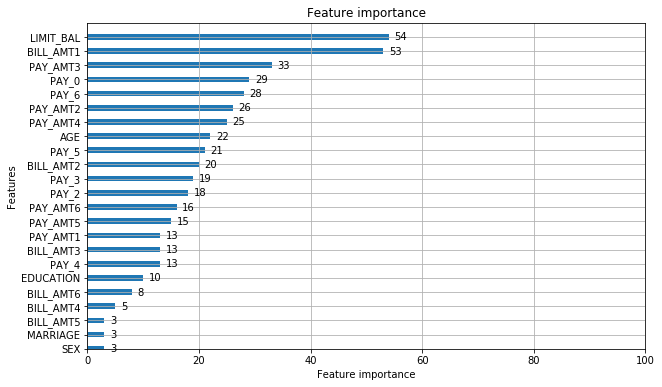

In [195]:
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,100), ylim = (0,23), 
                         figsize = (10,6))
plt.show()


<h2>Dimensionality reduction using feature importances</h2>

In [196]:
# For each feature of our dataset, the result of the following
# code snippet contains numbers of times a feature is used in a model.
sorted(gbm.feature_importances_,reverse=True)

[54,
 53,
 33,
 29,
 28,
 26,
 25,
 22,
 21,
 20,
 19,
 18,
 16,
 15,
 13,
 13,
 13,
 10,
 8,
 5,
 3,
 3,
 3]

In [170]:
# The code below aims to find where at least 85% 
temp = 0 
total = sum(gbm.feature_importances_)
for feature in sorted(gbm.feature_importances_, reverse=True):
    temp+=feature
    if temp/total >= 0.85:
        print(feature,temp/total) # stop when we 
        break

13 0.8711111111111111


In [197]:
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
auc_roc_0=str(metrics.roc_auc_score(y_test, y_pred_prob)) # store AUC score without dimensionality reduction
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC without dimensionality reduction: 
0.7887846326619228


In [198]:
#We can choose to drop the last 6 features from in our new model to reduce dimensionality, and thus save training time and space

X = X.drop(['SEX','BILL_AMT5','MARRIAGE','EDUCATION','BILL_AMT6','BILL_AMT4'], axis=1)

In [199]:
# Remake our test/train set with our reduced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)

reduc_estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}

gridsearch = GridSearchCV(reduc_estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)
print('Best parameters found by grid search are:', gridsearch.best_params_)



[1]	valid_0's binary_logloss: 0.649282	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613403	valid_0's auc: 0.765924
[3]	valid_0's binary_logloss: 0.583443	valid_0's auc: 0.774238
[4]	valid_0's binary_logloss: 0.55847	valid_0's auc: 0.774835
[5]	valid_0's binary_logloss: 0.537354	valid_0's auc: 0.778403
[6]	valid_0's binary_logloss: 0.519972	valid_0's auc: 0.779946
[7]	valid_0's binary_logloss: 0.505101	valid_0's auc: 0.781026
[8]	valid_0's binary_logloss: 0.492389	valid_0's auc: 0.782535
[9]	valid_0's binary_logloss: 0.481669	valid_0's auc: 0.78259
[10]	valid_0's binary_logloss: 0.47242	valid_0's auc: 0.782939
[11]	valid_0's binary_logloss: 0.464488	valid_0's auc: 0.782945
[12]	valid_0's binary_logloss: 0.457969	valid_0's auc: 0.783519
[13]	valid_0's binary_logloss: 0.452156	valid_0's auc: 0.784181
[14]	valid_0's binary_logloss: 0.447314	valid_0's auc: 0.784533
[15]	valid_0's binary_logloss: 0.443119	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[7]	valid_0's binary_logloss: 0.504433	valid_0's auc: 0.775974
[8]	valid_0's binary_logloss: 0.492022	valid_0's auc: 0.777235
[9]	valid_0's binary_logloss: 0.481333	valid_0's auc: 0.777486
[10]	valid_0's binary_logloss: 0.472485	valid_0's auc: 0.777866
[11]	valid_0's binary_logloss: 0.464879	valid_0's auc: 0.778778
[12]	valid_0's binary_logloss: 0.458166	valid_0's auc: 0.780084
[13]	valid_0's binary_logloss: 0.452653	valid_0's auc: 0.779795
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141
[15]	valid_0's binary_logloss: 0.443932	valid_0's auc: 0.78002
[16]	valid_0's binary_logloss: 0.440556	valid_0's auc: 0.779619
[17]	valid_0's binary_logloss: 0.437962	valid_0's auc: 0.778887
[18]	valid_0's binary_logloss: 0.43564	valid_0's auc: 0.778775
[19]	valid_0's binary_logloss: 0.433432	valid_0's auc: 0.778656
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[1]	valid_0's binary_logloss: 0.648093	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.611166	valid_0's auc: 0.780367
[3]	valid_0's binary_logloss: 0.581203	valid_0's auc: 0.780334
[4]	valid_0's binary_logloss: 0.555852	valid_0's auc: 0.781138
[5]	valid_0's binary_logloss: 0.53501	valid_0's auc: 0.783229
[6]	valid_0's binary_logloss: 0.517095	valid_0's auc: 0.785197
[7]	valid_0's binary_logloss: 0.502179	valid_0's auc: 0.784654
[8]	valid_0's binary_logloss: 0.489409	valid_0's auc: 0.785247
[9]	valid_0's binary_logloss: 0.479092	valid_0's auc: 0.785529
[10]	valid_0's binary_logloss: 0.470047	valid_0's auc: 0.784761
[11]	valid_0's binary_logloss: 0.462596	valid_0's auc: 0.784367
[12]	valid_0's binary_logloss: 0.455988	valid_0's auc: 0.784221
[13]	valid_0's binary_logloss: 0.45016	valid_0's auc: 0.785361
[14]	valid_0's binary_logloss: 0.445477	valid_0's auc: 0.786439
[15]	valid_0's binary_logloss: 0.441488	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[8]	valid_0's binary_logloss: 0.492022	valid_0's auc: 0.777235
[9]	valid_0's binary_logloss: 0.481333	valid_0's auc: 0.777486
[10]	valid_0's binary_logloss: 0.472485	valid_0's auc: 0.777866
[11]	valid_0's binary_logloss: 0.464879	valid_0's auc: 0.778778
[12]	valid_0's binary_logloss: 0.458166	valid_0's auc: 0.780084
[13]	valid_0's binary_logloss: 0.452653	valid_0's auc: 0.779795
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141
[15]	valid_0's binary_logloss: 0.443932	valid_0's auc: 0.78002
[16]	valid_0's binary_logloss: 0.440556	valid_0's auc: 0.779619
[17]	valid_0's binary_logloss: 0.437962	valid_0's auc: 0.778887
[18]	valid_0's binary_logloss: 0.43564	valid_0's auc: 0.778775
[19]	valid_0's binary_logloss: 0.433432	valid_0's auc: 0.778656
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141
[1]	valid_0's binary_logloss: 0.648093	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649282	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613403	valid_0's auc: 0.765924
[3]	valid_0's binary_logloss: 0.583443	valid_0's auc: 0.774238
[4]	valid_0's binary_logloss: 0.55847	valid_0's auc: 0.774835
[5]	valid_0's binary_logloss: 0.537354	valid_0's auc: 0.778403
[6]	valid_0's binary_logloss: 0.519972	valid_0's auc: 0.779946
[7]	valid_0's binary_logloss: 0.505101	valid_0's auc: 0.781026
[8]	valid_0's binary_logloss: 0.492389	valid_0's auc: 0.782535
[9]	valid_0's binary_logloss: 0.481669	valid_0's auc: 0.78259
[10]	valid_0's binary_logloss: 0.47242	valid_0's auc: 0.782939
[11]	valid_0's binary_logloss: 0.464488	valid_0's auc: 0.782945
[12]	valid_0's binary_logloss: 0.457969	valid_0's auc: 0.783519
[13]	valid_0's binary_logloss: 0.452156	valid_0's auc: 0.784181
[14]	valid_0's binary_logloss: 0.447314	valid_0's auc: 0.784533
[15]	valid_0's binary_logloss: 0.443119	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	valid_0's binary_logloss: 0.58247	valid_0's auc: 0.77313
[4]	valid_0's binary_logloss: 0.557603	valid_0's auc: 0.773409
[5]	valid_0's binary_logloss: 0.536608	valid_0's auc: 0.775851
[6]	valid_0's binary_logloss: 0.519147	valid_0's auc: 0.775982
[7]	valid_0's binary_logloss: 0.504433	valid_0's auc: 0.775974
[8]	valid_0's binary_logloss: 0.492022	valid_0's auc: 0.777235
[9]	valid_0's binary_logloss: 0.481333	valid_0's auc: 0.777486
[10]	valid_0's binary_logloss: 0.472485	valid_0's auc: 0.777866
[11]	valid_0's binary_logloss: 0.464879	valid_0's auc: 0.778778
[12]	valid_0's binary_logloss: 0.458166	valid_0's auc: 0.780084
[13]	valid_0's binary_logloss: 0.452653	valid_0's auc: 0.779795
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141
[15]	valid_0's binary_logloss: 0.443932	valid_0's auc: 0.78002
[16]	valid_0's binary_logloss: 0.440556	valid_0's auc: 0.779619
[17]	valid_0's binary_logloss: 0.437962	valid_0's auc: 0.778887
[18]	valid_0's binary_logloss: 0.43564	valid_0's a

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648093	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.611166	valid_0's auc: 0.780367
[3]	valid_0's binary_logloss: 0.581203	valid_0's auc: 0.780334
[4]	valid_0's binary_logloss: 0.555852	valid_0's auc: 0.781138
[5]	valid_0's binary_logloss: 0.53501	valid_0's auc: 0.783229
[6]	valid_0's binary_logloss: 0.517095	valid_0's auc: 0.785197
[7]	valid_0's binary_logloss: 0.502179	valid_0's auc: 0.784654
[8]	valid_0's binary_logloss: 0.489409	valid_0's auc: 0.785247
[9]	valid_0's binary_logloss: 0.479092	valid_0's auc: 0.785529
[10]	valid_0's binary_logloss: 0.470047	valid_0's auc: 0.784761
[11]	valid_0's binary_logloss: 0.462596	valid_0's auc: 0.784367
[12]	valid_0's binary_logloss: 0.455988	valid_0's auc: 0.784221
[13]	valid_0's binary_logloss: 0.45016	valid_0's auc: 0.785361
[14]	valid_0's binary_logloss: 0.445477	valid_0's auc: 0.786439
[15]	valid_0's binary_logloss: 0.441488	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[5]	valid_0's binary_logloss: 0.537354	valid_0's auc: 0.778403
[6]	valid_0's binary_logloss: 0.519972	valid_0's auc: 0.779946
[7]	valid_0's binary_logloss: 0.505101	valid_0's auc: 0.781026
[8]	valid_0's binary_logloss: 0.492389	valid_0's auc: 0.782535
[9]	valid_0's binary_logloss: 0.481669	valid_0's auc: 0.78259
[10]	valid_0's binary_logloss: 0.47242	valid_0's auc: 0.782939
[11]	valid_0's binary_logloss: 0.464488	valid_0's auc: 0.782945
[12]	valid_0's binary_logloss: 0.457969	valid_0's auc: 0.783519
[13]	valid_0's binary_logloss: 0.452156	valid_0's auc: 0.784181
[14]	valid_0's binary_logloss: 0.447314	valid_0's auc: 0.784533
[15]	valid_0's binary_logloss: 0.443119	valid_0's auc: 0.784074
[16]	valid_0's binary_logloss: 0.43955	valid_0's auc: 0.784542
[17]	valid_0's binary_logloss: 0.436786	valid_0's auc: 0.784002
[18]	valid_0's binary_logloss: 0.434256	valid_0's auc: 0.784232
[19]	valid_0's binary_logloss: 0.432119	valid_0's auc: 0.784384
[20]	valid_0's binary_logloss: 0.430361	valid_0'

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648756	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.612338	valid_0's auc: 0.770609
[3]	valid_0's binary_logloss: 0.58247	valid_0's auc: 0.77313
[4]	valid_0's binary_logloss: 0.557603	valid_0's auc: 0.773409
[5]	valid_0's binary_logloss: 0.536608	valid_0's auc: 0.775851
[6]	valid_0's binary_logloss: 0.519147	valid_0's auc: 0.775982
[7]	valid_0's binary_logloss: 0.504433	valid_0's auc: 0.775974
[8]	valid_0's binary_logloss: 0.492022	valid_0's auc: 0.777235
[9]	valid_0's binary_logloss: 0.481333	valid_0's auc: 0.777486
[10]	valid_0's binary_logloss: 0.472485	valid_0's auc: 0.777866
[11]	valid_0's binary_logloss: 0.464879	valid_0's auc: 0.778778
[12]	valid_0's binary_logloss: 0.458166	valid_0's auc: 0.780084
[13]	valid_0's binary_logloss: 0.452653	valid_0's auc: 0.779795
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141
[15]	valid_0's binary_logloss: 0.443932	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648093	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.611166	valid_0's auc: 0.780367
[3]	valid_0's binary_logloss: 0.581203	valid_0's auc: 0.780334
[4]	valid_0's binary_logloss: 0.555852	valid_0's auc: 0.781138
[5]	valid_0's binary_logloss: 0.53501	valid_0's auc: 0.783229
[6]	valid_0's binary_logloss: 0.517095	valid_0's auc: 0.785197
[7]	valid_0's binary_logloss: 0.502179	valid_0's auc: 0.784654
[8]	valid_0's binary_logloss: 0.489409	valid_0's auc: 0.785247
[9]	valid_0's binary_logloss: 0.479092	valid_0's auc: 0.785529
[10]	valid_0's binary_logloss: 0.470047	valid_0's auc: 0.784761
[11]	valid_0's binary_logloss: 0.462596	valid_0's auc: 0.784367
[12]	valid_0's binary_logloss: 0.455988	valid_0's auc: 0.784221
[13]	valid_0's binary_logloss: 0.45016	valid_0's auc: 0.785361
[14]	valid_0's binary_logloss: 0.445477	valid_0's auc: 0.786439
[15]	valid_0's binary_logloss: 0.441488	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649282	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613403	valid_0's auc: 0.765924
[3]	valid_0's binary_logloss: 0.583443	valid_0's auc: 0.774238
[4]	valid_0's binary_logloss: 0.55847	valid_0's auc: 0.774835
[5]	valid_0's binary_logloss: 0.537354	valid_0's auc: 0.778403
[6]	valid_0's binary_logloss: 0.519972	valid_0's auc: 0.779946
[7]	valid_0's binary_logloss: 0.505101	valid_0's auc: 0.781026
[8]	valid_0's binary_logloss: 0.492389	valid_0's auc: 0.782535
[9]	valid_0's binary_logloss: 0.481669	valid_0's auc: 0.78259
[10]	valid_0's binary_logloss: 0.47242	valid_0's auc: 0.782939
[11]	valid_0's binary_logloss: 0.464488	valid_0's auc: 0.782945
[12]	valid_0's binary_logloss: 0.457969	valid_0's auc: 0.783519
[13]	valid_0's binary_logloss: 0.452156	valid_0's auc: 0.784181
[14]	valid_0's binary_logloss: 0.447314	valid_0's auc: 0.784533
[15]	valid_0's binary_logloss: 0.443119	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648756	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.612338	valid_0's auc: 0.770609
[3]	valid_0's binary_logloss: 0.58247	valid_0's auc: 0.77313
[4]	valid_0's binary_logloss: 0.557603	valid_0's auc: 0.773409
[5]	valid_0's binary_logloss: 0.536608	valid_0's auc: 0.775851
[6]	valid_0's binary_logloss: 0.519147	valid_0's auc: 0.775982
[7]	valid_0's binary_logloss: 0.504433	valid_0's auc: 0.775974
[8]	valid_0's binary_logloss: 0.492022	valid_0's auc: 0.777235
[9]	valid_0's binary_logloss: 0.481333	valid_0's auc: 0.777486
[10]	valid_0's binary_logloss: 0.472485	valid_0's auc: 0.777866
[11]	valid_0's binary_logloss: 0.464879	valid_0's auc: 0.778778
[12]	valid_0's binary_logloss: 0.458166	valid_0's auc: 0.780084
[13]	valid_0's binary_logloss: 0.452653	valid_0's auc: 0.779795
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141
[15]	valid_0's binary_logloss: 0.443932	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648093	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.611166	valid_0's auc: 0.780367
[3]	valid_0's binary_logloss: 0.581203	valid_0's auc: 0.780334
[4]	valid_0's binary_logloss: 0.555852	valid_0's auc: 0.781138
[5]	valid_0's binary_logloss: 0.53501	valid_0's auc: 0.783229
[6]	valid_0's binary_logloss: 0.517095	valid_0's auc: 0.785197
[7]	valid_0's binary_logloss: 0.502179	valid_0's auc: 0.784654
[8]	valid_0's binary_logloss: 0.489409	valid_0's auc: 0.785247
[9]	valid_0's binary_logloss: 0.479092	valid_0's auc: 0.785529
[10]	valid_0's binary_logloss: 0.470047	valid_0's auc: 0.784761
[11]	valid_0's binary_logloss: 0.462596	valid_0's auc: 0.784367
[12]	valid_0's binary_logloss: 0.455988	valid_0's auc: 0.784221
[13]	valid_0's binary_logloss: 0.45016	valid_0's auc: 0.785361
[14]	valid_0's binary_logloss: 0.445477	valid_0's auc: 0.786439
[15]	valid_0's binary_logloss: 0.441488	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649282	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613403	valid_0's auc: 0.765924
[3]	valid_0's binary_logloss: 0.583443	valid_0's auc: 0.774238
[4]	valid_0's binary_logloss: 0.55847	valid_0's auc: 0.774835
[5]	valid_0's binary_logloss: 0.537354	valid_0's auc: 0.778403
[6]	valid_0's binary_logloss: 0.519972	valid_0's auc: 0.779946
[7]	valid_0's binary_logloss: 0.505101	valid_0's auc: 0.781026
[8]	valid_0's binary_logloss: 0.492389	valid_0's auc: 0.782535
[9]	valid_0's binary_logloss: 0.481669	valid_0's auc: 0.78259
[10]	valid_0's binary_logloss: 0.47242	valid_0's auc: 0.782939
[11]	valid_0's binary_logloss: 0.464488	valid_0's auc: 0.782945
[12]	valid_0's binary_logloss: 0.457969	valid_0's auc: 0.783519
[13]	valid_0's binary_logloss: 0.452156	valid_0's auc: 0.784181
[14]	valid_0's binary_logloss: 0.447314	valid_0's auc: 0.784533
[15]	valid_0's binary_logloss: 0.443119	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648756	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.612338	valid_0's auc: 0.770609
[3]	valid_0's binary_logloss: 0.58247	valid_0's auc: 0.77313
[4]	valid_0's binary_logloss: 0.557603	valid_0's auc: 0.773409
[5]	valid_0's binary_logloss: 0.536608	valid_0's auc: 0.775851
[6]	valid_0's binary_logloss: 0.519147	valid_0's auc: 0.775982
[7]	valid_0's binary_logloss: 0.504433	valid_0's auc: 0.775974
[8]	valid_0's binary_logloss: 0.492022	valid_0's auc: 0.777235
[9]	valid_0's binary_logloss: 0.481333	valid_0's auc: 0.777486
[10]	valid_0's binary_logloss: 0.472485	valid_0's auc: 0.777866
[11]	valid_0's binary_logloss: 0.464879	valid_0's auc: 0.778778
[12]	valid_0's binary_logloss: 0.458166	valid_0's auc: 0.780084
[13]	valid_0's binary_logloss: 0.452653	valid_0's auc: 0.779795
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141
[15]	valid_0's binary_logloss: 0.443932	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648093	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.611166	valid_0's auc: 0.780367
[3]	valid_0's binary_logloss: 0.581203	valid_0's auc: 0.780334
[4]	valid_0's binary_logloss: 0.555852	valid_0's auc: 0.781138
[5]	valid_0's binary_logloss: 0.53501	valid_0's auc: 0.783229
[6]	valid_0's binary_logloss: 0.517095	valid_0's auc: 0.785197
[7]	valid_0's binary_logloss: 0.502179	valid_0's auc: 0.784654
[8]	valid_0's binary_logloss: 0.489409	valid_0's auc: 0.785247
[9]	valid_0's binary_logloss: 0.479092	valid_0's auc: 0.785529
[10]	valid_0's binary_logloss: 0.470047	valid_0's auc: 0.784761
[11]	valid_0's binary_logloss: 0.462596	valid_0's auc: 0.784367
[12]	valid_0's binary_logloss: 0.455988	valid_0's auc: 0.784221
[13]	valid_0's binary_logloss: 0.45016	valid_0's auc: 0.785361
[14]	valid_0's binary_logloss: 0.445477	valid_0's auc: 0.786439
[15]	valid_0's binary_logloss: 0.441488	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649282	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613403	valid_0's auc: 0.765924
[3]	valid_0's binary_logloss: 0.583443	valid_0's auc: 0.774238
[4]	valid_0's binary_logloss: 0.55847	valid_0's auc: 0.774835
[5]	valid_0's binary_logloss: 0.537354	valid_0's auc: 0.778403
[6]	valid_0's binary_logloss: 0.519972	valid_0's auc: 0.779946
[7]	valid_0's binary_logloss: 0.505101	valid_0's auc: 0.781026
[8]	valid_0's binary_logloss: 0.492389	valid_0's auc: 0.782535
[9]	valid_0's binary_logloss: 0.481669	valid_0's auc: 0.78259
[10]	valid_0's binary_logloss: 0.47242	valid_0's auc: 0.782939
[11]	valid_0's binary_logloss: 0.464488	valid_0's auc: 0.782945
[12]	valid_0's binary_logloss: 0.457969	valid_0's auc: 0.783519
[13]	valid_0's binary_logloss: 0.452156	valid_0's auc: 0.784181
[14]	valid_0's binary_logloss: 0.447314	valid_0's auc: 0.784533
[15]	valid_0's binary_logloss: 0.443119	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648756	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.612338	valid_0's auc: 0.770609
[3]	valid_0's binary_logloss: 0.58247	valid_0's auc: 0.77313
[4]	valid_0's binary_logloss: 0.557603	valid_0's auc: 0.773409
[5]	valid_0's binary_logloss: 0.536608	valid_0's auc: 0.775851
[6]	valid_0's binary_logloss: 0.519147	valid_0's auc: 0.775982
[7]	valid_0's binary_logloss: 0.504433	valid_0's auc: 0.775974
[8]	valid_0's binary_logloss: 0.492022	valid_0's auc: 0.777235
[9]	valid_0's binary_logloss: 0.481333	valid_0's auc: 0.777486
[10]	valid_0's binary_logloss: 0.472485	valid_0's auc: 0.777866
[11]	valid_0's binary_logloss: 0.464879	valid_0's auc: 0.778778
[12]	valid_0's binary_logloss: 0.458166	valid_0's auc: 0.780084
[13]	valid_0's binary_logloss: 0.452653	valid_0's auc: 0.779795
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141
[15]	valid_0's binary_logloss: 0.443932	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648093	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.611166	valid_0's auc: 0.780367
[3]	valid_0's binary_logloss: 0.581203	valid_0's auc: 0.780334
[4]	valid_0's binary_logloss: 0.555852	valid_0's auc: 0.781138
[5]	valid_0's binary_logloss: 0.53501	valid_0's auc: 0.783229
[6]	valid_0's binary_logloss: 0.517095	valid_0's auc: 0.785197
[7]	valid_0's binary_logloss: 0.502179	valid_0's auc: 0.784654
[8]	valid_0's binary_logloss: 0.489409	valid_0's auc: 0.785247
[9]	valid_0's binary_logloss: 0.479092	valid_0's auc: 0.785529
[10]	valid_0's binary_logloss: 0.470047	valid_0's auc: 0.784761
[11]	valid_0's binary_logloss: 0.462596	valid_0's auc: 0.784367
[12]	valid_0's binary_logloss: 0.455988	valid_0's auc: 0.784221
[13]	valid_0's binary_logloss: 0.45016	valid_0's auc: 0.785361
[14]	valid_0's binary_logloss: 0.445477	valid_0's auc: 0.786439
[15]	valid_0's binary_logloss: 0.441488	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.649282	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.613403	valid_0's auc: 0.765924
[3]	valid_0's binary_logloss: 0.583443	valid_0's auc: 0.774238
[4]	valid_0's binary_logloss: 0.55847	valid_0's auc: 0.774835
[5]	valid_0's binary_logloss: 0.537354	valid_0's auc: 0.778403
[6]	valid_0's binary_logloss: 0.519972	valid_0's auc: 0.779946
[7]	valid_0's binary_logloss: 0.505101	valid_0's auc: 0.781026
[8]	valid_0's binary_logloss: 0.492389	valid_0's auc: 0.782535
[9]	valid_0's binary_logloss: 0.481669	valid_0's auc: 0.78259
[10]	valid_0's binary_logloss: 0.47242	valid_0's auc: 0.782939
[11]	valid_0's binary_logloss: 0.464488	valid_0's auc: 0.782945
[12]	valid_0's binary_logloss: 0.457969	valid_0's auc: 0.783519
[13]	valid_0's binary_logloss: 0.452156	valid_0's auc: 0.784181
[14]	valid_0's binary_logloss: 0.447314	valid_0's auc: 0.784533
[15]	valid_0's binary_logloss: 0.443119	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648756	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.612338	valid_0's auc: 0.770609
[3]	valid_0's binary_logloss: 0.58247	valid_0's auc: 0.77313
[4]	valid_0's binary_logloss: 0.557603	valid_0's auc: 0.773409
[5]	valid_0's binary_logloss: 0.536608	valid_0's auc: 0.775851
[6]	valid_0's binary_logloss: 0.519147	valid_0's auc: 0.775982
[7]	valid_0's binary_logloss: 0.504433	valid_0's auc: 0.775974
[8]	valid_0's binary_logloss: 0.492022	valid_0's auc: 0.777235
[9]	valid_0's binary_logloss: 0.481333	valid_0's auc: 0.777486
[10]	valid_0's binary_logloss: 0.472485	valid_0's auc: 0.777866
[11]	valid_0's binary_logloss: 0.464879	valid_0's auc: 0.778778
[12]	valid_0's binary_logloss: 0.458166	valid_0's auc: 0.780084
[13]	valid_0's binary_logloss: 0.452653	valid_0's auc: 0.779795
[14]	valid_0's binary_logloss: 0.447962	valid_0's auc: 0.780141
[15]	valid_0's binary_logloss: 0.443932	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.648093	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.611166	valid_0's auc: 0.780367
[3]	valid_0's binary_logloss: 0.581203	valid_0's auc: 0.780334
[4]	valid_0's binary_logloss: 0.555852	valid_0's auc: 0.781138
[5]	valid_0's binary_logloss: 0.53501	valid_0's auc: 0.783229
[6]	valid_0's binary_logloss: 0.517095	valid_0's auc: 0.785197
[7]	valid_0's binary_logloss: 0.502179	valid_0's auc: 0.784654
[8]	valid_0's binary_logloss: 0.489409	valid_0's auc: 0.785247
[9]	valid_0's binary_logloss: 0.479092	valid_0's auc: 0.785529
[10]	valid_0's binary_logloss: 0.470047	valid_0's auc: 0.784761
[11]	valid_0's binary_logloss: 0.462596	valid_0's auc: 0.784367
[12]	valid_0's binary_logloss: 0.455988	valid_0's auc: 0.784221
[13]	valid_0's binary_logloss: 0.45016	valid_0's auc: 0.785361
[14]	valid_0's binary_logloss: 0.445477	valid_0's auc: 0.786439
[15]	valid_0's binary_logloss: 0.441488	valid_0's auc:

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639039	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.59686	valid_0's auc: 0.768559
[3]	valid_0's binary_logloss: 0.563046	valid_0's auc: 0.774609
[4]	valid_0's binary_logloss: 0.536565	valid_0's auc: 0.775673
[5]	valid_0's binary_logloss: 0.515193	valid_0's auc: 0.778986
[6]	valid_0's binary_logloss: 0.497487	valid_0's auc: 0.781243
[7]	valid_0's binary_logloss: 0.483241	valid_0's auc: 0.782222
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[9]	valid_0's binary_logloss: 0.461891	valid_0's auc: 0.7831
[10]	valid_0's binary_logloss: 0.454201	valid_0's auc: 0.783219
[11]	valid_0's binary_logloss: 0.447828	valid_0's auc: 0.781744
[12]	valid_0's binary_logloss: 0.442523	valid_0's auc: 0.781555
[13]	valid_0's binary_logloss: 0.43782	valid_0's auc: 0.78333
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[1]	valid_0's binary_logl

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[5]	valid_0's binary_logloss: 0.514336	valid_0's auc: 0.775344
[6]	valid_0's binary_logloss: 0.497051	valid_0's auc: 0.775706
[7]	valid_0's binary_logloss: 0.483065	valid_0's auc: 0.778363
[8]	valid_0's binary_logloss: 0.471946	valid_0's auc: 0.77852
[9]	valid_0's binary_logloss: 0.462622	valid_0's auc: 0.779467
[10]	valid_0's binary_logloss: 0.454926	valid_0's auc: 0.780503
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[12]	valid_0's binary_logloss: 0.443656	valid_0's auc: 0.780446
[13]	valid_0's binary_logloss: 0.439553	valid_0's auc: 0.780412
[14]	valid_0's binary_logloss: 0.436174	valid_0's auc: 0.780377
[15]	valid_0's binary_logloss: 0.433667	valid_0's auc: 0.779542
[16]	valid_0's binary_logloss: 0.431555	valid_0's auc: 0.779938
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.637583	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.594331	valid_0's auc: 0.778977
[3]	valid_0's binary_logloss: 0.560818	valid_0's auc: 0.7802
[4]	valid_0's binary_logloss: 0.534058	valid_0's auc: 0.778556
[5]	valid_0's binary_logloss: 0.512695	valid_0's auc: 0.782507
[6]	valid_0's binary_logloss: 0.494914	valid_0's auc: 0.78475
[7]	valid_0's binary_logloss: 0.480635	valid_0's auc: 0.784875
[8]	valid_0's binary_logloss: 0.469122	valid_0's auc: 0.784435
[9]	valid_0's binary_logloss: 0.459882	valid_0's auc: 0.784389
[10]	valid_0's binary_logloss: 0.452365	valid_0's auc: 0.78413
[11]	valid_0's binary_logloss: 0.44627	valid_0's auc: 0.784544
[12]	valid_0's binary_logloss: 0.44115	valid_0's auc: 0.78533
[13]	valid_0's binary_logloss: 0.437338	valid_0's auc: 0.784468
[14]	valid_0's binary_logloss: 0.433756	valid_0's auc: 0.784846
[15]	valid_0's binary_logloss: 0.431157	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639039	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.59686	valid_0's auc: 0.768559
[3]	valid_0's binary_logloss: 0.563046	valid_0's auc: 0.774609
[4]	valid_0's binary_logloss: 0.536565	valid_0's auc: 0.775673
[5]	valid_0's binary_logloss: 0.515193	valid_0's auc: 0.778986
[6]	valid_0's binary_logloss: 0.497487	valid_0's auc: 0.781243
[7]	valid_0's binary_logloss: 0.483241	valid_0's auc: 0.782222
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[9]	valid_0's binary_logloss: 0.461891	valid_0's auc: 0.7831
[10]	valid_0's binary_logloss: 0.454201	valid_0's auc: 0.783219
[11]	valid_0's binary_logloss: 0.447828	valid_0's auc: 0.781744
[12]	valid_0's binary_logloss: 0.442523	valid_0's auc: 0.781555
[13]	valid_0's binary_logloss: 0.43782	valid_0's auc: 0.78333
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.638399	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.595651	valid_0's auc: 0.770585
[3]	valid_0's binary_logloss: 0.562349	valid_0's auc: 0.772544
[4]	valid_0's binary_logloss: 0.535815	valid_0's auc: 0.775212
[5]	valid_0's binary_logloss: 0.514336	valid_0's auc: 0.775344
[6]	valid_0's binary_logloss: 0.497051	valid_0's auc: 0.775706
[7]	valid_0's binary_logloss: 0.483065	valid_0's auc: 0.778363
[8]	valid_0's binary_logloss: 0.471946	valid_0's auc: 0.77852
[9]	valid_0's binary_logloss: 0.462622	valid_0's auc: 0.779467
[10]	valid_0's binary_logloss: 0.454926	valid_0's auc: 0.780503
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[12]	valid_0's binary_logloss: 0.443656	valid_0's auc: 0.780446
[13]	valid_0's binary_logloss: 0.439553	valid_0's auc: 0.780412
[14]	valid_0's binary_logloss: 0.436174	valid_0's auc: 0.780377
[15]	valid_0's binary_logloss: 0.433667	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	valid_0's binary_logloss: 0.437338	valid_0's auc: 0.784468
[14]	valid_0's binary_logloss: 0.433756	valid_0's auc: 0.784846
[15]	valid_0's binary_logloss: 0.431157	valid_0's auc: 0.783672
[16]	valid_0's binary_logloss: 0.428938	valid_0's auc: 0.784069
[17]	valid_0's binary_logloss: 0.426887	valid_0's auc: 0.785093
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.44115	valid_0's auc: 0.78533
[1]	valid_0's binary_logloss: 0.639039	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.59686	valid_0's auc: 0.768559
[3]	valid_0's binary_logloss: 0.563046	valid_0's auc: 0.774609
[4]	valid_0's binary_logloss: 0.536565	valid_0's auc: 0.775673
[5]	valid_0's binary_logloss: 0.515193	valid_0's auc: 0.778986


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[6]	valid_0's binary_logloss: 0.497487	valid_0's auc: 0.781243
[7]	valid_0's binary_logloss: 0.483241	valid_0's auc: 0.782222
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[9]	valid_0's binary_logloss: 0.461891	valid_0's auc: 0.7831
[10]	valid_0's binary_logloss: 0.454201	valid_0's auc: 0.783219
[11]	valid_0's binary_logloss: 0.447828	valid_0's auc: 0.781744
[12]	valid_0's binary_logloss: 0.442523	valid_0's auc: 0.781555
[13]	valid_0's binary_logloss: 0.43782	valid_0's auc: 0.78333
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[1]	valid_0's binary_logloss: 0.638399	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.595651	valid_0's auc: 0.770585
[3]	valid_0's binary_logloss: 0.562349	valid_0's auc: 0.772544
[4]	valid_0's binary_logloss: 0.535815	valid_0's auc: 0.775212
[5]	valid_0's binary_logloss: 0.514336	valid_0's auc: 0.775344
[6]	valid_0's binary_log

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[9]	valid_0's binary_logloss: 0.462622	valid_0's auc: 0.779467
[10]	valid_0's binary_logloss: 0.454926	valid_0's auc: 0.780503
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[12]	valid_0's binary_logloss: 0.443656	valid_0's auc: 0.780446
[13]	valid_0's binary_logloss: 0.439553	valid_0's auc: 0.780412
[14]	valid_0's binary_logloss: 0.436174	valid_0's auc: 0.780377
[15]	valid_0's binary_logloss: 0.433667	valid_0's auc: 0.779542
[16]	valid_0's binary_logloss: 0.431555	valid_0's auc: 0.779938
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[1]	valid_0's binary_logloss: 0.637583	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.594331	valid_0's auc: 0.778977
[3]	valid_0's binary_logloss: 0.560818	valid_0's auc: 0.7802
[4]	valid_0's binary_logloss: 0.534058	valid_0's auc: 0.778556
[5]	valid_0's binary_logloss: 0.512695	valid_0's auc: 0.782507
[6]	valid_0's bi

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[9]	valid_0's binary_logloss: 0.461891	valid_0's auc: 0.7831
[10]	valid_0's binary_logloss: 0.454201	valid_0's auc: 0.783219
[11]	valid_0's binary_logloss: 0.447828	valid_0's auc: 0.781744
[12]	valid_0's binary_logloss: 0.442523	valid_0's auc: 0.781555
[13]	valid_0's binary_logloss: 0.43782	valid_0's auc: 0.78333
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[1]	valid_0's binary_logloss: 0.638399	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.595651	valid_0's auc: 0.770585
[3]	valid_0's binary_logloss: 0.562349	valid_0's auc: 0.772544
[4]	valid_0's binary_logloss: 0.535815	valid_0's auc: 0.775212
[5]	valid_0's binary_logloss: 0.514336	valid_0's auc: 0.775344
[6]	valid_0's binary_logloss: 0.497051	valid_0's auc: 0.775706
[7]	valid_0's binary_logloss: 0.483065	valid_0's auc: 0.778363
[8]	valid_0's binary_logloss: 0.471946	valid_0's auc: 0.77852
[9]	valid_0's binary_log

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[10]	valid_0's binary_logloss: 0.454926	valid_0's auc: 0.780503
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[12]	valid_0's binary_logloss: 0.443656	valid_0's auc: 0.780446
[13]	valid_0's binary_logloss: 0.439553	valid_0's auc: 0.780412
[14]	valid_0's binary_logloss: 0.436174	valid_0's auc: 0.780377
[15]	valid_0's binary_logloss: 0.433667	valid_0's auc: 0.779542
[16]	valid_0's binary_logloss: 0.431555	valid_0's auc: 0.779938
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[1]	valid_0's binary_logloss: 0.637583	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.594331	valid_0's auc: 0.778977
[3]	valid_0's binary_logloss: 0.560818	valid_0's auc: 0.7802


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[4]	valid_0's binary_logloss: 0.534058	valid_0's auc: 0.778556
[5]	valid_0's binary_logloss: 0.512695	valid_0's auc: 0.782507
[6]	valid_0's binary_logloss: 0.494914	valid_0's auc: 0.78475
[7]	valid_0's binary_logloss: 0.480635	valid_0's auc: 0.784875
[8]	valid_0's binary_logloss: 0.469122	valid_0's auc: 0.784435
[9]	valid_0's binary_logloss: 0.459882	valid_0's auc: 0.784389
[10]	valid_0's binary_logloss: 0.452365	valid_0's auc: 0.78413
[11]	valid_0's binary_logloss: 0.44627	valid_0's auc: 0.784544
[12]	valid_0's binary_logloss: 0.44115	valid_0's auc: 0.78533
[13]	valid_0's binary_logloss: 0.437338	valid_0's auc: 0.784468
[14]	valid_0's binary_logloss: 0.433756	valid_0's auc: 0.784846
[15]	valid_0's binary_logloss: 0.431157	valid_0's auc: 0.783672
[16]	valid_0's binary_logloss: 0.428938	valid_0's auc: 0.784069
[17]	valid_0's binary_logloss: 0.426887	valid_0's auc: 0.785093
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.44115	valid_0's auc: 0.78533


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.639039	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.59686	valid_0's auc: 0.768559
[3]	valid_0's binary_logloss: 0.563046	valid_0's auc: 0.774609
[4]	valid_0's binary_logloss: 0.536565	valid_0's auc: 0.775673
[5]	valid_0's binary_logloss: 0.515193	valid_0's auc: 0.778986
[6]	valid_0's binary_logloss: 0.497487	valid_0's auc: 0.781243
[7]	valid_0's binary_logloss: 0.483241	valid_0's auc: 0.782222
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[9]	valid_0's binary_logloss: 0.461891	valid_0's auc: 0.7831
[10]	valid_0's binary_logloss: 0.454201	valid_0's auc: 0.783219
[11]	valid_0's binary_logloss: 0.447828	valid_0's auc: 0.781744
[12]	valid_0's binary_logloss: 0.442523	valid_0's auc: 0.781555
[13]	valid_0's binary_logloss: 0.43782	valid_0's auc: 0.78333
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[1]	valid_0's binary_logl

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[5]	valid_0's binary_logloss: 0.514336	valid_0's auc: 0.775344
[6]	valid_0's binary_logloss: 0.497051	valid_0's auc: 0.775706
[7]	valid_0's binary_logloss: 0.483065	valid_0's auc: 0.778363
[8]	valid_0's binary_logloss: 0.471946	valid_0's auc: 0.77852
[9]	valid_0's binary_logloss: 0.462622	valid_0's auc: 0.779467
[10]	valid_0's binary_logloss: 0.454926	valid_0's auc: 0.780503
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[12]	valid_0's binary_logloss: 0.443656	valid_0's auc: 0.780446
[13]	valid_0's binary_logloss: 0.439553	valid_0's auc: 0.780412
[14]	valid_0's binary_logloss: 0.436174	valid_0's auc: 0.780377
[15]	valid_0's binary_logloss: 0.433667	valid_0's auc: 0.779542
[16]	valid_0's binary_logloss: 0.431555	valid_0's auc: 0.779938
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[1]	valid_0's binary_logloss: 0.637583	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's b

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[4]	valid_0's binary_logloss: 0.536565	valid_0's auc: 0.775673
[5]	valid_0's binary_logloss: 0.515193	valid_0's auc: 0.778986
[6]	valid_0's binary_logloss: 0.497487	valid_0's auc: 0.781243
[7]	valid_0's binary_logloss: 0.483241	valid_0's auc: 0.782222
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[9]	valid_0's binary_logloss: 0.461891	valid_0's auc: 0.7831
[10]	valid_0's binary_logloss: 0.454201	valid_0's auc: 0.783219
[11]	valid_0's binary_logloss: 0.447828	valid_0's auc: 0.781744
[12]	valid_0's binary_logloss: 0.442523	valid_0's auc: 0.781555
[13]	valid_0's binary_logloss: 0.43782	valid_0's auc: 0.78333
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[1]	valid_0's binary_logloss: 0.638399	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.595651	valid_0's auc: 0.770585
[3]	valid_0's binary_logloss: 0.562349	valid_0's auc: 0.772544
[4]	valid_0's binary_lo

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[8]	valid_0's binary_logloss: 0.471946	valid_0's auc: 0.77852
[9]	valid_0's binary_logloss: 0.462622	valid_0's auc: 0.779467
[10]	valid_0's binary_logloss: 0.454926	valid_0's auc: 0.780503
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[12]	valid_0's binary_logloss: 0.443656	valid_0's auc: 0.780446
[13]	valid_0's binary_logloss: 0.439553	valid_0's auc: 0.780412
[14]	valid_0's binary_logloss: 0.436174	valid_0's auc: 0.780377
[15]	valid_0's binary_logloss: 0.433667	valid_0's auc: 0.779542
[16]	valid_0's binary_logloss: 0.431555	valid_0's auc: 0.779938
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[1]	valid_0's binary_logloss: 0.637583	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.594331	valid_0's auc: 0.778977
[3]	valid_0's binary_logloss: 0.560818	valid_0's auc: 0.7802
[4]	valid_0's binary_logloss: 0.534058	valid_0's auc: 0.778556
[5]	valid_0's bin

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[7]	valid_0's binary_logloss: 0.480635	valid_0's auc: 0.784875
[8]	valid_0's binary_logloss: 0.469122	valid_0's auc: 0.784435
[9]	valid_0's binary_logloss: 0.459882	valid_0's auc: 0.784389
[10]	valid_0's binary_logloss: 0.452365	valid_0's auc: 0.78413
[11]	valid_0's binary_logloss: 0.44627	valid_0's auc: 0.784544
[12]	valid_0's binary_logloss: 0.44115	valid_0's auc: 0.78533
[13]	valid_0's binary_logloss: 0.437338	valid_0's auc: 0.784468
[14]	valid_0's binary_logloss: 0.433756	valid_0's auc: 0.784846
[15]	valid_0's binary_logloss: 0.431157	valid_0's auc: 0.783672
[16]	valid_0's binary_logloss: 0.428938	valid_0's auc: 0.784069
[17]	valid_0's binary_logloss: 0.426887	valid_0's auc: 0.785093
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.44115	valid_0's auc: 0.78533
[1]	valid_0's binary_logloss: 0.639039	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.59686	valid_0's auc: 0.768559
[3]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[13]	valid_0's binary_logloss: 0.439553	valid_0's auc: 0.780412
[14]	valid_0's binary_logloss: 0.436174	valid_0's auc: 0.780377
[15]	valid_0's binary_logloss: 0.433667	valid_0's auc: 0.779542
[16]	valid_0's binary_logloss: 0.431555	valid_0's auc: 0.779938
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[1]	valid_0's binary_logloss: 0.637583	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.594331	valid_0's auc: 0.778977
[3]	valid_0's binary_logloss: 0.560818	valid_0's auc: 0.7802
[4]	valid_0's binary_logloss: 0.534058	valid_0's auc: 0.778556
[5]	valid_0's binary_logloss: 0.512695	valid_0's auc: 0.782507
[6]	valid_0's binary_logloss: 0.494914	valid_0's auc: 0.78475
[7]	valid_0's binary_logloss: 0.480635	valid_0's auc: 0.784875
[8]	valid_0's binary_logloss: 0.469122	valid_0's auc: 0.784435
[9]	valid_0's binary_logloss: 0.459882	valid_0's auc: 0.784389
[10]	valid_0's binar

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	valid_0's binary_logloss: 0.428938	valid_0's auc: 0.784069
[17]	valid_0's binary_logloss: 0.426887	valid_0's auc: 0.785093
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.44115	valid_0's auc: 0.78533
[1]	valid_0's binary_logloss: 0.639039	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.59686	valid_0's auc: 0.768559
[3]	valid_0's binary_logloss: 0.563046	valid_0's auc: 0.774609
[4]	valid_0's binary_logloss: 0.536565	valid_0's auc: 0.775673
[5]	valid_0's binary_logloss: 0.515193	valid_0's auc: 0.778986
[6]	valid_0's binary_logloss: 0.497487	valid_0's auc: 0.781243
[7]	valid_0's binary_logloss: 0.483241	valid_0's auc: 0.782222
[8]	valid_0's binary_logloss: 0.47156	valid_0's auc: 0.783556
[9]	valid_0's binary_logloss: 0.461891	valid_0's auc: 0.7831
[10]	valid_0's binary_logloss: 0.454201	valid_0's auc: 0.783219
[11]	valid_0's binary_logloss: 0.447828	valid_0's auc: 0.781744
[12]	valid_0's binary_l

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.638399	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.595651	valid_0's auc: 0.770585
[3]	valid_0's binary_logloss: 0.562349	valid_0's auc: 0.772544
[4]	valid_0's binary_logloss: 0.535815	valid_0's auc: 0.775212
[5]	valid_0's binary_logloss: 0.514336	valid_0's auc: 0.775344
[6]	valid_0's binary_logloss: 0.497051	valid_0's auc: 0.775706
[7]	valid_0's binary_logloss: 0.483065	valid_0's auc: 0.778363
[8]	valid_0's binary_logloss: 0.471946	valid_0's auc: 0.77852
[9]	valid_0's binary_logloss: 0.462622	valid_0's auc: 0.779467
[10]	valid_0's binary_logloss: 0.454926	valid_0's auc: 0.780503
[11]	valid_0's binary_logloss: 0.448726	valid_0's auc: 0.780765
[12]	valid_0's binary_logloss: 0.443656	valid_0's auc: 0.780446
[13]	valid_0's binary_logloss: 0.439553	valid_0's auc: 0.780412
[14]	valid_0's binary_logloss: 0.436174	valid_0's auc: 0.780377
[15]	valid_0's binary_logloss: 0.433667	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.637583	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.594331	valid_0's auc: 0.778977
[3]	valid_0's binary_logloss: 0.560818	valid_0's auc: 0.7802
[4]	valid_0's binary_logloss: 0.534058	valid_0's auc: 0.778556
[5]	valid_0's binary_logloss: 0.512695	valid_0's auc: 0.782507
[6]	valid_0's binary_logloss: 0.494914	valid_0's auc: 0.78475
[7]	valid_0's binary_logloss: 0.480635	valid_0's auc: 0.784875
[8]	valid_0's binary_logloss: 0.469122	valid_0's auc: 0.784435
[9]	valid_0's binary_logloss: 0.459882	valid_0's auc: 0.784389
[10]	valid_0's binary_logloss: 0.452365	valid_0's auc: 0.78413
[11]	valid_0's binary_logloss: 0.44627	valid_0's auc: 0.784544
[12]	valid_0's binary_logloss: 0.44115	valid_0's auc: 0.78533
[13]	valid_0's binary_logloss: 0.437338	valid_0's auc: 0.784468
[14]	valid_0's binary_logloss: 0.433756	valid_0's auc: 0.784846
[15]	valid_0's binary_logloss: 0.431157	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	valid_0's binary_logloss: 0.581858	valid_0's auc: 0.768647
[3]	valid_0's binary_logloss: 0.545933	valid_0's auc: 0.773709
[4]	valid_0's binary_logloss: 0.518298	valid_0's auc: 0.778296
[5]	valid_0's binary_logloss: 0.497007	valid_0's auc: 0.779769
[6]	valid_0's binary_logloss: 0.480673	valid_0's auc: 0.780032
[7]	valid_0's binary_logloss: 0.467553	valid_0's auc: 0.779888
[8]	valid_0's binary_logloss: 0.45746	valid_0's auc: 0.779863
[9]	valid_0's binary_logloss: 0.449612	valid_0's auc: 0.778896
[10]	valid_0's binary_logloss: 0.443368	valid_0's auc: 0.780249
[11]	valid_0's binary_logloss: 0.438019	valid_0's auc: 0.781782
[12]	valid_0's binary_logloss: 0.434744	valid_0's auc: 0.781306
[13]	valid_0's binary_logloss: 0.432013	valid_0's auc: 0.780758
[14]	valid_0's binary_logloss: 0.430353	valid_0's auc: 0.778956
[15]	valid_0's binary_logloss: 0.428047	valid_0's auc: 0.780046
[16]	valid_0's binary_logloss: 0.426662	valid_0's auc: 0.780339
Early stopping, best iteration is:
[11]	valid_0's

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.628337	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.580359	valid_0's auc: 0.771588
[3]	valid_0's binary_logloss: 0.544475	valid_0's auc: 0.773468
[4]	valid_0's binary_logloss: 0.517192	valid_0's auc: 0.773302
[5]	valid_0's binary_logloss: 0.496131	valid_0's auc: 0.773896
[6]	valid_0's binary_logloss: 0.479577	valid_0's auc: 0.777867
[7]	valid_0's binary_logloss: 0.466894	valid_0's auc: 0.77794
[8]	valid_0's binary_logloss: 0.457311	valid_0's auc: 0.77694
[9]	valid_0's binary_logloss: 0.449114	valid_0's auc: 0.77883
[10]	valid_0's binary_logloss: 0.443632	valid_0's auc: 0.777447
[11]	valid_0's binary_logloss: 0.438839	valid_0's auc: 0.777773
[12]	valid_0's binary_logloss: 0.435373	valid_0's auc: 0.778706
[13]	valid_0's binary_logloss: 0.43181	valid_0's auc: 0.780778
[14]	valid_0's binary_logloss: 0.42952	valid_0's auc: 0.78061
[15]	valid_0's binary_logloss: 0.42737	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.627371	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.578732	valid_0's auc: 0.777685
[3]	valid_0's binary_logloss: 0.54281	valid_0's auc: 0.778983
[4]	valid_0's binary_logloss: 0.515098	valid_0's auc: 0.778783
[5]	valid_0's binary_logloss: 0.49354	valid_0's auc: 0.781774
[6]	valid_0's binary_logloss: 0.477028	valid_0's auc: 0.782931
[7]	valid_0's binary_logloss: 0.464457	valid_0's auc: 0.782826
[8]	valid_0's binary_logloss: 0.454808	valid_0's auc: 0.782263
[9]	valid_0's binary_logloss: 0.446424	valid_0's auc: 0.785066
[10]	valid_0's binary_logloss: 0.440409	valid_0's auc: 0.785007
[11]	valid_0's binary_logloss: 0.435471	valid_0's auc: 0.784922
[12]	valid_0's binary_logloss: 0.431611	valid_0's auc: 0.78587
[13]	valid_0's binary_logloss: 0.428454	valid_0's auc: 0.787371
[14]	valid_0's binary_logloss: 0.426101	valid_0's auc: 0.787155
[15]	valid_0's binary_logloss: 0.424086	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629082	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.581858	valid_0's auc: 0.768647
[3]	valid_0's binary_logloss: 0.545933	valid_0's auc: 0.773709
[4]	valid_0's binary_logloss: 0.518298	valid_0's auc: 0.778296
[5]	valid_0's binary_logloss: 0.497007	valid_0's auc: 0.779769
[6]	valid_0's binary_logloss: 0.480673	valid_0's auc: 0.780032
[7]	valid_0's binary_logloss: 0.467553	valid_0's auc: 0.779888
[8]	valid_0's binary_logloss: 0.45746	valid_0's auc: 0.779863
[9]	valid_0's binary_logloss: 0.449612	valid_0's auc: 0.778896
[10]	valid_0's binary_logloss: 0.443368	valid_0's auc: 0.780249
[11]	valid_0's binary_logloss: 0.438019	valid_0's auc: 0.781782
[12]	valid_0's binary_logloss: 0.434744	valid_0's auc: 0.781306
[13]	valid_0's binary_logloss: 0.432013	valid_0's auc: 0.780758
[14]	valid_0's binary_logloss: 0.430353	valid_0's auc: 0.778956
[15]	valid_0's binary_logloss: 0.428047	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.628337	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.580359	valid_0's auc: 0.771588
[3]	valid_0's binary_logloss: 0.544475	valid_0's auc: 0.773468
[4]	valid_0's binary_logloss: 0.517192	valid_0's auc: 0.773302
[5]	valid_0's binary_logloss: 0.496131	valid_0's auc: 0.773896
[6]	valid_0's binary_logloss: 0.479577	valid_0's auc: 0.777867
[7]	valid_0's binary_logloss: 0.466894	valid_0's auc: 0.77794
[8]	valid_0's binary_logloss: 0.457311	valid_0's auc: 0.77694
[9]	valid_0's binary_logloss: 0.449114	valid_0's auc: 0.77883
[10]	valid_0's binary_logloss: 0.443632	valid_0's auc: 0.777447
[11]	valid_0's binary_logloss: 0.438839	valid_0's auc: 0.777773
[12]	valid_0's binary_logloss: 0.435373	valid_0's auc: 0.778706
[13]	valid_0's binary_logloss: 0.43181	valid_0's auc: 0.780778
[14]	valid_0's binary_logloss: 0.42952	valid_0's auc: 0.78061
[15]	valid_0's binary_logloss: 0.42737	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.627371	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.578732	valid_0's auc: 0.777685
[3]	valid_0's binary_logloss: 0.54281	valid_0's auc: 0.778983
[4]	valid_0's binary_logloss: 0.515098	valid_0's auc: 0.778783
[5]	valid_0's binary_logloss: 0.49354	valid_0's auc: 0.781774
[6]	valid_0's binary_logloss: 0.477028	valid_0's auc: 0.782931
[7]	valid_0's binary_logloss: 0.464457	valid_0's auc: 0.782826
[8]	valid_0's binary_logloss: 0.454808	valid_0's auc: 0.782263
[9]	valid_0's binary_logloss: 0.446424	valid_0's auc: 0.785066
[10]	valid_0's binary_logloss: 0.440409	valid_0's auc: 0.785007
[11]	valid_0's binary_logloss: 0.435471	valid_0's auc: 0.784922
[12]	valid_0's binary_logloss: 0.431611	valid_0's auc: 0.78587
[13]	valid_0's binary_logloss: 0.428454	valid_0's auc: 0.787371
[14]	valid_0's binary_logloss: 0.426101	valid_0's auc: 0.787155
[15]	valid_0's binary_logloss: 0.424086	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629082	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.581858	valid_0's auc: 0.768647
[3]	valid_0's binary_logloss: 0.545933	valid_0's auc: 0.773709
[4]	valid_0's binary_logloss: 0.518298	valid_0's auc: 0.778296
[5]	valid_0's binary_logloss: 0.497007	valid_0's auc: 0.779769
[6]	valid_0's binary_logloss: 0.480673	valid_0's auc: 0.780032
[7]	valid_0's binary_logloss: 0.467553	valid_0's auc: 0.779888
[8]	valid_0's binary_logloss: 0.45746	valid_0's auc: 0.779863
[9]	valid_0's binary_logloss: 0.449612	valid_0's auc: 0.778896
[10]	valid_0's binary_logloss: 0.443368	valid_0's auc: 0.780249
[11]	valid_0's binary_logloss: 0.438019	valid_0's auc: 0.781782
[12]	valid_0's binary_logloss: 0.434744	valid_0's auc: 0.781306
[13]	valid_0's binary_logloss: 0.432013	valid_0's auc: 0.780758
[14]	valid_0's binary_logloss: 0.430353	valid_0's auc: 0.778956
[15]	valid_0's binary_logloss: 0.428047	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.580359	valid_0's auc: 0.771588
[3]	valid_0's binary_logloss: 0.544475	valid_0's auc: 0.773468
[4]	valid_0's binary_logloss: 0.517192	valid_0's auc: 0.773302
[5]	valid_0's binary_logloss: 0.496131	valid_0's auc: 0.773896
[6]	valid_0's binary_logloss: 0.479577	valid_0's auc: 0.777867
[7]	valid_0's binary_logloss: 0.466894	valid_0's auc: 0.77794
[8]	valid_0's binary_logloss: 0.457311	valid_0's auc: 0.77694
[9]	valid_0's binary_logloss: 0.449114	valid_0's auc: 0.77883
[10]	valid_0's binary_logloss: 0.443632	valid_0's auc: 0.777447
[11]	valid_0's binary_logloss: 0.438839	valid_0's auc: 0.777773
[12]	valid_0's binary_logloss: 0.435373	valid_0's auc: 0.778706
[13]	valid_0's binary_logloss: 0.43181	valid_0's auc: 0.780778
[14]	valid_0's binary_logloss: 0.42952	valid_0's auc: 0.78061
[15]	valid_0's binary_logloss: 0.42737	valid_0's auc: 0.782448
[16]	valid_0's binary_logloss: 0.425953	valid_0's auc: 0.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.627371	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.578732	valid_0's auc: 0.777685
[3]	valid_0's binary_logloss: 0.54281	valid_0's auc: 0.778983
[4]	valid_0's binary_logloss: 0.515098	valid_0's auc: 0.778783
[5]	valid_0's binary_logloss: 0.49354	valid_0's auc: 0.781774
[6]	valid_0's binary_logloss: 0.477028	valid_0's auc: 0.782931
[7]	valid_0's binary_logloss: 0.464457	valid_0's auc: 0.782826
[8]	valid_0's binary_logloss: 0.454808	valid_0's auc: 0.782263
[9]	valid_0's binary_logloss: 0.446424	valid_0's auc: 0.785066
[10]	valid_0's binary_logloss: 0.440409	valid_0's auc: 0.785007
[11]	valid_0's binary_logloss: 0.435471	valid_0's auc: 0.784922
[12]	valid_0's binary_logloss: 0.431611	valid_0's auc: 0.78587
[13]	valid_0's binary_logloss: 0.428454	valid_0's auc: 0.787371
[14]	valid_0's binary_logloss: 0.426101	valid_0's auc: 0.787155
[15]	valid_0's binary_logloss: 0.424086	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629082	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.581858	valid_0's auc: 0.768647
[3]	valid_0's binary_logloss: 0.545933	valid_0's auc: 0.773709
[4]	valid_0's binary_logloss: 0.518298	valid_0's auc: 0.778296
[5]	valid_0's binary_logloss: 0.497007	valid_0's auc: 0.779769
[6]	valid_0's binary_logloss: 0.480673	valid_0's auc: 0.780032
[7]	valid_0's binary_logloss: 0.467553	valid_0's auc: 0.779888
[8]	valid_0's binary_logloss: 0.45746	valid_0's auc: 0.779863
[9]	valid_0's binary_logloss: 0.449612	valid_0's auc: 0.778896
[10]	valid_0's binary_logloss: 0.443368	valid_0's auc: 0.780249
[11]	valid_0's binary_logloss: 0.438019	valid_0's auc: 0.781782
[12]	valid_0's binary_logloss: 0.434744	valid_0's auc: 0.781306
[13]	valid_0's binary_logloss: 0.432013	valid_0's auc: 0.780758
[14]	valid_0's binary_logloss: 0.430353	valid_0's auc: 0.778956
[15]	valid_0's binary_logloss: 0.428047	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.628337	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.580359	valid_0's auc: 0.771588
[3]	valid_0's binary_logloss: 0.544475	valid_0's auc: 0.773468
[4]	valid_0's binary_logloss: 0.517192	valid_0's auc: 0.773302
[5]	valid_0's binary_logloss: 0.496131	valid_0's auc: 0.773896
[6]	valid_0's binary_logloss: 0.479577	valid_0's auc: 0.777867
[7]	valid_0's binary_logloss: 0.466894	valid_0's auc: 0.77794
[8]	valid_0's binary_logloss: 0.457311	valid_0's auc: 0.77694
[9]	valid_0's binary_logloss: 0.449114	valid_0's auc: 0.77883
[10]	valid_0's binary_logloss: 0.443632	valid_0's auc: 0.777447
[11]	valid_0's binary_logloss: 0.438839	valid_0's auc: 0.777773
[12]	valid_0's binary_logloss: 0.435373	valid_0's auc: 0.778706
[13]	valid_0's binary_logloss: 0.43181	valid_0's auc: 0.780778
[14]	valid_0's binary_logloss: 0.42952	valid_0's auc: 0.78061
[15]	valid_0's binary_logloss: 0.42737	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.627371	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.578732	valid_0's auc: 0.777685
[3]	valid_0's binary_logloss: 0.54281	valid_0's auc: 0.778983
[4]	valid_0's binary_logloss: 0.515098	valid_0's auc: 0.778783
[5]	valid_0's binary_logloss: 0.49354	valid_0's auc: 0.781774
[6]	valid_0's binary_logloss: 0.477028	valid_0's auc: 0.782931
[7]	valid_0's binary_logloss: 0.464457	valid_0's auc: 0.782826
[8]	valid_0's binary_logloss: 0.454808	valid_0's auc: 0.782263
[9]	valid_0's binary_logloss: 0.446424	valid_0's auc: 0.785066
[10]	valid_0's binary_logloss: 0.440409	valid_0's auc: 0.785007
[11]	valid_0's binary_logloss: 0.435471	valid_0's auc: 0.784922
[12]	valid_0's binary_logloss: 0.431611	valid_0's auc: 0.78587
[13]	valid_0's binary_logloss: 0.428454	valid_0's auc: 0.787371
[14]	valid_0's binary_logloss: 0.426101	valid_0's auc: 0.787155
[15]	valid_0's binary_logloss: 0.424086	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629082	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.581858	valid_0's auc: 0.768647
[3]	valid_0's binary_logloss: 0.545933	valid_0's auc: 0.773709
[4]	valid_0's binary_logloss: 0.518298	valid_0's auc: 0.778296
[5]	valid_0's binary_logloss: 0.497007	valid_0's auc: 0.779769
[6]	valid_0's binary_logloss: 0.480673	valid_0's auc: 0.780032
[7]	valid_0's binary_logloss: 0.467553	valid_0's auc: 0.779888
[8]	valid_0's binary_logloss: 0.45746	valid_0's auc: 0.779863
[9]	valid_0's binary_logloss: 0.449612	valid_0's auc: 0.778896
[10]	valid_0's binary_logloss: 0.443368	valid_0's auc: 0.780249
[11]	valid_0's binary_logloss: 0.438019	valid_0's auc: 0.781782
[12]	valid_0's binary_logloss: 0.434744	valid_0's auc: 0.781306
[13]	valid_0's binary_logloss: 0.432013	valid_0's auc: 0.780758
[14]	valid_0's binary_logloss: 0.430353	valid_0's auc: 0.778956
[15]	valid_0's binary_logloss: 0.428047	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.628337	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.580359	valid_0's auc: 0.771588
[3]	valid_0's binary_logloss: 0.544475	valid_0's auc: 0.773468
[4]	valid_0's binary_logloss: 0.517192	valid_0's auc: 0.773302
[5]	valid_0's binary_logloss: 0.496131	valid_0's auc: 0.773896
[6]	valid_0's binary_logloss: 0.479577	valid_0's auc: 0.777867
[7]	valid_0's binary_logloss: 0.466894	valid_0's auc: 0.77794
[8]	valid_0's binary_logloss: 0.457311	valid_0's auc: 0.77694
[9]	valid_0's binary_logloss: 0.449114	valid_0's auc: 0.77883
[10]	valid_0's binary_logloss: 0.443632	valid_0's auc: 0.777447
[11]	valid_0's binary_logloss: 0.438839	valid_0's auc: 0.777773
[12]	valid_0's binary_logloss: 0.435373	valid_0's auc: 0.778706
[13]	valid_0's binary_logloss: 0.43181	valid_0's auc: 0.780778
[14]	valid_0's binary_logloss: 0.42952	valid_0's auc: 0.78061
[15]	valid_0's binary_logloss: 0.42737	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.627371	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.578732	valid_0's auc: 0.777685
[3]	valid_0's binary_logloss: 0.54281	valid_0's auc: 0.778983
[4]	valid_0's binary_logloss: 0.515098	valid_0's auc: 0.778783
[5]	valid_0's binary_logloss: 0.49354	valid_0's auc: 0.781774
[6]	valid_0's binary_logloss: 0.477028	valid_0's auc: 0.782931
[7]	valid_0's binary_logloss: 0.464457	valid_0's auc: 0.782826
[8]	valid_0's binary_logloss: 0.454808	valid_0's auc: 0.782263
[9]	valid_0's binary_logloss: 0.446424	valid_0's auc: 0.785066
[10]	valid_0's binary_logloss: 0.440409	valid_0's auc: 0.785007
[11]	valid_0's binary_logloss: 0.435471	valid_0's auc: 0.784922
[12]	valid_0's binary_logloss: 0.431611	valid_0's auc: 0.78587
[13]	valid_0's binary_logloss: 0.428454	valid_0's auc: 0.787371
[14]	valid_0's binary_logloss: 0.426101	valid_0's auc: 0.787155
[15]	valid_0's binary_logloss: 0.424086	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629082	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.581858	valid_0's auc: 0.768647
[3]	valid_0's binary_logloss: 0.545933	valid_0's auc: 0.773709
[4]	valid_0's binary_logloss: 0.518298	valid_0's auc: 0.778296
[5]	valid_0's binary_logloss: 0.497007	valid_0's auc: 0.779769
[6]	valid_0's binary_logloss: 0.480673	valid_0's auc: 0.780032
[7]	valid_0's binary_logloss: 0.467553	valid_0's auc: 0.779888
[8]	valid_0's binary_logloss: 0.45746	valid_0's auc: 0.779863
[9]	valid_0's binary_logloss: 0.449612	valid_0's auc: 0.778896
[10]	valid_0's binary_logloss: 0.443368	valid_0's auc: 0.780249
[11]	valid_0's binary_logloss: 0.438019	valid_0's auc: 0.781782
[12]	valid_0's binary_logloss: 0.434744	valid_0's auc: 0.781306
[13]	valid_0's binary_logloss: 0.432013	valid_0's auc: 0.780758
[14]	valid_0's binary_logloss: 0.430353	valid_0's auc: 0.778956
[15]	valid_0's binary_logloss: 0.428047	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.628337	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.580359	valid_0's auc: 0.771588
[3]	valid_0's binary_logloss: 0.544475	valid_0's auc: 0.773468
[4]	valid_0's binary_logloss: 0.517192	valid_0's auc: 0.773302
[5]	valid_0's binary_logloss: 0.496131	valid_0's auc: 0.773896
[6]	valid_0's binary_logloss: 0.479577	valid_0's auc: 0.777867
[7]	valid_0's binary_logloss: 0.466894	valid_0's auc: 0.77794
[8]	valid_0's binary_logloss: 0.457311	valid_0's auc: 0.77694
[9]	valid_0's binary_logloss: 0.449114	valid_0's auc: 0.77883
[10]	valid_0's binary_logloss: 0.443632	valid_0's auc: 0.777447
[11]	valid_0's binary_logloss: 0.438839	valid_0's auc: 0.777773
[12]	valid_0's binary_logloss: 0.435373	valid_0's auc: 0.778706
[13]	valid_0's binary_logloss: 0.43181	valid_0's auc: 0.780778
[14]	valid_0's binary_logloss: 0.42952	valid_0's auc: 0.78061
[15]	valid_0's binary_logloss: 0.42737	valid_0's auc: 0.78

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.627371	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.578732	valid_0's auc: 0.777685
[3]	valid_0's binary_logloss: 0.54281	valid_0's auc: 0.778983
[4]	valid_0's binary_logloss: 0.515098	valid_0's auc: 0.778783
[5]	valid_0's binary_logloss: 0.49354	valid_0's auc: 0.781774
[6]	valid_0's binary_logloss: 0.477028	valid_0's auc: 0.782931
[7]	valid_0's binary_logloss: 0.464457	valid_0's auc: 0.782826
[8]	valid_0's binary_logloss: 0.454808	valid_0's auc: 0.782263
[9]	valid_0's binary_logloss: 0.446424	valid_0's auc: 0.785066
[10]	valid_0's binary_logloss: 0.440409	valid_0's auc: 0.785007
[11]	valid_0's binary_logloss: 0.435471	valid_0's auc: 0.784922
[12]	valid_0's binary_logloss: 0.431611	valid_0's auc: 0.78587
[13]	valid_0's binary_logloss: 0.428454	valid_0's auc: 0.787371
[14]	valid_0's binary_logloss: 0.426101	valid_0's auc: 0.787155
[15]	valid_0's binary_logloss: 0.424086	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629082	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.581858	valid_0's auc: 0.768647
[3]	valid_0's binary_logloss: 0.545933	valid_0's auc: 0.773709
[4]	valid_0's binary_logloss: 0.518298	valid_0's auc: 0.778296
[5]	valid_0's binary_logloss: 0.497007	valid_0's auc: 0.779769
[6]	valid_0's binary_logloss: 0.480673	valid_0's auc: 0.780032
[7]	valid_0's binary_logloss: 0.467553	valid_0's auc: 0.779888
[8]	valid_0's binary_logloss: 0.45746	valid_0's auc: 0.779863
[9]	valid_0's binary_logloss: 0.449612	valid_0's auc: 0.778896
[10]	valid_0's binary_logloss: 0.443368	valid_0's auc: 0.780249
[11]	valid_0's binary_logloss: 0.438019	valid_0's auc: 0.781782
[12]	valid_0's binary_logloss: 0.434744	valid_0's auc: 0.781306
[13]	valid_0's binary_logloss: 0.432013	valid_0's auc: 0.780758
[14]	valid_0's binary_logloss: 0.430353	valid_0's auc: 0.778956
[15]	valid_0's binary_logloss: 0.428047	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[5]	valid_0's binary_logloss: 0.496131	valid_0's auc: 0.773896
[6]	valid_0's binary_logloss: 0.479577	valid_0's auc: 0.777867
[7]	valid_0's binary_logloss: 0.466894	valid_0's auc: 0.77794
[8]	valid_0's binary_logloss: 0.457311	valid_0's auc: 0.77694
[9]	valid_0's binary_logloss: 0.449114	valid_0's auc: 0.77883
[10]	valid_0's binary_logloss: 0.443632	valid_0's auc: 0.777447
[11]	valid_0's binary_logloss: 0.438839	valid_0's auc: 0.777773
[12]	valid_0's binary_logloss: 0.435373	valid_0's auc: 0.778706
[13]	valid_0's binary_logloss: 0.43181	valid_0's auc: 0.780778
[14]	valid_0's binary_logloss: 0.42952	valid_0's auc: 0.78061
[15]	valid_0's binary_logloss: 0.42737	valid_0's auc: 0.782448
[16]	valid_0's binary_logloss: 0.425953	valid_0's auc: 0.782356
[17]	valid_0's binary_logloss: 0.42472	valid_0's auc: 0.783089
[18]	valid_0's binary_logloss: 0.423667	valid_0's auc: 0.783187
[19]	valid_0's binary_logloss: 0.422855	valid_0's auc: 0.783848
[20]	valid_0's binary_logloss: 0.422826	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.627371	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.578732	valid_0's auc: 0.777685
[3]	valid_0's binary_logloss: 0.54281	valid_0's auc: 0.778983
[4]	valid_0's binary_logloss: 0.515098	valid_0's auc: 0.778783
[5]	valid_0's binary_logloss: 0.49354	valid_0's auc: 0.781774
[6]	valid_0's binary_logloss: 0.477028	valid_0's auc: 0.782931
[7]	valid_0's binary_logloss: 0.464457	valid_0's auc: 0.782826
[8]	valid_0's binary_logloss: 0.454808	valid_0's auc: 0.782263
[9]	valid_0's binary_logloss: 0.446424	valid_0's auc: 0.785066
[10]	valid_0's binary_logloss: 0.440409	valid_0's auc: 0.785007
[11]	valid_0's binary_logloss: 0.435471	valid_0's auc: 0.784922
[12]	valid_0's binary_logloss: 0.431611	valid_0's auc: 0.78587
[13]	valid_0's binary_logloss: 0.428454	valid_0's auc: 0.787371
[14]	valid_0's binary_logloss: 0.426101	valid_0's auc: 0.787155
[15]	valid_0's binary_logloss: 0.424086	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.629082	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.581858	valid_0's auc: 0.768647
[3]	valid_0's binary_logloss: 0.545933	valid_0's auc: 0.773709
[4]	valid_0's binary_logloss: 0.518298	valid_0's auc: 0.778296
[5]	valid_0's binary_logloss: 0.497007	valid_0's auc: 0.779769
[6]	valid_0's binary_logloss: 0.480673	valid_0's auc: 0.780032
[7]	valid_0's binary_logloss: 0.467553	valid_0's auc: 0.779888
[8]	valid_0's binary_logloss: 0.45746	valid_0's auc: 0.779863
[9]	valid_0's binary_logloss: 0.449612	valid_0's auc: 0.778896
[10]	valid_0's binary_logloss: 0.443368	valid_0's auc: 0.780249
[11]	valid_0's binary_logloss: 0.438019	valid_0's auc: 0.781782
[12]	valid_0's binary_logloss: 0.434744	valid_0's auc: 0.781306
[13]	valid_0's binary_logloss: 0.432013	valid_0's auc: 0.780758
[14]	valid_0's binary_logloss: 0.430353	valid_0's auc: 0.778956
[15]	valid_0's binary_logloss: 0.428047	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	valid_0's binary_logloss: 0.544475	valid_0's auc: 0.773468
[4]	valid_0's binary_logloss: 0.517192	valid_0's auc: 0.773302
[5]	valid_0's binary_logloss: 0.496131	valid_0's auc: 0.773896
[6]	valid_0's binary_logloss: 0.479577	valid_0's auc: 0.777867
[7]	valid_0's binary_logloss: 0.466894	valid_0's auc: 0.77794
[8]	valid_0's binary_logloss: 0.457311	valid_0's auc: 0.77694
[9]	valid_0's binary_logloss: 0.449114	valid_0's auc: 0.77883
[10]	valid_0's binary_logloss: 0.443632	valid_0's auc: 0.777447
[11]	valid_0's binary_logloss: 0.438839	valid_0's auc: 0.777773
[12]	valid_0's binary_logloss: 0.435373	valid_0's auc: 0.778706
[13]	valid_0's binary_logloss: 0.43181	valid_0's auc: 0.780778
[14]	valid_0's binary_logloss: 0.42952	valid_0's auc: 0.78061
[15]	valid_0's binary_logloss: 0.42737	valid_0's auc: 0.782448
[16]	valid_0's binary_logloss: 0.425953	valid_0's auc: 0.782356
[17]	valid_0's binary_logloss: 0.42472	valid_0's auc: 0.783089
[18]	valid_0's binary_logloss: 0.423667	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.627371	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.578732	valid_0's auc: 0.777685
[3]	valid_0's binary_logloss: 0.54281	valid_0's auc: 0.778983
[4]	valid_0's binary_logloss: 0.515098	valid_0's auc: 0.778783
[5]	valid_0's binary_logloss: 0.49354	valid_0's auc: 0.781774
[6]	valid_0's binary_logloss: 0.477028	valid_0's auc: 0.782931
[7]	valid_0's binary_logloss: 0.464457	valid_0's auc: 0.782826
[8]	valid_0's binary_logloss: 0.454808	valid_0's auc: 0.782263
[9]	valid_0's binary_logloss: 0.446424	valid_0's auc: 0.785066
[10]	valid_0's binary_logloss: 0.440409	valid_0's auc: 0.785007
[11]	valid_0's binary_logloss: 0.435471	valid_0's auc: 0.784922
[12]	valid_0's binary_logloss: 0.431611	valid_0's auc: 0.78587
[13]	valid_0's binary_logloss: 0.428454	valid_0's auc: 0.787371
[14]	valid_0's binary_logloss: 0.426101	valid_0's auc: 0.787155
[15]	valid_0's binary_logloss: 0.424086	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619412	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.567643	valid_0's auc: 0.769081
[3]	valid_0's binary_logloss: 0.530453	valid_0's auc: 0.773686
[4]	valid_0's binary_logloss: 0.502713	valid_0's auc: 0.778374
[5]	valid_0's binary_logloss: 0.4823	valid_0's auc: 0.779363
[6]	valid_0's binary_logloss: 0.467048	valid_0's auc: 0.779092
[7]	valid_0's binary_logloss: 0.455784	valid_0's auc: 0.777413
[8]	valid_0's binary_logloss: 0.446959	valid_0's auc: 0.779444
[9]	valid_0's binary_logloss: 0.440178	valid_0's auc: 0.780668
[10]	valid_0's binary_logloss: 0.435681	valid_0's auc: 0.780565
[11]	valid_0's binary_logloss: 0.431825	valid_0's auc: 0.781499
[12]	valid_0's binary_logloss: 0.429663	valid_0's auc: 0.779982
[13]	valid_0's binary_logloss: 0.427773	valid_0's auc: 0.779275
[14]	valid_0's binary_logloss: 0.426096	valid_0's auc: 0.779625
[15]	valid_0's binary_logloss: 0.42494	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[5]	valid_0's binary_logloss: 0.481114	valid_0's auc: 0.775404
[6]	valid_0's binary_logloss: 0.466265	valid_0's auc: 0.776398
[7]	valid_0's binary_logloss: 0.454802	valid_0's auc: 0.777237
[8]	valid_0's binary_logloss: 0.44571	valid_0's auc: 0.780913
[9]	valid_0's binary_logloss: 0.439122	valid_0's auc: 0.782185
[10]	valid_0's binary_logloss: 0.434582	valid_0's auc: 0.782295
[11]	valid_0's binary_logloss: 0.430999	valid_0's auc: 0.782687
[12]	valid_0's binary_logloss: 0.428954	valid_0's auc: 0.781333
[13]	valid_0's binary_logloss: 0.426922	valid_0's auc: 0.782063
[14]	valid_0's binary_logloss: 0.425407	valid_0's auc: 0.782928
[15]	valid_0's binary_logloss: 0.424424	valid_0's auc: 0.781788
[16]	valid_0's binary_logloss: 0.42367	valid_0's auc: 0.78202
[17]	valid_0's binary_logloss: 0.42308	valid_0's auc: 0.782607
[18]	valid_0's binary_logloss: 0.422554	valid_0's auc: 0.782626
[19]	valid_0's binary_logloss: 0.422076	valid_0's auc: 0.782362
Early stopping, best iteration is:
[14]	valid_0's

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.617458	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.564695	valid_0's auc: 0.779021
[3]	valid_0's binary_logloss: 0.526611	valid_0's auc: 0.780723
[4]	valid_0's binary_logloss: 0.499409	valid_0's auc: 0.777782
[5]	valid_0's binary_logloss: 0.47868	valid_0's auc: 0.781298
[6]	valid_0's binary_logloss: 0.463537	valid_0's auc: 0.781917
[7]	valid_0's binary_logloss: 0.45236	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.444609	valid_0's auc: 0.781809
[9]	valid_0's binary_logloss: 0.438333	valid_0's auc: 0.78269
[10]	valid_0's binary_logloss: 0.43395	valid_0's auc: 0.782417
[11]	valid_0's binary_logloss: 0.430077	valid_0's auc: 0.783655
[12]	valid_0's binary_logloss: 0.427378	valid_0's auc: 0.784271
[13]	valid_0's binary_logloss: 0.425086	valid_0's auc: 0.784934
[14]	valid_0's binary_logloss: 0.424218	valid_0's auc: 0.784473
[15]	valid_0's binary_logloss: 0.4234	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619412	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.567643	valid_0's auc: 0.769081
[3]	valid_0's binary_logloss: 0.530453	valid_0's auc: 0.773686
[4]	valid_0's binary_logloss: 0.502713	valid_0's auc: 0.778374
[5]	valid_0's binary_logloss: 0.4823	valid_0's auc: 0.779363
[6]	valid_0's binary_logloss: 0.467048	valid_0's auc: 0.779092
[7]	valid_0's binary_logloss: 0.455784	valid_0's auc: 0.777413
[8]	valid_0's binary_logloss: 0.446959	valid_0's auc: 0.779444
[9]	valid_0's binary_logloss: 0.440178	valid_0's auc: 0.780668
[10]	valid_0's binary_logloss: 0.435681	valid_0's auc: 0.780565
[11]	valid_0's binary_logloss: 0.431825	valid_0's auc: 0.781499
[12]	valid_0's binary_logloss: 0.429663	valid_0's auc: 0.779982
[13]	valid_0's binary_logloss: 0.427773	valid_0's auc: 0.779275
[14]	valid_0's binary_logloss: 0.426096	valid_0's auc: 0.779625
[15]	valid_0's binary_logloss: 0.42494	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	valid_0's binary_logloss: 0.566183	valid_0's auc: 0.772262
[3]	valid_0's binary_logloss: 0.528821	valid_0's auc: 0.773645
[4]	valid_0's binary_logloss: 0.501824	valid_0's auc: 0.773752
[5]	valid_0's binary_logloss: 0.481114	valid_0's auc: 0.775404
[6]	valid_0's binary_logloss: 0.466265	valid_0's auc: 0.776398
[7]	valid_0's binary_logloss: 0.454802	valid_0's auc: 0.777237
[8]	valid_0's binary_logloss: 0.44571	valid_0's auc: 0.780913
[9]	valid_0's binary_logloss: 0.439122	valid_0's auc: 0.782185
[10]	valid_0's binary_logloss: 0.434582	valid_0's auc: 0.782295
[11]	valid_0's binary_logloss: 0.430999	valid_0's auc: 0.782687
[12]	valid_0's binary_logloss: 0.428954	valid_0's auc: 0.781333
[13]	valid_0's binary_logloss: 0.426922	valid_0's auc: 0.782063
[14]	valid_0's binary_logloss: 0.425407	valid_0's auc: 0.782928
[15]	valid_0's binary_logloss: 0.424424	valid_0's auc: 0.781788
[16]	valid_0's binary_logloss: 0.42367	valid_0's auc: 0.78202
[17]	valid_0's binary_logloss: 0.42308	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.617458	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.564695	valid_0's auc: 0.779021
[3]	valid_0's binary_logloss: 0.526611	valid_0's auc: 0.780723
[4]	valid_0's binary_logloss: 0.499409	valid_0's auc: 0.777782
[5]	valid_0's binary_logloss: 0.47868	valid_0's auc: 0.781298
[6]	valid_0's binary_logloss: 0.463537	valid_0's auc: 0.781917
[7]	valid_0's binary_logloss: 0.45236	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.444609	valid_0's auc: 0.781809
[9]	valid_0's binary_logloss: 0.438333	valid_0's auc: 0.78269
[10]	valid_0's binary_logloss: 0.43395	valid_0's auc: 0.782417
[11]	valid_0's binary_logloss: 0.430077	valid_0's auc: 0.783655
[12]	valid_0's binary_logloss: 0.427378	valid_0's auc: 0.784271
[13]	valid_0's binary_logloss: 0.425086	valid_0's auc: 0.784934
[14]	valid_0's binary_logloss: 0.424218	valid_0's auc: 0.784473
[15]	valid_0's binary_logloss: 0.4234	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619412	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.567643	valid_0's auc: 0.769081
[3]	valid_0's binary_logloss: 0.530453	valid_0's auc: 0.773686
[4]	valid_0's binary_logloss: 0.502713	valid_0's auc: 0.778374
[5]	valid_0's binary_logloss: 0.4823	valid_0's auc: 0.779363
[6]	valid_0's binary_logloss: 0.467048	valid_0's auc: 0.779092
[7]	valid_0's binary_logloss: 0.455784	valid_0's auc: 0.777413
[8]	valid_0's binary_logloss: 0.446959	valid_0's auc: 0.779444
[9]	valid_0's binary_logloss: 0.440178	valid_0's auc: 0.780668
[10]	valid_0's binary_logloss: 0.435681	valid_0's auc: 0.780565
[11]	valid_0's binary_logloss: 0.431825	valid_0's auc: 0.781499
[12]	valid_0's binary_logloss: 0.429663	valid_0's auc: 0.779982
[13]	valid_0's binary_logloss: 0.427773	valid_0's auc: 0.779275
[14]	valid_0's binary_logloss: 0.426096	valid_0's auc: 0.779625
[15]	valid_0's binary_logloss: 0.42494	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.618569	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.566183	valid_0's auc: 0.772262
[3]	valid_0's binary_logloss: 0.528821	valid_0's auc: 0.773645
[4]	valid_0's binary_logloss: 0.501824	valid_0's auc: 0.773752
[5]	valid_0's binary_logloss: 0.481114	valid_0's auc: 0.775404
[6]	valid_0's binary_logloss: 0.466265	valid_0's auc: 0.776398
[7]	valid_0's binary_logloss: 0.454802	valid_0's auc: 0.777237
[8]	valid_0's binary_logloss: 0.44571	valid_0's auc: 0.780913
[9]	valid_0's binary_logloss: 0.439122	valid_0's auc: 0.782185
[10]	valid_0's binary_logloss: 0.434582	valid_0's auc: 0.782295
[11]	valid_0's binary_logloss: 0.430999	valid_0's auc: 0.782687
[12]	valid_0's binary_logloss: 0.428954	valid_0's auc: 0.781333
[13]	valid_0's binary_logloss: 0.426922	valid_0's auc: 0.782063
[14]	valid_0's binary_logloss: 0.425407	valid_0's auc: 0.782928
[15]	valid_0's binary_logloss: 0.424424	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.617458	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.564695	valid_0's auc: 0.779021
[3]	valid_0's binary_logloss: 0.526611	valid_0's auc: 0.780723
[4]	valid_0's binary_logloss: 0.499409	valid_0's auc: 0.777782
[5]	valid_0's binary_logloss: 0.47868	valid_0's auc: 0.781298
[6]	valid_0's binary_logloss: 0.463537	valid_0's auc: 0.781917
[7]	valid_0's binary_logloss: 0.45236	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.444609	valid_0's auc: 0.781809
[9]	valid_0's binary_logloss: 0.438333	valid_0's auc: 0.78269
[10]	valid_0's binary_logloss: 0.43395	valid_0's auc: 0.782417
[11]	valid_0's binary_logloss: 0.430077	valid_0's auc: 0.783655
[12]	valid_0's binary_logloss: 0.427378	valid_0's auc: 0.784271
[13]	valid_0's binary_logloss: 0.425086	valid_0's auc: 0.784934
[14]	valid_0's binary_logloss: 0.424218	valid_0's auc: 0.784473
[15]	valid_0's binary_logloss: 0.4234	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619412	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.567643	valid_0's auc: 0.769081
[3]	valid_0's binary_logloss: 0.530453	valid_0's auc: 0.773686
[4]	valid_0's binary_logloss: 0.502713	valid_0's auc: 0.778374
[5]	valid_0's binary_logloss: 0.4823	valid_0's auc: 0.779363
[6]	valid_0's binary_logloss: 0.467048	valid_0's auc: 0.779092
[7]	valid_0's binary_logloss: 0.455784	valid_0's auc: 0.777413
[8]	valid_0's binary_logloss: 0.446959	valid_0's auc: 0.779444
[9]	valid_0's binary_logloss: 0.440178	valid_0's auc: 0.780668
[10]	valid_0's binary_logloss: 0.435681	valid_0's auc: 0.780565
[11]	valid_0's binary_logloss: 0.431825	valid_0's auc: 0.781499
[12]	valid_0's binary_logloss: 0.429663	valid_0's auc: 0.779982
[13]	valid_0's binary_logloss: 0.427773	valid_0's auc: 0.779275
[14]	valid_0's binary_logloss: 0.426096	valid_0's auc: 0.779625
[15]	valid_0's binary_logloss: 0.42494	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.618569	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.566183	valid_0's auc: 0.772262
[3]	valid_0's binary_logloss: 0.528821	valid_0's auc: 0.773645
[4]	valid_0's binary_logloss: 0.501824	valid_0's auc: 0.773752
[5]	valid_0's binary_logloss: 0.481114	valid_0's auc: 0.775404
[6]	valid_0's binary_logloss: 0.466265	valid_0's auc: 0.776398
[7]	valid_0's binary_logloss: 0.454802	valid_0's auc: 0.777237
[8]	valid_0's binary_logloss: 0.44571	valid_0's auc: 0.780913
[9]	valid_0's binary_logloss: 0.439122	valid_0's auc: 0.782185
[10]	valid_0's binary_logloss: 0.434582	valid_0's auc: 0.782295
[11]	valid_0's binary_logloss: 0.430999	valid_0's auc: 0.782687
[12]	valid_0's binary_logloss: 0.428954	valid_0's auc: 0.781333
[13]	valid_0's binary_logloss: 0.426922	valid_0's auc: 0.782063
[14]	valid_0's binary_logloss: 0.425407	valid_0's auc: 0.782928
[15]	valid_0's binary_logloss: 0.424424	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.617458	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.564695	valid_0's auc: 0.779021
[3]	valid_0's binary_logloss: 0.526611	valid_0's auc: 0.780723
[4]	valid_0's binary_logloss: 0.499409	valid_0's auc: 0.777782
[5]	valid_0's binary_logloss: 0.47868	valid_0's auc: 0.781298
[6]	valid_0's binary_logloss: 0.463537	valid_0's auc: 0.781917
[7]	valid_0's binary_logloss: 0.45236	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.444609	valid_0's auc: 0.781809
[9]	valid_0's binary_logloss: 0.438333	valid_0's auc: 0.78269
[10]	valid_0's binary_logloss: 0.43395	valid_0's auc: 0.782417
[11]	valid_0's binary_logloss: 0.430077	valid_0's auc: 0.783655
[12]	valid_0's binary_logloss: 0.427378	valid_0's auc: 0.784271
[13]	valid_0's binary_logloss: 0.425086	valid_0's auc: 0.784934
[14]	valid_0's binary_logloss: 0.424218	valid_0's auc: 0.784473
[15]	valid_0's binary_logloss: 0.4234	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619412	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.567643	valid_0's auc: 0.769081
[3]	valid_0's binary_logloss: 0.530453	valid_0's auc: 0.773686
[4]	valid_0's binary_logloss: 0.502713	valid_0's auc: 0.778374
[5]	valid_0's binary_logloss: 0.4823	valid_0's auc: 0.779363
[6]	valid_0's binary_logloss: 0.467048	valid_0's auc: 0.779092
[7]	valid_0's binary_logloss: 0.455784	valid_0's auc: 0.777413
[8]	valid_0's binary_logloss: 0.446959	valid_0's auc: 0.779444
[9]	valid_0's binary_logloss: 0.440178	valid_0's auc: 0.780668
[10]	valid_0's binary_logloss: 0.435681	valid_0's auc: 0.780565
[11]	valid_0's binary_logloss: 0.431825	valid_0's auc: 0.781499
[12]	valid_0's binary_logloss: 0.429663	valid_0's auc: 0.779982
[13]	valid_0's binary_logloss: 0.427773	valid_0's auc: 0.779275
[14]	valid_0's binary_logloss: 0.426096	valid_0's auc: 0.779625
[15]	valid_0's binary_logloss: 0.42494	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.618569	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.566183	valid_0's auc: 0.772262
[3]	valid_0's binary_logloss: 0.528821	valid_0's auc: 0.773645
[4]	valid_0's binary_logloss: 0.501824	valid_0's auc: 0.773752
[5]	valid_0's binary_logloss: 0.481114	valid_0's auc: 0.775404
[6]	valid_0's binary_logloss: 0.466265	valid_0's auc: 0.776398
[7]	valid_0's binary_logloss: 0.454802	valid_0's auc: 0.777237
[8]	valid_0's binary_logloss: 0.44571	valid_0's auc: 0.780913
[9]	valid_0's binary_logloss: 0.439122	valid_0's auc: 0.782185
[10]	valid_0's binary_logloss: 0.434582	valid_0's auc: 0.782295
[11]	valid_0's binary_logloss: 0.430999	valid_0's auc: 0.782687
[12]	valid_0's binary_logloss: 0.428954	valid_0's auc: 0.781333
[13]	valid_0's binary_logloss: 0.426922	valid_0's auc: 0.782063
[14]	valid_0's binary_logloss: 0.425407	valid_0's auc: 0.782928
[15]	valid_0's binary_logloss: 0.424424	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.617458	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.564695	valid_0's auc: 0.779021
[3]	valid_0's binary_logloss: 0.526611	valid_0's auc: 0.780723
[4]	valid_0's binary_logloss: 0.499409	valid_0's auc: 0.777782
[5]	valid_0's binary_logloss: 0.47868	valid_0's auc: 0.781298
[6]	valid_0's binary_logloss: 0.463537	valid_0's auc: 0.781917
[7]	valid_0's binary_logloss: 0.45236	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.444609	valid_0's auc: 0.781809
[9]	valid_0's binary_logloss: 0.438333	valid_0's auc: 0.78269
[10]	valid_0's binary_logloss: 0.43395	valid_0's auc: 0.782417
[11]	valid_0's binary_logloss: 0.430077	valid_0's auc: 0.783655
[12]	valid_0's binary_logloss: 0.427378	valid_0's auc: 0.784271
[13]	valid_0's binary_logloss: 0.425086	valid_0's auc: 0.784934
[14]	valid_0's binary_logloss: 0.424218	valid_0's auc: 0.784473
[15]	valid_0's binary_logloss: 0.4234	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619412	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.567643	valid_0's auc: 0.769081
[3]	valid_0's binary_logloss: 0.530453	valid_0's auc: 0.773686
[4]	valid_0's binary_logloss: 0.502713	valid_0's auc: 0.778374
[5]	valid_0's binary_logloss: 0.4823	valid_0's auc: 0.779363
[6]	valid_0's binary_logloss: 0.467048	valid_0's auc: 0.779092
[7]	valid_0's binary_logloss: 0.455784	valid_0's auc: 0.777413
[8]	valid_0's binary_logloss: 0.446959	valid_0's auc: 0.779444
[9]	valid_0's binary_logloss: 0.440178	valid_0's auc: 0.780668
[10]	valid_0's binary_logloss: 0.435681	valid_0's auc: 0.780565
[11]	valid_0's binary_logloss: 0.431825	valid_0's auc: 0.781499
[12]	valid_0's binary_logloss: 0.429663	valid_0's auc: 0.779982
[13]	valid_0's binary_logloss: 0.427773	valid_0's auc: 0.779275
[14]	valid_0's binary_logloss: 0.426096	valid_0's auc: 0.779625
[15]	valid_0's binary_logloss: 0.42494	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.618569	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.566183	valid_0's auc: 0.772262
[3]	valid_0's binary_logloss: 0.528821	valid_0's auc: 0.773645
[4]	valid_0's binary_logloss: 0.501824	valid_0's auc: 0.773752
[5]	valid_0's binary_logloss: 0.481114	valid_0's auc: 0.775404
[6]	valid_0's binary_logloss: 0.466265	valid_0's auc: 0.776398
[7]	valid_0's binary_logloss: 0.454802	valid_0's auc: 0.777237
[8]	valid_0's binary_logloss: 0.44571	valid_0's auc: 0.780913
[9]	valid_0's binary_logloss: 0.439122	valid_0's auc: 0.782185
[10]	valid_0's binary_logloss: 0.434582	valid_0's auc: 0.782295
[11]	valid_0's binary_logloss: 0.430999	valid_0's auc: 0.782687
[12]	valid_0's binary_logloss: 0.428954	valid_0's auc: 0.781333
[13]	valid_0's binary_logloss: 0.426922	valid_0's auc: 0.782063
[14]	valid_0's binary_logloss: 0.425407	valid_0's auc: 0.782928
[15]	valid_0's binary_logloss: 0.424424	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.617458	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.564695	valid_0's auc: 0.779021
[3]	valid_0's binary_logloss: 0.526611	valid_0's auc: 0.780723
[4]	valid_0's binary_logloss: 0.499409	valid_0's auc: 0.777782
[5]	valid_0's binary_logloss: 0.47868	valid_0's auc: 0.781298
[6]	valid_0's binary_logloss: 0.463537	valid_0's auc: 0.781917
[7]	valid_0's binary_logloss: 0.45236	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.444609	valid_0's auc: 0.781809
[9]	valid_0's binary_logloss: 0.438333	valid_0's auc: 0.78269
[10]	valid_0's binary_logloss: 0.43395	valid_0's auc: 0.782417
[11]	valid_0's binary_logloss: 0.430077	valid_0's auc: 0.783655
[12]	valid_0's binary_logloss: 0.427378	valid_0's auc: 0.784271
[13]	valid_0's binary_logloss: 0.425086	valid_0's auc: 0.784934
[14]	valid_0's binary_logloss: 0.424218	valid_0's auc: 0.784473
[15]	valid_0's binary_logloss: 0.4234	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619412	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.567643	valid_0's auc: 0.769081
[3]	valid_0's binary_logloss: 0.530453	valid_0's auc: 0.773686
[4]	valid_0's binary_logloss: 0.502713	valid_0's auc: 0.778374
[5]	valid_0's binary_logloss: 0.4823	valid_0's auc: 0.779363
[6]	valid_0's binary_logloss: 0.467048	valid_0's auc: 0.779092
[7]	valid_0's binary_logloss: 0.455784	valid_0's auc: 0.777413
[8]	valid_0's binary_logloss: 0.446959	valid_0's auc: 0.779444
[9]	valid_0's binary_logloss: 0.440178	valid_0's auc: 0.780668
[10]	valid_0's binary_logloss: 0.435681	valid_0's auc: 0.780565
[11]	valid_0's binary_logloss: 0.431825	valid_0's auc: 0.781499
[12]	valid_0's binary_logloss: 0.429663	valid_0's auc: 0.779982
[13]	valid_0's binary_logloss: 0.427773	valid_0's auc: 0.779275
[14]	valid_0's binary_logloss: 0.426096	valid_0's auc: 0.779625
[15]	valid_0's binary_logloss: 0.42494	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.618569	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.566183	valid_0's auc: 0.772262
[3]	valid_0's binary_logloss: 0.528821	valid_0's auc: 0.773645
[4]	valid_0's binary_logloss: 0.501824	valid_0's auc: 0.773752
[5]	valid_0's binary_logloss: 0.481114	valid_0's auc: 0.775404
[6]	valid_0's binary_logloss: 0.466265	valid_0's auc: 0.776398
[7]	valid_0's binary_logloss: 0.454802	valid_0's auc: 0.777237
[8]	valid_0's binary_logloss: 0.44571	valid_0's auc: 0.780913
[9]	valid_0's binary_logloss: 0.439122	valid_0's auc: 0.782185
[10]	valid_0's binary_logloss: 0.434582	valid_0's auc: 0.782295
[11]	valid_0's binary_logloss: 0.430999	valid_0's auc: 0.782687
[12]	valid_0's binary_logloss: 0.428954	valid_0's auc: 0.781333
[13]	valid_0's binary_logloss: 0.426922	valid_0's auc: 0.782063
[14]	valid_0's binary_logloss: 0.425407	valid_0's auc: 0.782928
[15]	valid_0's binary_logloss: 0.424424	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.617458	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.564695	valid_0's auc: 0.779021
[3]	valid_0's binary_logloss: 0.526611	valid_0's auc: 0.780723
[4]	valid_0's binary_logloss: 0.499409	valid_0's auc: 0.777782
[5]	valid_0's binary_logloss: 0.47868	valid_0's auc: 0.781298
[6]	valid_0's binary_logloss: 0.463537	valid_0's auc: 0.781917
[7]	valid_0's binary_logloss: 0.45236	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.444609	valid_0's auc: 0.781809
[9]	valid_0's binary_logloss: 0.438333	valid_0's auc: 0.78269
[10]	valid_0's binary_logloss: 0.43395	valid_0's auc: 0.782417
[11]	valid_0's binary_logloss: 0.430077	valid_0's auc: 0.783655
[12]	valid_0's binary_logloss: 0.427378	valid_0's auc: 0.784271
[13]	valid_0's binary_logloss: 0.425086	valid_0's auc: 0.784934
[14]	valid_0's binary_logloss: 0.424218	valid_0's auc: 0.784473
[15]	valid_0's binary_logloss: 0.4234	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.619412	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.567643	valid_0's auc: 0.769081
[3]	valid_0's binary_logloss: 0.530453	valid_0's auc: 0.773686
[4]	valid_0's binary_logloss: 0.502713	valid_0's auc: 0.778374
[5]	valid_0's binary_logloss: 0.4823	valid_0's auc: 0.779363
[6]	valid_0's binary_logloss: 0.467048	valid_0's auc: 0.779092
[7]	valid_0's binary_logloss: 0.455784	valid_0's auc: 0.777413
[8]	valid_0's binary_logloss: 0.446959	valid_0's auc: 0.779444
[9]	valid_0's binary_logloss: 0.440178	valid_0's auc: 0.780668
[10]	valid_0's binary_logloss: 0.435681	valid_0's auc: 0.780565
[11]	valid_0's binary_logloss: 0.431825	valid_0's auc: 0.781499
[12]	valid_0's binary_logloss: 0.429663	valid_0's auc: 0.779982
[13]	valid_0's binary_logloss: 0.427773	valid_0's auc: 0.779275
[14]	valid_0's binary_logloss: 0.426096	valid_0's auc: 0.779625
[15]	valid_0's binary_logloss: 0.42494	valid_0's auc: 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.618569	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.566183	valid_0's auc: 0.772262
[3]	valid_0's binary_logloss: 0.528821	valid_0's auc: 0.773645
[4]	valid_0's binary_logloss: 0.501824	valid_0's auc: 0.773752
[5]	valid_0's binary_logloss: 0.481114	valid_0's auc: 0.775404
[6]	valid_0's binary_logloss: 0.466265	valid_0's auc: 0.776398
[7]	valid_0's binary_logloss: 0.454802	valid_0's auc: 0.777237
[8]	valid_0's binary_logloss: 0.44571	valid_0's auc: 0.780913
[9]	valid_0's binary_logloss: 0.439122	valid_0's auc: 0.782185
[10]	valid_0's binary_logloss: 0.434582	valid_0's auc: 0.782295
[11]	valid_0's binary_logloss: 0.430999	valid_0's auc: 0.782687
[12]	valid_0's binary_logloss: 0.428954	valid_0's auc: 0.781333
[13]	valid_0's binary_logloss: 0.426922	valid_0's auc: 0.782063
[14]	valid_0's binary_logloss: 0.425407	valid_0's auc: 0.782928
[15]	valid_0's binary_logloss: 0.424424	valid_0's auc

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.617458	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.564695	valid_0's auc: 0.779021
[3]	valid_0's binary_logloss: 0.526611	valid_0's auc: 0.780723
[4]	valid_0's binary_logloss: 0.499409	valid_0's auc: 0.777782
[5]	valid_0's binary_logloss: 0.47868	valid_0's auc: 0.781298
[6]	valid_0's binary_logloss: 0.463537	valid_0's auc: 0.781917
[7]	valid_0's binary_logloss: 0.45236	valid_0's auc: 0.782713
[8]	valid_0's binary_logloss: 0.444609	valid_0's auc: 0.781809
[9]	valid_0's binary_logloss: 0.438333	valid_0's auc: 0.78269
[10]	valid_0's binary_logloss: 0.43395	valid_0's auc: 0.782417
[11]	valid_0's binary_logloss: 0.430077	valid_0's auc: 0.783655
[12]	valid_0's binary_logloss: 0.427378	valid_0's auc: 0.784271
[13]	valid_0's binary_logloss: 0.425086	valid_0's auc: 0.784934
[14]	valid_0's binary_logloss: 0.424218	valid_0's auc: 0.784473
[15]	valid_0's binary_logloss: 0.4234	valid_0's auc: 0.7

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610027	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55467	valid_0's auc: 0.771193
[3]	valid_0's binary_logloss: 0.516617	valid_0's auc: 0.775548
[4]	valid_0's binary_logloss: 0.489506	valid_0's auc: 0.777771
[5]	valid_0's binary_logloss: 0.470347	valid_0's auc: 0.779584
[6]	valid_0's binary_logloss: 0.456355	valid_0's auc: 0.779525
[7]	valid_0's binary_logloss: 0.445511	valid_0's auc: 0.78263
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[9]	valid_0's binary_logloss: 0.433367	valid_0's auc: 0.782543
[10]	valid_0's binary_logloss: 0.430283	valid_0's auc: 0.78107
[11]	valid_0's binary_logloss: 0.427801	valid_0's auc: 0.780288
[12]	valid_0's binary_logloss: 0.426201	valid_0's auc: 0.779816
[13]	valid_0's binary_logloss: 0.424854	valid_0's auc: 0.779909
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.609094	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.553796	valid_0's auc: 0.769873
[3]	valid_0's binary_logloss: 0.515257	valid_0's auc: 0.774781
[4]	valid_0's binary_logloss: 0.488753	valid_0's auc: 0.773848
[5]	valid_0's binary_logloss: 0.470117	valid_0's auc: 0.776829
[6]	valid_0's binary_logloss: 0.4571	valid_0's auc: 0.775772
[7]	valid_0's binary_logloss: 0.447325	valid_0's auc: 0.777018
[8]	valid_0's binary_logloss: 0.440418	valid_0's auc: 0.776698
[9]	valid_0's binary_logloss: 0.435754	valid_0's auc: 0.775964
[10]	valid_0's binary_logloss: 0.431592	valid_0's auc: 0.77775
[11]	valid_0's binary_logloss: 0.428332	valid_0's auc: 0.780811
[12]	valid_0's binary_logloss: 0.426852	valid_0's auc: 0.779375
[13]	valid_0's binary_logloss: 0.425171	valid_0's auc: 0.780526
[14]	valid_0's binary_logloss: 0.423738	valid_0's auc: 0.78094
[15]	valid_0's binary_logloss: 0.423525	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[16]	valid_0's binary_logloss: 0.420154	valid_0's auc: 0.78556
[17]	valid_0's binary_logloss: 0.41964	valid_0's auc: 0.785817
[18]	valid_0's binary_logloss: 0.419203	valid_0's auc: 0.786579
[19]	valid_0's binary_logloss: 0.419614	valid_0's auc: 0.785923
[20]	valid_0's binary_logloss: 0.419317	valid_0's auc: 0.78585
[1]	valid_0's binary_logloss: 0.610027	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55467	valid_0's auc: 0.771193
[3]	valid_0's binary_logloss: 0.516617	valid_0's auc: 0.775548


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[4]	valid_0's binary_logloss: 0.489506	valid_0's auc: 0.777771
[5]	valid_0's binary_logloss: 0.470347	valid_0's auc: 0.779584
[6]	valid_0's binary_logloss: 0.456355	valid_0's auc: 0.779525
[7]	valid_0's binary_logloss: 0.445511	valid_0's auc: 0.78263
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[9]	valid_0's binary_logloss: 0.433367	valid_0's auc: 0.782543
[10]	valid_0's binary_logloss: 0.430283	valid_0's auc: 0.78107
[11]	valid_0's binary_logloss: 0.427801	valid_0's auc: 0.780288
[12]	valid_0's binary_logloss: 0.426201	valid_0's auc: 0.779816
[13]	valid_0's binary_logloss: 0.424854	valid_0's auc: 0.779909
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[1]	valid_0's binary_logloss: 0.609094	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.553796	valid_0's auc: 0.769873
[3]	valid_0's binary_logloss: 0.515257	valid_0's auc: 0.774781
[4]	valid_0's binary

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[10]	valid_0's binary_logloss: 0.431592	valid_0's auc: 0.77775
[11]	valid_0's binary_logloss: 0.428332	valid_0's auc: 0.780811
[12]	valid_0's binary_logloss: 0.426852	valid_0's auc: 0.779375
[13]	valid_0's binary_logloss: 0.425171	valid_0's auc: 0.780526
[14]	valid_0's binary_logloss: 0.423738	valid_0's auc: 0.78094
[15]	valid_0's binary_logloss: 0.423525	valid_0's auc: 0.780652
[16]	valid_0's binary_logloss: 0.42302	valid_0's auc: 0.78134
[17]	valid_0's binary_logloss: 0.423123	valid_0's auc: 0.780661
[18]	valid_0's binary_logloss: 0.423751	valid_0's auc: 0.778946
[19]	valid_0's binary_logloss: 0.423636	valid_0's auc: 0.778147
[20]	valid_0's binary_logloss: 0.423676	valid_0's auc: 0.778038
[21]	valid_0's binary_logloss: 0.423287	valid_0's auc: 0.778477
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.42302	valid_0's auc: 0.78134
[1]	valid_0's binary_logloss: 0.607842	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[4]	valid_0's binary_logloss: 0.485973	valid_0's auc: 0.779495
[5]	valid_0's binary_logloss: 0.466875	valid_0's auc: 0.780551
[6]	valid_0's binary_logloss: 0.453922	valid_0's auc: 0.779441
[7]	valid_0's binary_logloss: 0.443921	valid_0's auc: 0.782188
[8]	valid_0's binary_logloss: 0.436338	valid_0's auc: 0.783429
[9]	valid_0's binary_logloss: 0.431497	valid_0's auc: 0.783949
[10]	valid_0's binary_logloss: 0.427679	valid_0's auc: 0.784487
[11]	valid_0's binary_logloss: 0.425355	valid_0's auc: 0.784467
[12]	valid_0's binary_logloss: 0.422874	valid_0's auc: 0.786008
[13]	valid_0's binary_logloss: 0.421913	valid_0's auc: 0.785443
[14]	valid_0's binary_logloss: 0.420655	valid_0's auc: 0.786165
[15]	valid_0's binary_logloss: 0.420381	valid_0's auc: 0.786132
[16]	valid_0's binary_logloss: 0.420154	valid_0's auc: 0.78556
[17]	valid_0's binary_logloss: 0.41964	valid_0's auc: 0.785817
[18]	valid_0's binary_logloss: 0.419203	valid_0's auc: 0.786579
[19]	valid_0's binary_logloss: 0.419614	valid_0'

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610027	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55467	valid_0's auc: 0.771193
[3]	valid_0's binary_logloss: 0.516617	valid_0's auc: 0.775548
[4]	valid_0's binary_logloss: 0.489506	valid_0's auc: 0.777771
[5]	valid_0's binary_logloss: 0.470347	valid_0's auc: 0.779584
[6]	valid_0's binary_logloss: 0.456355	valid_0's auc: 0.779525
[7]	valid_0's binary_logloss: 0.445511	valid_0's auc: 0.78263
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[9]	valid_0's binary_logloss: 0.433367	valid_0's auc: 0.782543
[10]	valid_0's binary_logloss: 0.430283	valid_0's auc: 0.78107
[11]	valid_0's binary_logloss: 0.427801	valid_0's auc: 0.780288
[12]	valid_0's binary_logloss: 0.426201	valid_0's auc: 0.779816
[13]	valid_0's binary_logloss: 0.424854	valid_0's auc: 0.779909
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[1]	valid_0's binary_

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[4]	valid_0's binary_logloss: 0.488753	valid_0's auc: 0.773848
[5]	valid_0's binary_logloss: 0.470117	valid_0's auc: 0.776829
[6]	valid_0's binary_logloss: 0.4571	valid_0's auc: 0.775772
[7]	valid_0's binary_logloss: 0.447325	valid_0's auc: 0.777018
[8]	valid_0's binary_logloss: 0.440418	valid_0's auc: 0.776698
[9]	valid_0's binary_logloss: 0.435754	valid_0's auc: 0.775964
[10]	valid_0's binary_logloss: 0.431592	valid_0's auc: 0.77775
[11]	valid_0's binary_logloss: 0.428332	valid_0's auc: 0.780811
[12]	valid_0's binary_logloss: 0.426852	valid_0's auc: 0.779375
[13]	valid_0's binary_logloss: 0.425171	valid_0's auc: 0.780526
[14]	valid_0's binary_logloss: 0.423738	valid_0's auc: 0.78094
[15]	valid_0's binary_logloss: 0.423525	valid_0's auc: 0.780652
[16]	valid_0's binary_logloss: 0.42302	valid_0's auc: 0.78134
[17]	valid_0's binary_logloss: 0.423123	valid_0's auc: 0.780661
[18]	valid_0's binary_logloss: 0.423751	valid_0's auc: 0.778946
[19]	valid_0's binary_logloss: 0.423636	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.607842	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.551378	valid_0's auc: 0.779083
[3]	valid_0's binary_logloss: 0.512876	valid_0's auc: 0.779158
[4]	valid_0's binary_logloss: 0.485973	valid_0's auc: 0.779495
[5]	valid_0's binary_logloss: 0.466875	valid_0's auc: 0.780551
[6]	valid_0's binary_logloss: 0.453922	valid_0's auc: 0.779441
[7]	valid_0's binary_logloss: 0.443921	valid_0's auc: 0.782188
[8]	valid_0's binary_logloss: 0.436338	valid_0's auc: 0.783429
[9]	valid_0's binary_logloss: 0.431497	valid_0's auc: 0.783949
[10]	valid_0's binary_logloss: 0.427679	valid_0's auc: 0.784487
[11]	valid_0's binary_logloss: 0.425355	valid_0's auc: 0.784467
[12]	valid_0's binary_logloss: 0.422874	valid_0's auc: 0.786008
[13]	valid_0's binary_logloss: 0.421913	valid_0's auc: 0.785443
[14]	valid_0's binary_logloss: 0.420655	valid_0's auc: 0.786165
[15]	valid_0's binary_logloss: 0.420381	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610027	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55467	valid_0's auc: 0.771193
[3]	valid_0's binary_logloss: 0.516617	valid_0's auc: 0.775548
[4]	valid_0's binary_logloss: 0.489506	valid_0's auc: 0.777771
[5]	valid_0's binary_logloss: 0.470347	valid_0's auc: 0.779584
[6]	valid_0's binary_logloss: 0.456355	valid_0's auc: 0.779525
[7]	valid_0's binary_logloss: 0.445511	valid_0's auc: 0.78263
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[9]	valid_0's binary_logloss: 0.433367	valid_0's auc: 0.782543
[10]	valid_0's binary_logloss: 0.430283	valid_0's auc: 0.78107
[11]	valid_0's binary_logloss: 0.427801	valid_0's auc: 0.780288
[12]	valid_0's binary_logloss: 0.426201	valid_0's auc: 0.779816
[13]	valid_0's binary_logloss: 0.424854	valid_0's auc: 0.779909
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[1]	valid_0's binary_

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[4]	valid_0's binary_logloss: 0.488753	valid_0's auc: 0.773848
[5]	valid_0's binary_logloss: 0.470117	valid_0's auc: 0.776829
[6]	valid_0's binary_logloss: 0.4571	valid_0's auc: 0.775772
[7]	valid_0's binary_logloss: 0.447325	valid_0's auc: 0.777018
[8]	valid_0's binary_logloss: 0.440418	valid_0's auc: 0.776698
[9]	valid_0's binary_logloss: 0.435754	valid_0's auc: 0.775964
[10]	valid_0's binary_logloss: 0.431592	valid_0's auc: 0.77775
[11]	valid_0's binary_logloss: 0.428332	valid_0's auc: 0.780811
[12]	valid_0's binary_logloss: 0.426852	valid_0's auc: 0.779375
[13]	valid_0's binary_logloss: 0.425171	valid_0's auc: 0.780526
[14]	valid_0's binary_logloss: 0.423738	valid_0's auc: 0.78094
[15]	valid_0's binary_logloss: 0.423525	valid_0's auc: 0.780652
[16]	valid_0's binary_logloss: 0.42302	valid_0's auc: 0.78134
[17]	valid_0's binary_logloss: 0.423123	valid_0's auc: 0.780661
[18]	valid_0's binary_logloss: 0.423751	valid_0's auc: 0.778946
[19]	valid_0's binary_logloss: 0.423636	valid_0's a

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.607842	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.551378	valid_0's auc: 0.779083
[3]	valid_0's binary_logloss: 0.512876	valid_0's auc: 0.779158
[4]	valid_0's binary_logloss: 0.485973	valid_0's auc: 0.779495
[5]	valid_0's binary_logloss: 0.466875	valid_0's auc: 0.780551
[6]	valid_0's binary_logloss: 0.453922	valid_0's auc: 0.779441
[7]	valid_0's binary_logloss: 0.443921	valid_0's auc: 0.782188
[8]	valid_0's binary_logloss: 0.436338	valid_0's auc: 0.783429
[9]	valid_0's binary_logloss: 0.431497	valid_0's auc: 0.783949
[10]	valid_0's binary_logloss: 0.427679	valid_0's auc: 0.784487
[11]	valid_0's binary_logloss: 0.425355	valid_0's auc: 0.784467
[12]	valid_0's binary_logloss: 0.422874	valid_0's auc: 0.786008
[13]	valid_0's binary_logloss: 0.421913	valid_0's auc: 0.785443
[14]	valid_0's binary_logloss: 0.420655	valid_0's auc: 0.786165
[15]	valid_0's binary_logloss: 0.420381	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



[9]	valid_0's binary_logloss: 0.433367	valid_0's auc: 0.782543
[10]	valid_0's binary_logloss: 0.430283	valid_0's auc: 0.78107
[11]	valid_0's binary_logloss: 0.427801	valid_0's auc: 0.780288
[12]	valid_0's binary_logloss: 0.426201	valid_0's auc: 0.779816
[13]	valid_0's binary_logloss: 0.424854	valid_0's auc: 0.779909
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[1]	valid_0's binary_logloss: 0.609094	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.553796	valid_0's auc: 0.769873
[3]	valid_0's binary_logloss: 0.515257	valid_0's auc: 0.774781
[4]	valid_0's binary_logloss: 0.488753	valid_0's auc: 0.773848


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[5]	valid_0's binary_logloss: 0.470117	valid_0's auc: 0.776829
[6]	valid_0's binary_logloss: 0.4571	valid_0's auc: 0.775772
[7]	valid_0's binary_logloss: 0.447325	valid_0's auc: 0.777018
[8]	valid_0's binary_logloss: 0.440418	valid_0's auc: 0.776698
[9]	valid_0's binary_logloss: 0.435754	valid_0's auc: 0.775964
[10]	valid_0's binary_logloss: 0.431592	valid_0's auc: 0.77775
[11]	valid_0's binary_logloss: 0.428332	valid_0's auc: 0.780811
[12]	valid_0's binary_logloss: 0.426852	valid_0's auc: 0.779375
[13]	valid_0's binary_logloss: 0.425171	valid_0's auc: 0.780526
[14]	valid_0's binary_logloss: 0.423738	valid_0's auc: 0.78094
[15]	valid_0's binary_logloss: 0.423525	valid_0's auc: 0.780652
[16]	valid_0's binary_logloss: 0.42302	valid_0's auc: 0.78134
[17]	valid_0's binary_logloss: 0.423123	valid_0's auc: 0.780661
[18]	valid_0's binary_logloss: 0.423751	valid_0's auc: 0.778946
[19]	valid_0's binary_logloss: 0.423636	valid_0's auc: 0.778147
[20]	valid_0's binary_logloss: 0.423676	valid_0's a

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.607842	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.551378	valid_0's auc: 0.779083
[3]	valid_0's binary_logloss: 0.512876	valid_0's auc: 0.779158
[4]	valid_0's binary_logloss: 0.485973	valid_0's auc: 0.779495
[5]	valid_0's binary_logloss: 0.466875	valid_0's auc: 0.780551
[6]	valid_0's binary_logloss: 0.453922	valid_0's auc: 0.779441
[7]	valid_0's binary_logloss: 0.443921	valid_0's auc: 0.782188
[8]	valid_0's binary_logloss: 0.436338	valid_0's auc: 0.783429
[9]	valid_0's binary_logloss: 0.431497	valid_0's auc: 0.783949
[10]	valid_0's binary_logloss: 0.427679	valid_0's auc: 0.784487
[11]	valid_0's binary_logloss: 0.425355	valid_0's auc: 0.784467
[12]	valid_0's binary_logloss: 0.422874	valid_0's auc: 0.786008
[13]	valid_0's binary_logloss: 0.421913	valid_0's auc: 0.785443
[14]	valid_0's binary_logloss: 0.420655	valid_0's auc: 0.786165
[15]	valid_0's binary_logloss: 0.420381	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610027	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55467	valid_0's auc: 0.771193
[3]	valid_0's binary_logloss: 0.516617	valid_0's auc: 0.775548
[4]	valid_0's binary_logloss: 0.489506	valid_0's auc: 0.777771
[5]	valid_0's binary_logloss: 0.470347	valid_0's auc: 0.779584
[6]	valid_0's binary_logloss: 0.456355	valid_0's auc: 0.779525
[7]	valid_0's binary_logloss: 0.445511	valid_0's auc: 0.78263
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[9]	valid_0's binary_logloss: 0.433367	valid_0's auc: 0.782543
[10]	valid_0's binary_logloss: 0.430283	valid_0's auc: 0.78107
[11]	valid_0's binary_logloss: 0.427801	valid_0's auc: 0.780288
[12]	valid_0's binary_logloss: 0.426201	valid_0's auc: 0.779816
[13]	valid_0's binary_logloss: 0.424854	valid_0's auc: 0.779909
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[1]	valid_0's binary_

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[4]	valid_0's binary_logloss: 0.488753	valid_0's auc: 0.773848
[5]	valid_0's binary_logloss: 0.470117	valid_0's auc: 0.776829
[6]	valid_0's binary_logloss: 0.4571	valid_0's auc: 0.775772
[7]	valid_0's binary_logloss: 0.447325	valid_0's auc: 0.777018
[8]	valid_0's binary_logloss: 0.440418	valid_0's auc: 0.776698
[9]	valid_0's binary_logloss: 0.435754	valid_0's auc: 0.775964
[10]	valid_0's binary_logloss: 0.431592	valid_0's auc: 0.77775
[11]	valid_0's binary_logloss: 0.428332	valid_0's auc: 0.780811
[12]	valid_0's binary_logloss: 0.426852	valid_0's auc: 0.779375
[13]	valid_0's binary_logloss: 0.425171	valid_0's auc: 0.780526
[14]	valid_0's binary_logloss: 0.423738	valid_0's auc: 0.78094
[15]	valid_0's binary_logloss: 0.423525	valid_0's auc: 0.780652
[16]	valid_0's binary_logloss: 0.42302	valid_0's auc: 0.78134
[17]	valid_0's binary_logloss: 0.423123	valid_0's auc: 0.780661
[18]	valid_0's binary_logloss: 0.423751	valid_0's auc: 0.778946
[19]	valid_0's binary_logloss: 0.423636	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.607842	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.551378	valid_0's auc: 0.779083
[3]	valid_0's binary_logloss: 0.512876	valid_0's auc: 0.779158
[4]	valid_0's binary_logloss: 0.485973	valid_0's auc: 0.779495
[5]	valid_0's binary_logloss: 0.466875	valid_0's auc: 0.780551
[6]	valid_0's binary_logloss: 0.453922	valid_0's auc: 0.779441
[7]	valid_0's binary_logloss: 0.443921	valid_0's auc: 0.782188
[8]	valid_0's binary_logloss: 0.436338	valid_0's auc: 0.783429
[9]	valid_0's binary_logloss: 0.431497	valid_0's auc: 0.783949
[10]	valid_0's binary_logloss: 0.427679	valid_0's auc: 0.784487
[11]	valid_0's binary_logloss: 0.425355	valid_0's auc: 0.784467
[12]	valid_0's binary_logloss: 0.422874	valid_0's auc: 0.786008
[13]	valid_0's binary_logloss: 0.421913	valid_0's auc: 0.785443
[14]	valid_0's binary_logloss: 0.420655	valid_0's auc: 0.786165
[15]	valid_0's binary_logloss: 0.420381	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610027	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55467	valid_0's auc: 0.771193
[3]	valid_0's binary_logloss: 0.516617	valid_0's auc: 0.775548
[4]	valid_0's binary_logloss: 0.489506	valid_0's auc: 0.777771
[5]	valid_0's binary_logloss: 0.470347	valid_0's auc: 0.779584
[6]	valid_0's binary_logloss: 0.456355	valid_0's auc: 0.779525
[7]	valid_0's binary_logloss: 0.445511	valid_0's auc: 0.78263
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[9]	valid_0's binary_logloss: 0.433367	valid_0's auc: 0.782543
[10]	valid_0's binary_logloss: 0.430283	valid_0's auc: 0.78107
[11]	valid_0's binary_logloss: 0.427801	valid_0's auc: 0.780288
[12]	valid_0's binary_logloss: 0.426201	valid_0's auc: 0.779816
[13]	valid_0's binary_logloss: 0.424854	valid_0's auc: 0.779909
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[1]	valid_0's binary_

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[5]	valid_0's binary_logloss: 0.470117	valid_0's auc: 0.776829
[6]	valid_0's binary_logloss: 0.4571	valid_0's auc: 0.775772
[7]	valid_0's binary_logloss: 0.447325	valid_0's auc: 0.777018
[8]	valid_0's binary_logloss: 0.440418	valid_0's auc: 0.776698
[9]	valid_0's binary_logloss: 0.435754	valid_0's auc: 0.775964
[10]	valid_0's binary_logloss: 0.431592	valid_0's auc: 0.77775
[11]	valid_0's binary_logloss: 0.428332	valid_0's auc: 0.780811
[12]	valid_0's binary_logloss: 0.426852	valid_0's auc: 0.779375
[13]	valid_0's binary_logloss: 0.425171	valid_0's auc: 0.780526
[14]	valid_0's binary_logloss: 0.423738	valid_0's auc: 0.78094
[15]	valid_0's binary_logloss: 0.423525	valid_0's auc: 0.780652
[16]	valid_0's binary_logloss: 0.42302	valid_0's auc: 0.78134
[17]	valid_0's binary_logloss: 0.423123	valid_0's auc: 0.780661
[18]	valid_0's binary_logloss: 0.423751	valid_0's auc: 0.778946
[19]	valid_0's binary_logloss: 0.423636	valid_0's auc: 0.778147
[20]	valid_0's binary_logloss: 0.423676	valid_0's a

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.607842	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.551378	valid_0's auc: 0.779083
[3]	valid_0's binary_logloss: 0.512876	valid_0's auc: 0.779158
[4]	valid_0's binary_logloss: 0.485973	valid_0's auc: 0.779495
[5]	valid_0's binary_logloss: 0.466875	valid_0's auc: 0.780551
[6]	valid_0's binary_logloss: 0.453922	valid_0's auc: 0.779441
[7]	valid_0's binary_logloss: 0.443921	valid_0's auc: 0.782188
[8]	valid_0's binary_logloss: 0.436338	valid_0's auc: 0.783429
[9]	valid_0's binary_logloss: 0.431497	valid_0's auc: 0.783949
[10]	valid_0's binary_logloss: 0.427679	valid_0's auc: 0.784487
[11]	valid_0's binary_logloss: 0.425355	valid_0's auc: 0.784467
[12]	valid_0's binary_logloss: 0.422874	valid_0's auc: 0.786008
[13]	valid_0's binary_logloss: 0.421913	valid_0's auc: 0.785443
[14]	valid_0's binary_logloss: 0.420655	valid_0's auc: 0.786165
[15]	valid_0's binary_logloss: 0.420381	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.610027	valid_0's auc: 0.760522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55467	valid_0's auc: 0.771193
[3]	valid_0's binary_logloss: 0.516617	valid_0's auc: 0.775548
[4]	valid_0's binary_logloss: 0.489506	valid_0's auc: 0.777771
[5]	valid_0's binary_logloss: 0.470347	valid_0's auc: 0.779584
[6]	valid_0's binary_logloss: 0.456355	valid_0's auc: 0.779525
[7]	valid_0's binary_logloss: 0.445511	valid_0's auc: 0.78263
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365
[9]	valid_0's binary_logloss: 0.433367	valid_0's auc: 0.782543
[10]	valid_0's binary_logloss: 0.430283	valid_0's auc: 0.78107
[11]	valid_0's binary_logloss: 0.427801	valid_0's auc: 0.780288
[12]	valid_0's binary_logloss: 0.426201	valid_0's auc: 0.779816
[13]	valid_0's binary_logloss: 0.424854	valid_0's auc: 0.779909
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.438141	valid_0's auc: 0.783365


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.609094	valid_0's auc: 0.764364
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.553796	valid_0's auc: 0.769873
[3]	valid_0's binary_logloss: 0.515257	valid_0's auc: 0.774781
[4]	valid_0's binary_logloss: 0.488753	valid_0's auc: 0.773848
[5]	valid_0's binary_logloss: 0.470117	valid_0's auc: 0.776829
[6]	valid_0's binary_logloss: 0.4571	valid_0's auc: 0.775772
[7]	valid_0's binary_logloss: 0.447325	valid_0's auc: 0.777018
[8]	valid_0's binary_logloss: 0.440418	valid_0's auc: 0.776698
[9]	valid_0's binary_logloss: 0.435754	valid_0's auc: 0.775964
[10]	valid_0's binary_logloss: 0.431592	valid_0's auc: 0.77775
[11]	valid_0's binary_logloss: 0.428332	valid_0's auc: 0.780811
[12]	valid_0's binary_logloss: 0.426852	valid_0's auc: 0.779375
[13]	valid_0's binary_logloss: 0.425171	valid_0's auc: 0.780526
[14]	valid_0's binary_logloss: 0.423738	valid_0's auc: 0.78094
[15]	valid_0's binary_logloss: 0.423525	valid_0's auc: 0

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.607842	valid_0's auc: 0.771709
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.551378	valid_0's auc: 0.779083
[3]	valid_0's binary_logloss: 0.512876	valid_0's auc: 0.779158
[4]	valid_0's binary_logloss: 0.485973	valid_0's auc: 0.779495
[5]	valid_0's binary_logloss: 0.466875	valid_0's auc: 0.780551
[6]	valid_0's binary_logloss: 0.453922	valid_0's auc: 0.779441
[7]	valid_0's binary_logloss: 0.443921	valid_0's auc: 0.782188
[8]	valid_0's binary_logloss: 0.436338	valid_0's auc: 0.783429
[9]	valid_0's binary_logloss: 0.431497	valid_0's auc: 0.783949
[10]	valid_0's binary_logloss: 0.427679	valid_0's auc: 0.784487
[11]	valid_0's binary_logloss: 0.425355	valid_0's auc: 0.784467
[12]	valid_0's binary_logloss: 0.422874	valid_0's auc: 0.786008
[13]	valid_0's binary_logloss: 0.421913	valid_0's auc: 0.785443
[14]	valid_0's binary_logloss: 0.420655	valid_0's auc: 0.786165
[15]	valid_0's binary_logloss: 0.420381	valid_0's au

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.618631	valid_0's auc: 0.769112
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.566298	valid_0's auc: 0.774392
[3]	valid_0's binary_logloss: 0.52908	valid_0's auc: 0.776528
[4]	valid_0's binary_logloss: 0.501766	valid_0's auc: 0.778822
[5]	valid_0's binary_logloss: 0.481165	valid_0's auc: 0.780793
[6]	valid_0's binary_logloss: 0.465898	valid_0's auc: 0.782084
[7]	valid_0's binary_logloss: 0.455227	valid_0's auc: 0.778407
[8]	valid_0's binary_logloss: 0.446863	valid_0's auc: 0.779603
[9]	valid_0's binary_logloss: 0.440315	valid_0's auc: 0.779731
[10]	valid_0's binary_logloss: 0.435096	valid_0's auc: 0.781429
[11]	valid_0's binary_logloss: 0.431369	valid_0's auc: 0.780919
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.465898	valid_0's auc: 0.782084
Best parameters found by grid search are: {'learning_rate': 0.175, 'n_estimators': 20}


In [200]:
gbm = lgb.LGBMClassifier(learning_rate = 0.1, metric = 'l1', 
                        n_estimators = 20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's binary_logloss: 0.648867	valid_0's auc: 0.766848
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.612565	valid_0's auc: 0.775806
[3]	valid_0's binary_logloss: 0.58282	valid_0's auc: 0.778374
[4]	valid_0's binary_logloss: 0.557836	valid_0's auc: 0.779572
[5]	valid_0's binary_logloss: 0.537094	valid_0's auc: 0.780744
[6]	valid_0's binary_logloss: 0.519622	valid_0's auc: 0.780324
[7]	valid_0's binary_logloss: 0.504894	valid_0's auc: 0.780673
[8]	valid_0's binary_logloss: 0.492087	valid_0's auc: 0.780703
[9]	valid_0's binary_logloss: 0.481637	valid_0's auc: 0.781495
[10]	valid_0's binary_logloss: 0.472506	valid_0's auc: 0.783368
[11]	valid_0's binary_logloss: 0.464891	valid_0's auc: 0.783116
[12]	valid_0's binary_logloss: 0.45819	valid_0's auc: 0.783263
[13]	valid_0's binary_logloss: 0.452558	valid_0's auc: 0.783572
[14]	valid_0's binary_logloss: 0.448038	valid_0's auc: 0.782096
[15]	valid_0's binary_logloss: 0.443684	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_bin=255, max_depth=-1, metric='l1', min_child_samples=10,
        min_child_weight=5, min_split_gain=0.0, n_estimators=20, n_jobs=-1,
        num_leaves=31, objective=None, random_state=0, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1)

<li>We still need to compare the <b>classification accuracy </b> versus the <b>null accuracy</b> ( the accuracy that could be achieved by always predicting the most frequent class). We must always compare the two.  </li>

In [202]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))

The accuracy of prediction is: 0.8283333333333334
The roc_auc_score of prediction is: 0.6591498940677966
The null acccuracy is: 0.7866666666666666


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [203]:
y_pred_prob = gbm.predict_proba(X_test)[:, 1]

In [204]:
y_pred_prob

array([0.44168496, 0.27917666, 0.18542871, ..., 0.64304413, 0.68433259,
       0.32742203])

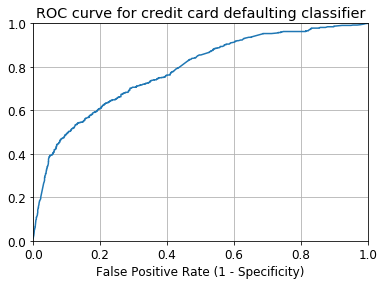

In [213]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for credit card defaulting classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [209]:
auc_roc_1 = str(metrics.roc_auc_score(y_test, y_pred_prob))
print('AUC with dimensionality reduction: \n' + auc_roc_1)
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC with dimensionality reduction: 
0.7835722325211865
AUC without dimensionality reduction: 
0.7887846326619228


<h2>Conclusion</h2>
We were able to reduce the size of our training/test set by 26% by removing 6 features, while only giving up 0.52% in our AUC accuracy



- AUC is useful as a single number summary of classifier performance
- Higher value means that it is a better classifier
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation
- AUC is useful even when there is high class imbalance (unlike classification accuracy)



It is a good thing that the prediction accuracy is greater than the null accuracy because it shows us that the model is performing better than by just predicting the most frequent class. 

<h2>Confusion matrix </h2>

In [212]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

[[2252  108]
 [ 407  233]]




<b>Basic terminology</b>

- <b>True Positives (TP)</b>: we correctly predicted that they would default. 
    - 233
     
     
- <b>True Negatives (TN)</b>: we correctly predicted that they won't default.
    - 2252
     
    
- <b>False Positives (FP)</b>: we incorrectly predicted that they did default.
    - 108
    - Falsely predict positive
    - Type I error
      
       
- <b>False Negatives (FN)</b>: we incorrectly predicted that they didn't default. 
    - 407
    - Falsely predict negative
    - Type II error

